In [4]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [5]:
import numpy as np
import healpy as hp

In [6]:
from systematics import sys_iteration, fitting_SP, sys_ngal

In [7]:
def weightmultiply( weightDic ):
    
    length = weightDic['noweight'].size
    w0 = np.ones(length)
    names = weightDic.keys()
    print names
    n = len(names)
    for i in range(n):
        print names[i]
        w0 *= weightDic[names[i]]
        
    return w0
    

In [8]:
def fitting_allSP( suffix, inputdir = None ):
    filters = ['g', 'r', 'i', 'z']
    fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
               suffix=suffix, plot=True, function = 'linear',
                    path = inputdir )

    fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
               suffix=suffix, plot=True, function = 'sqrt',
                    path = inputdir )

    fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
               suffix=suffix, plot=True, function = 'errftn',
                path = inputdir )

    fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
               suffix=suffix, plot=True, function = 'linear',
                    path = inputdir )

    fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                    path = inputdir )
    


In [9]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None ):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'GE':
            sysMap = loadSystematicMaps( property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
         
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [10]:
def maskingCatalogSP(catalog=None, sysMap=None):
    
    
    exp_i_hpind = sysMap['sys_EXPTIME_i_SPT']['PIXEL'][(sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500)]
    fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.09)]
    ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 100000)]
    #skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 170)]
    #skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400)]
    skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 1700000)]
    skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 14000000)]  
    
    all_mask1 = np.zeros( hp.nside2npix(4096), dtype=bool )
    all_mask2 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask3 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask4 = np.zeros( hp.nside2npix(4096),dtype=bool )
    
    all_mask512 = np.zeros( hp.nside2npix(512),dtype=bool )
    
    all_mask1[exp_i_hpind] = 1
    all_mask2[fwhm_r_hpind] = 1
    all_mask3[skybrite_g_hpind] = 1
    all_mask4[skybrite_i_hpind] = 1
    
    all_mask512[ge_hpind] = 1
    all_mask4096 = all_mask1 * all_mask2 * all_mask3* all_mask4


    all_ind4096 = np.arange( hp.nside2npix(4096) )
    all_ind512 = np.arange( hp.nside2npix(512) )
    goodindices4096 = all_ind4096[all_mask4096]
    goodindices512 = all_ind512[all_mask512]
  
    
    #goodindices = np.hstack([exp_i_hpind, fwhm_r_hpind, ge_hpind])
    
    #exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
    #fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
    #            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))

    fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
    skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
    &(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
    
    #ge_mask = (sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.08)  
    #all_mask = fwhm_mask*exp_mask*skybrite_mask
    #print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
    #print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
    #print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
    #print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size   

    catHpInd4096 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=4096, nest=False)
    catHpInd512 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=512, nest=False)
    HpIdxInsys_mask4096 = np.in1d(catHpInd4096, goodindices4096)
    HpIdxInsys_mask512 = np.in1d(catHpInd512, goodindices512)
    
    HpIdxInsys_mask = HpIdxInsys_mask4096 * HpIdxInsys_mask512
    
    print HpIdxInsys_mask.size, np.sum(HpIdxInsys_mask)
    print 'mask ', np.sum(HpIdxInsys_mask) * 1./catalog.size
    return catalog[HpIdxInsys_mask]
    

/n/home00/lee.5922/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


figsave : .//spatialtest_.png


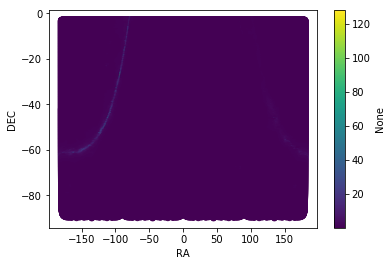

In [25]:
sysMap_ge_cut = Cuts.keepGoodRegion(sysMap['sys_GE_g_SPT'])

spatialcheck( [sysMap['sys_GE_g_SPT']], zaxis = sysMap['sys_GE_g_SPT']['SIGNAL'])

In [11]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [12]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = cutcat20(dmass)
cmass = fitsio.read('../output/n2/dmass_st82.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11593


In [13]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

510883 112398
188317 11593


In [14]:
kind = 'SPT'
FullArea = SPTMaparea
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS_allband', 'GE']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately

In [15]:
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [16]:
#sys_nstar = calling_sysMap( properties=['NSTARS_allband'], kind='SPT', nside=4096 )
#sysMap['sys_NSTARS_allband_g_SPT'] = sys_nstar['sys_NSTARS_allband_g_SPT']

In [17]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 108272
mask  0.9632911617644442
510883 494731
mask  0.9683841505785082
2549538 2469143
mask  0.9684668359522391


In [19]:
inputdir = '../data_txt/systematics/6th_include_ge/'
figoutdir = inputdir+'/figure/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+inputdir+'/weights/')
os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

0

In [20]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =15, 
         reweight= None, nside = 4096,
         suffix='no_weight', outdir=inputdir)

../systematics.py:452: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:456: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:456: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_no_weight.txt


saving fig to  ../data_txt/systematics/6th_include_ge//figure/systematic_GE_SPT_no_weight.png


0

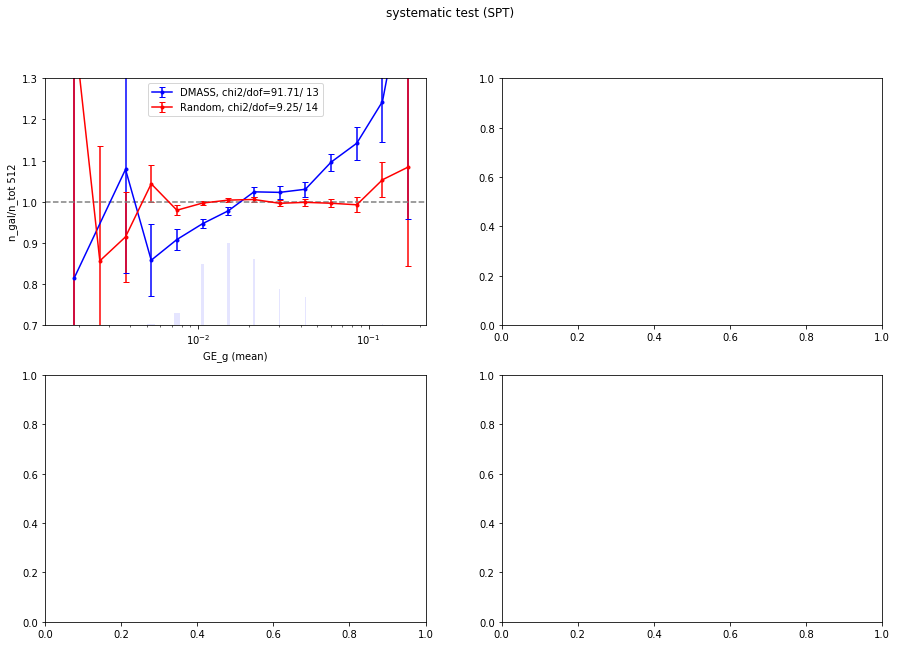

In [22]:
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = kind, suffix='no_weight', \
                         inputdir=inputdir, outdir=figoutdir)

In [34]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = properties, kind='SPT', nbins =15, 
         reweight= None, nside = 4096,
         suffix='no_weight', outdir=inputdir)

saving data to  ../data_txt/systematics/4th/systematic_DEPTH_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_DEPTH_r_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_DEPTH_i_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_DEPTH_z_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_EXPTIME_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_EXPTIME_r_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_EXPTIME_i_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_EXPTIME_z_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_AIRMASS_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_AIRMASS_r_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_AIRMASS_i_SPT_no_weight.txt
saving data to  ../data_txt/systematics/4th/systematic_AIRMASS_z_SPT_no_weight.txt
saving data 

saving fig to  ../data_txt/systematics/4th/figure/systematic_DEPTH_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_EXPTIME_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_AIRMASS_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_SKYBRITE_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_FWHM_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_NSTARS_allband_SPT_no_weight.png
saving fig to  ../data_txt/systematics/4th/figure/systematic_GE_SPT_no_weight.png


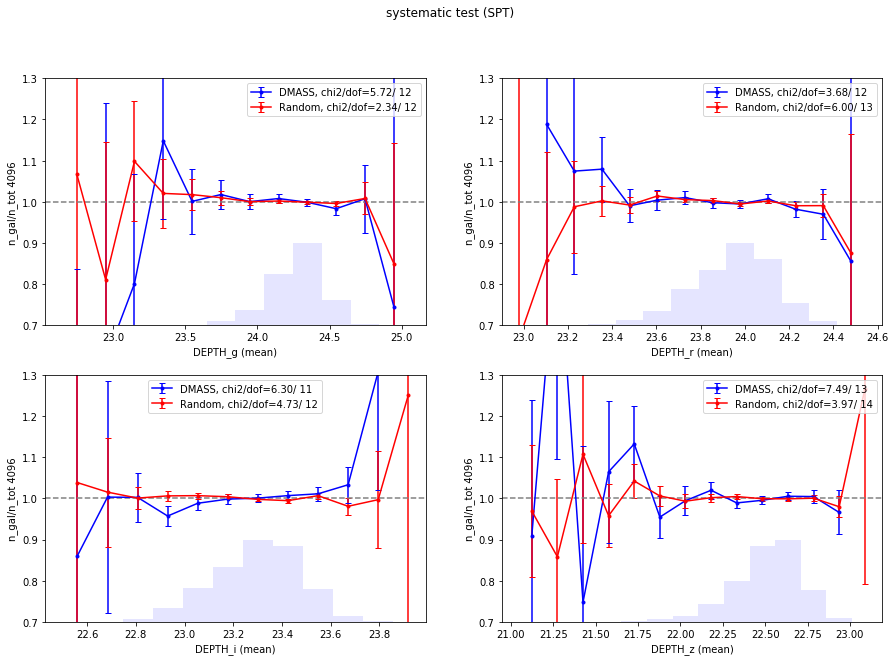

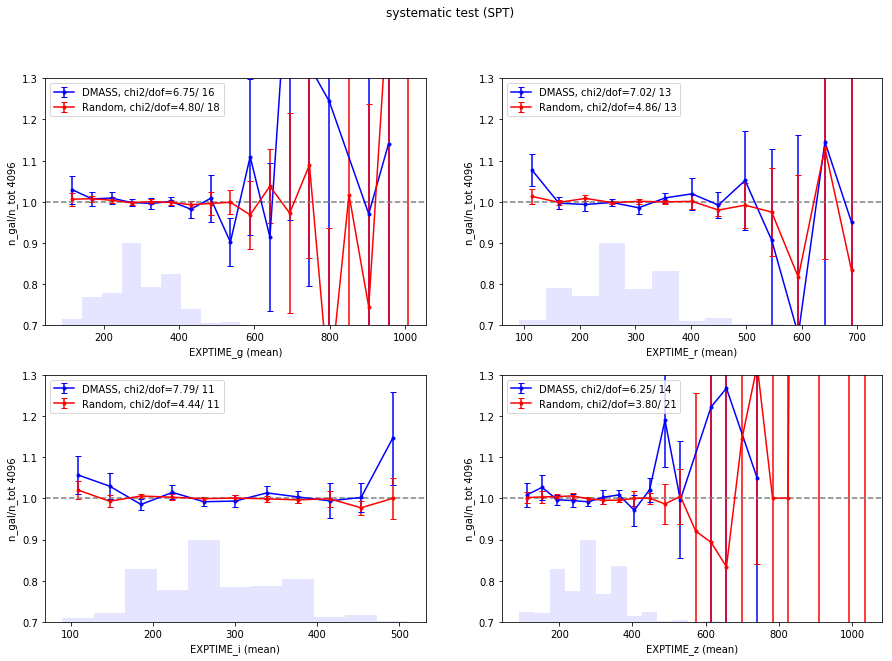

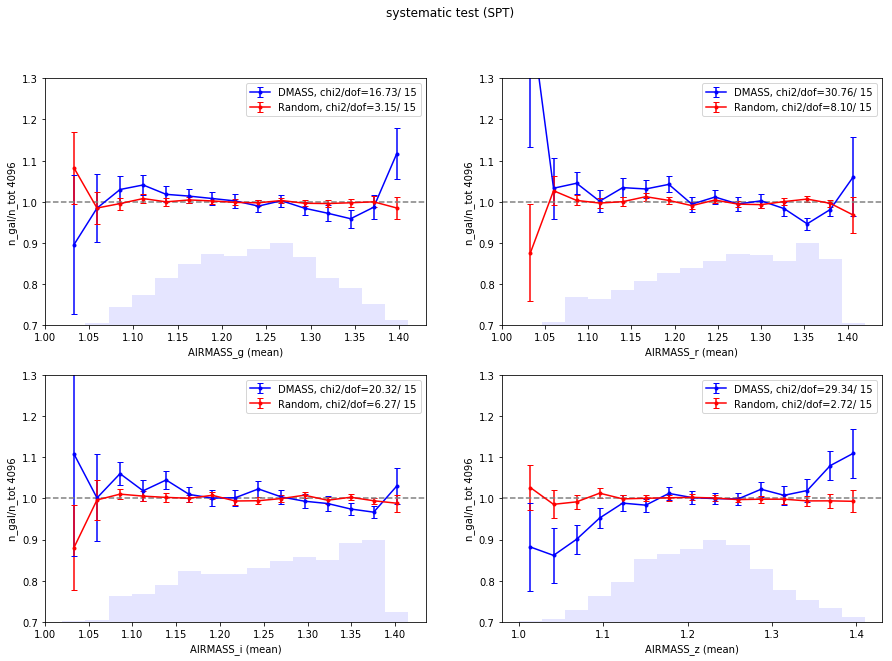

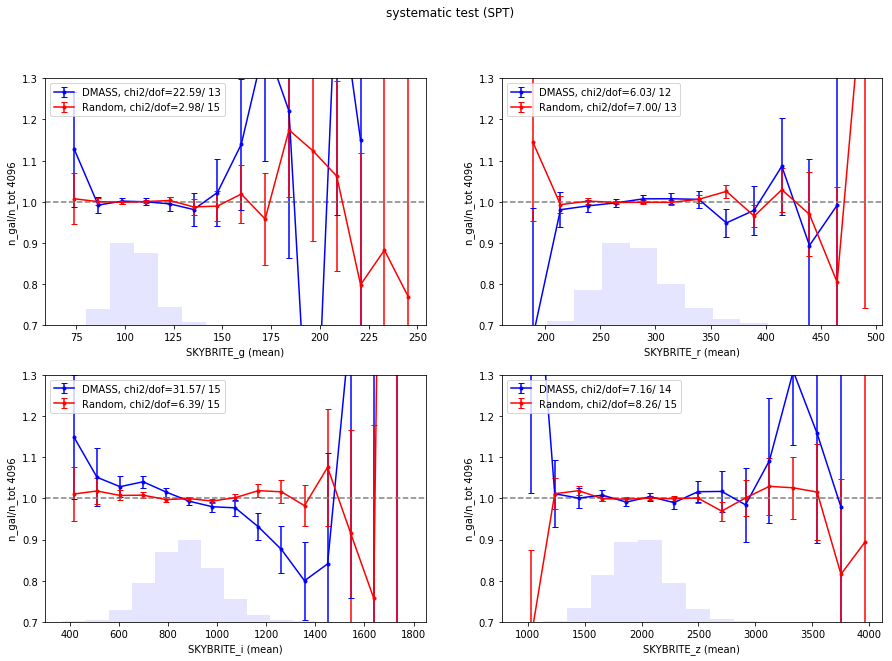

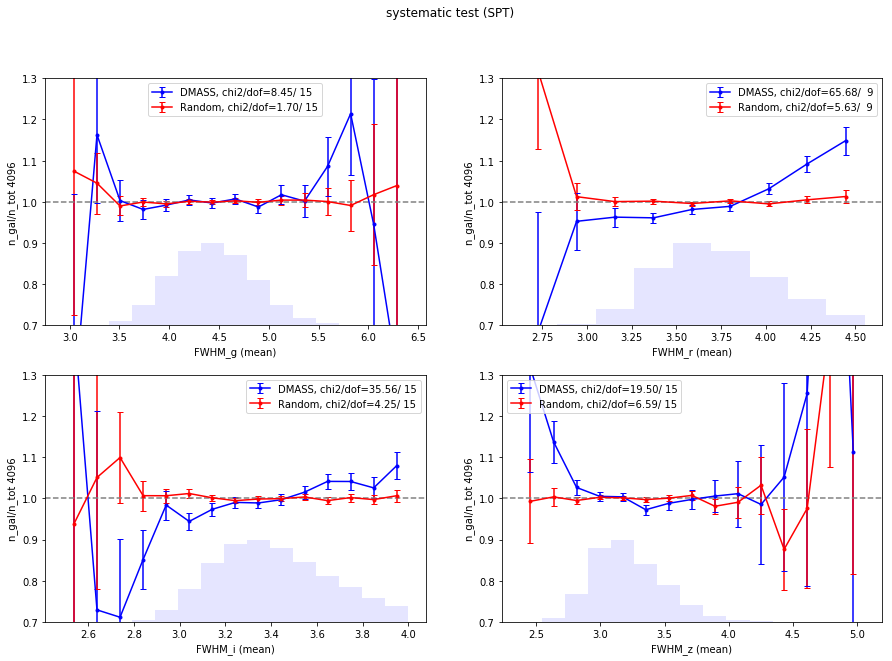

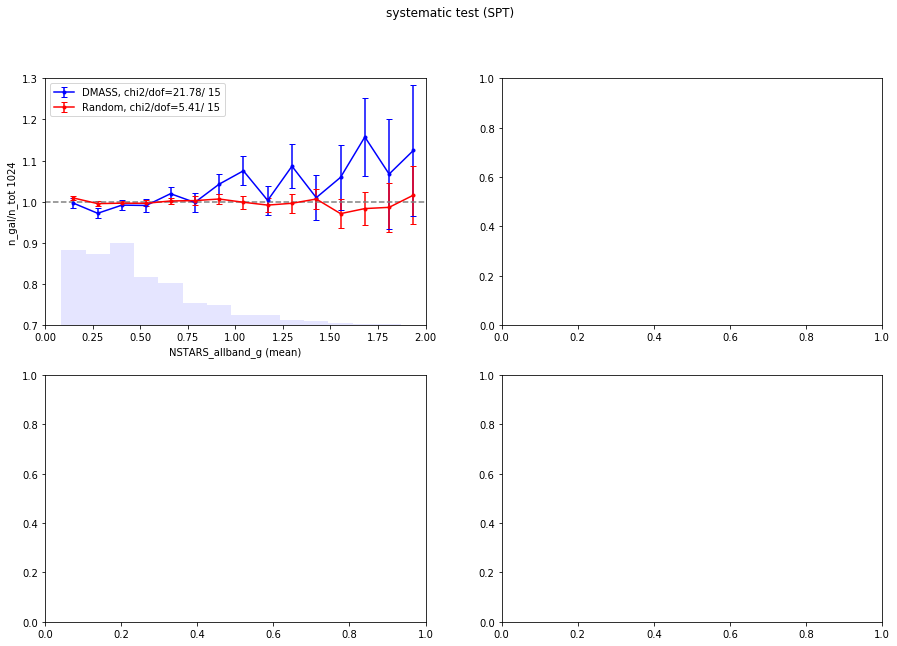

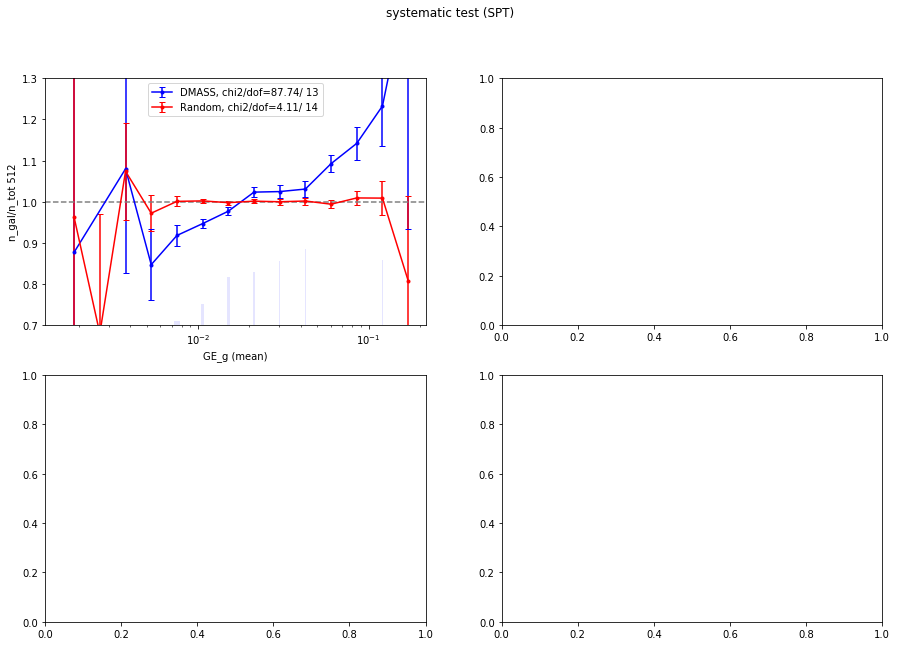

In [37]:
from systematics_module.contCorrection import doVisualization_ngal

for p in properties : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='no_weight', \
                         inputdir=inputdir, outdir=figoutdir)

chi2_null =  21.778518563677956
chi2_mod. =  10.188101728396207
Delta chi2 (sample) = 11.590416835281749
output save to  ../data_txt/systematics/6th_include_ge/systematic_NSTARS_allband_g_SPT_no_weight.txt.model

chi2_null =  87.73554134200364
chi2_mod. =  7.898186213009346
Delta chi2 (sample) = 79.83735512899429
output save to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_no_weight.txt.model

chi2_null =  5.715908628583887
chi2_mod. =  4.673720860347582
Delta chi2 (sample) = 1.042187768236305
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_no_weight.txt.model

chi2_null =  3.6751189521080327
chi2_mod. =  3.0601508404775086
Delta chi2 (sample) = 0.6149681116305241
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_no_weight.txt.model

chi2_null =  6.30188008356699
chi2_mod. =  2.339843528528319
Delta chi2 (sample) = 3.9620365550386714
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_no_w

(['GE_g',
  'FWHM_r',
  'FWHM_i',
  'SKYBRITE_i',
  'AIRMASS_r',
  'AIRMASS_z',
  'AIRMASS_i',
  'NSTARS_allband_g',
  'AIRMASS_g',
  'FWHM_z',
  'DEPTH_i',
  'EXPTIME_g',
  'DEPTH_g',
  'FWHM_g',
  'DEPTH_r',
  'SKYBRITE_g',
  'EXPTIME_z',
  'EXPTIME_i',
  'SKYBRITE_z',
  'SKYBRITE_r',
  'DEPTH_z',
  'EXPTIME_r'],
 [79.83735512899429,
  53.49617865476577,
  28.509744706065348,
  26.760437131711505,
  18.367289560103742,
  17.471874037287286,
  13.953920005412595,
  11.590416835281749,
  7.180282678905282,
  5.015956513125536,
  3.9620365550386714,
  1.8176606759773017,
  1.042187768236305,
  0.8288005497627875,
  0.6149681116305241,
  0.45263595633948484,
  0.2764250508388004,
  0.13316766113053813,
  0.12007363708290963,
  0.11243766010556655,
  0.010894676698766759,
  0.005140852971523557])

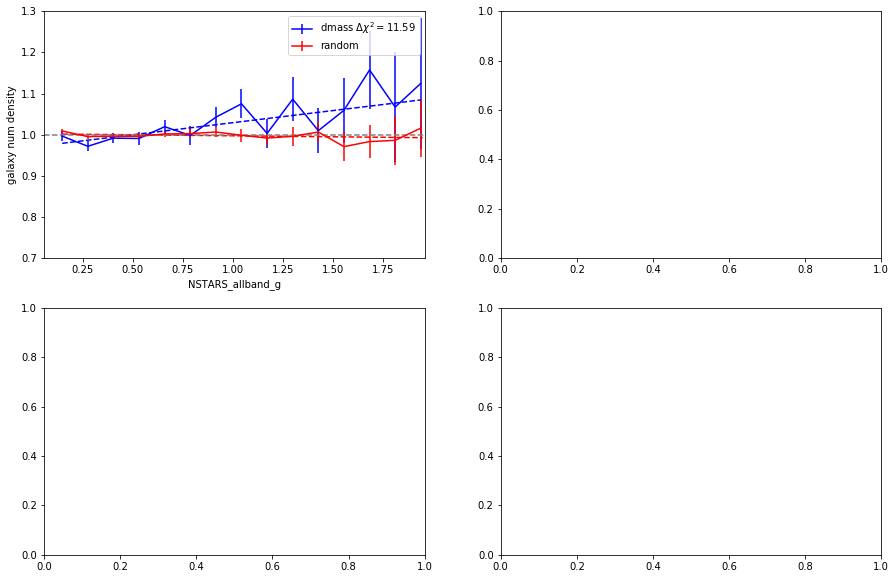

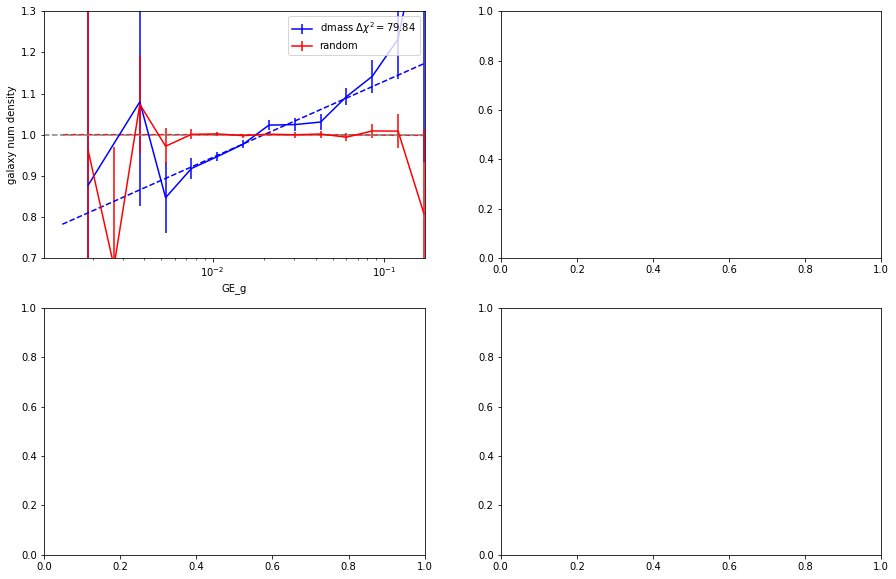

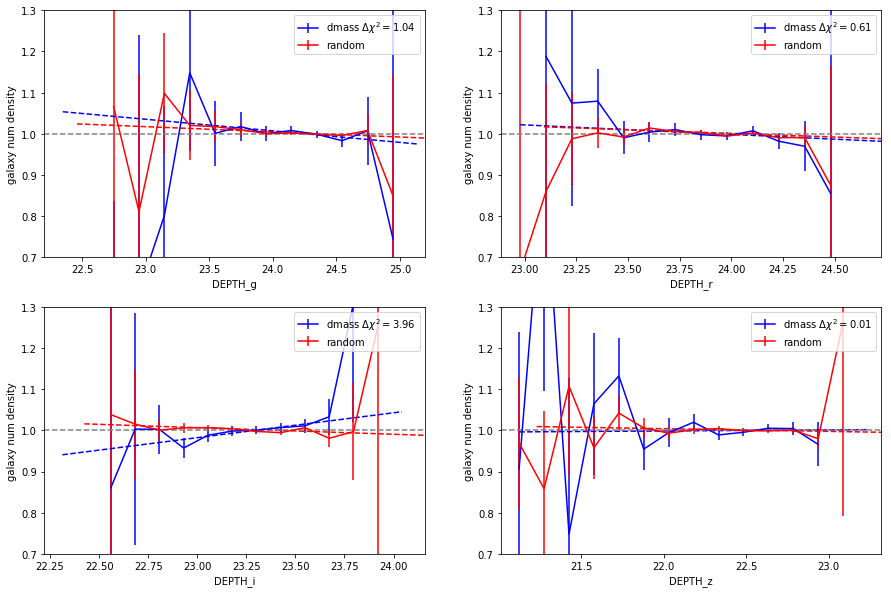

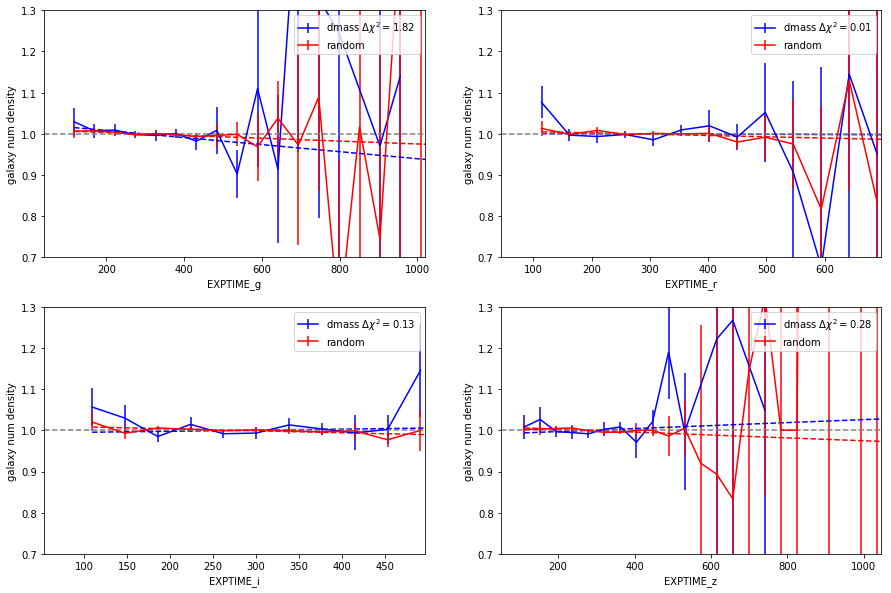

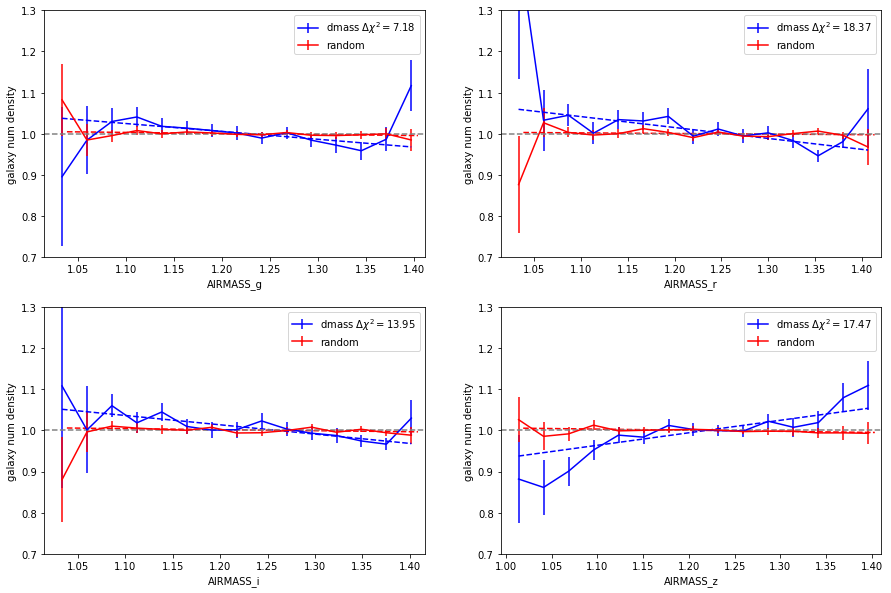

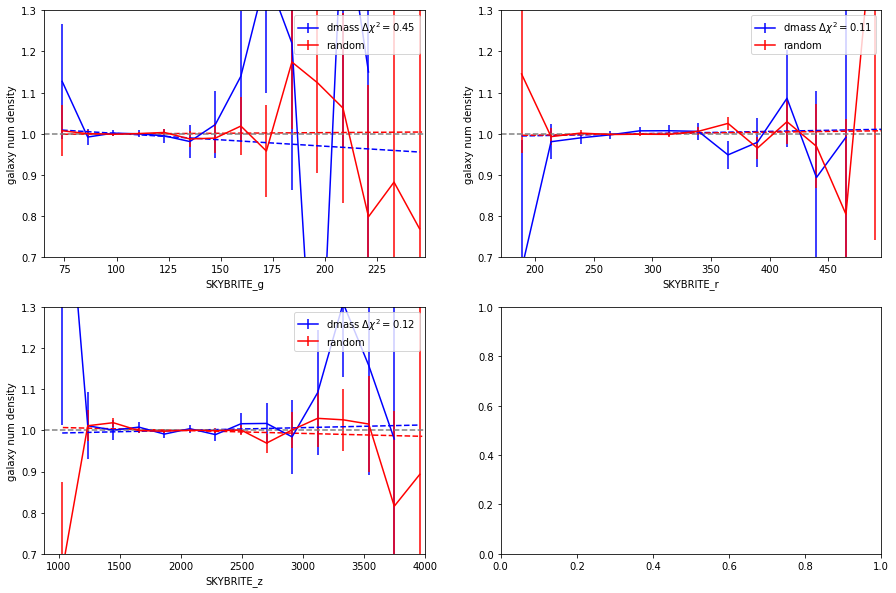

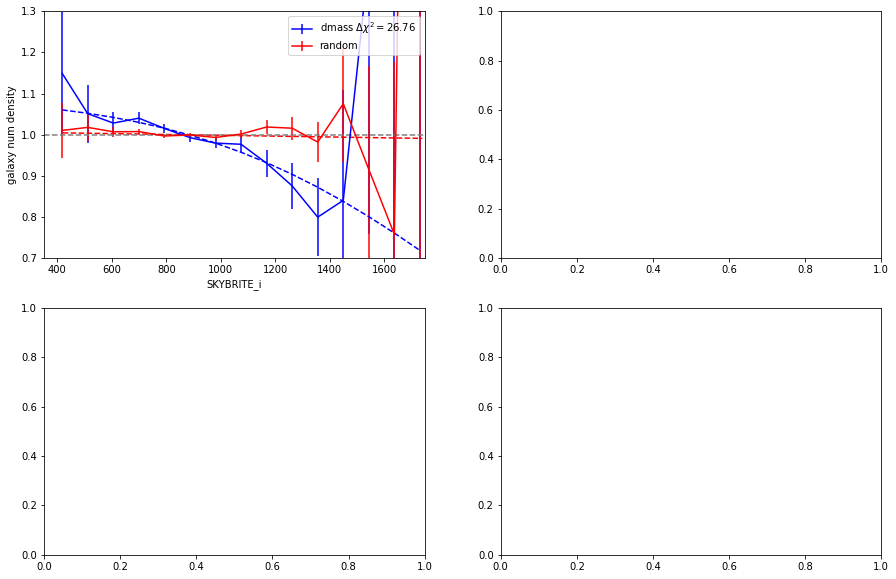

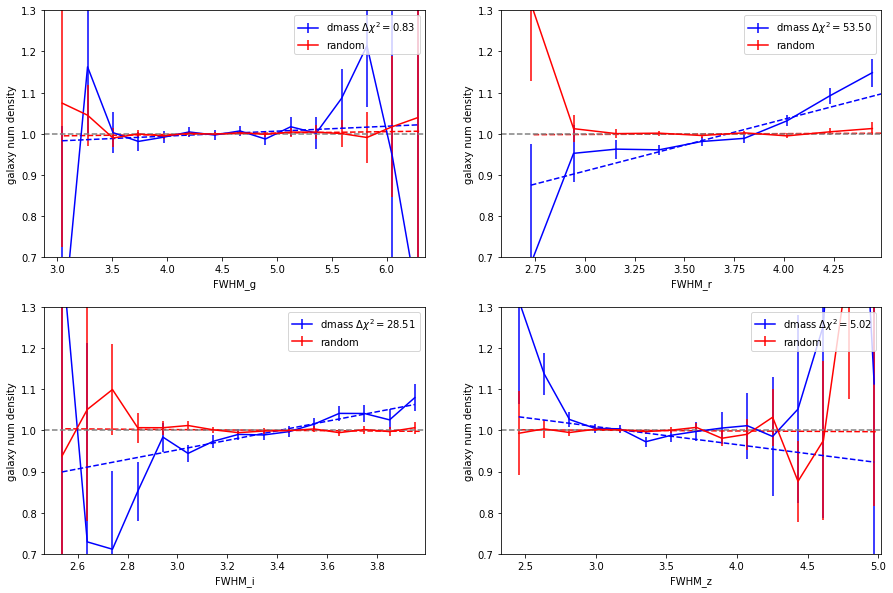

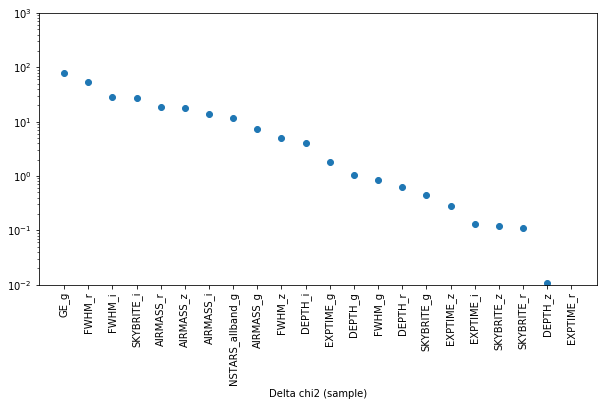

In [15]:
filters = ['g']
fitting_SP( property = ['NSTARS_allband'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'log',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['DEPTH'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['EXPTIME'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['AIRMASS'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['g', 'r', 'z']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['i']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'errftn',
                path = inputdir )


filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['FWHM'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, suffix='no_weight', 
                path = inputdir, deltachi2=True)


# Correction ! 

### Galactic Extinction

In [56]:
weightDic = {}
weightDic['noweight'] = np.ones(dmass_masked.size)
all_weight = weightmultiply(weightDic)
suffix = 'no_weight'
nextweight = 'GE_g'

['noweight']
noweight


----------------------------------
initialize function  GE_g
log
store weight  GE_g
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_ge_g_SPT.fits
suffix =  wg_ge_g
chi2_null =  3.738389920522511
chi2_mod. =  3.4164154014665256
Delta chi2 (sample) = 0.3219745190559853
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g.txt.model

chi2_null =  2.8539950524574276
chi2_mod. =  2.77541180600452
Delta chi2 (sample) = 0.07858324645290748
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g.txt.model

chi2_null =  4.973835607731405
chi2_mod. =  2.476667298206793
Delta chi2 (sample) = 2.497168309524612
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g.txt.model

chi2_null =  6.334667730806616
chi2_mod. =  6.232973147525806
Delta chi2 (sample) = 0.1016945832808096
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g.txt.model

chi2_null = 

(['FWHM_r',
  'FWHM_i',
  'AIRMASS_z',
  'SKYBRITE_i',
  'SKYBRITE_z',
  'AIRMASS_r',
  'AIRMASS_g',
  'AIRMASS_i',
  'DEPTH_i',
  'EXPTIME_g',
  'NSTARS_allband_g',
  'FWHM_z',
  'FWHM_g',
  'SKYBRITE_g',
  'EXPTIME_z',
  'DEPTH_g',
  'DEPTH_z',
  'GE_g',
  'EXPTIME_i',
  'DEPTH_r',
  'SKYBRITE_r',
  'EXPTIME_r'],
 [65.20206397257047,
  26.412876065416324,
  21.968157392714378,
  15.782860497659073,
  4.965120869484781,
  4.391277089641514,
  3.7476171699520595,
  3.3161159718175037,
  2.497168309524612,
  1.5274130120279201,
  1.444882391366665,
  1.4170530764563054,
  1.217332634061992,
  1.0049393348187117,
  0.6227603956065044,
  0.3219745190559853,
  0.1016945832808096,
  0.0807570647753515,
  0.07925714177698939,
  0.07858324645290748,
  0.06935473450080742,
  0.014218895595478287])

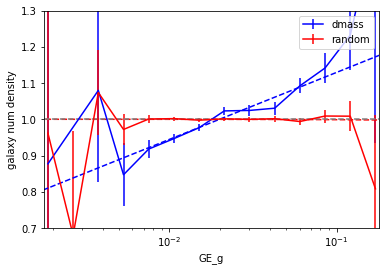

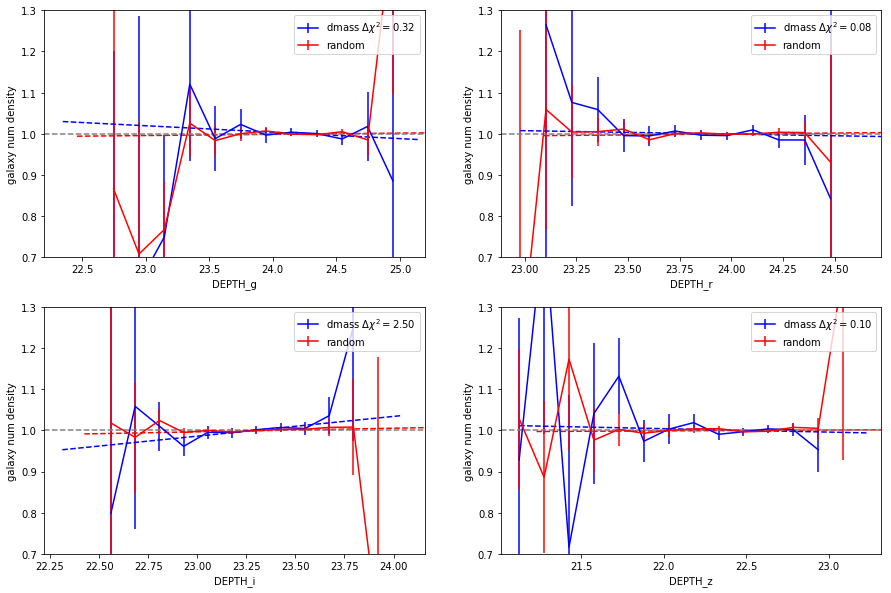

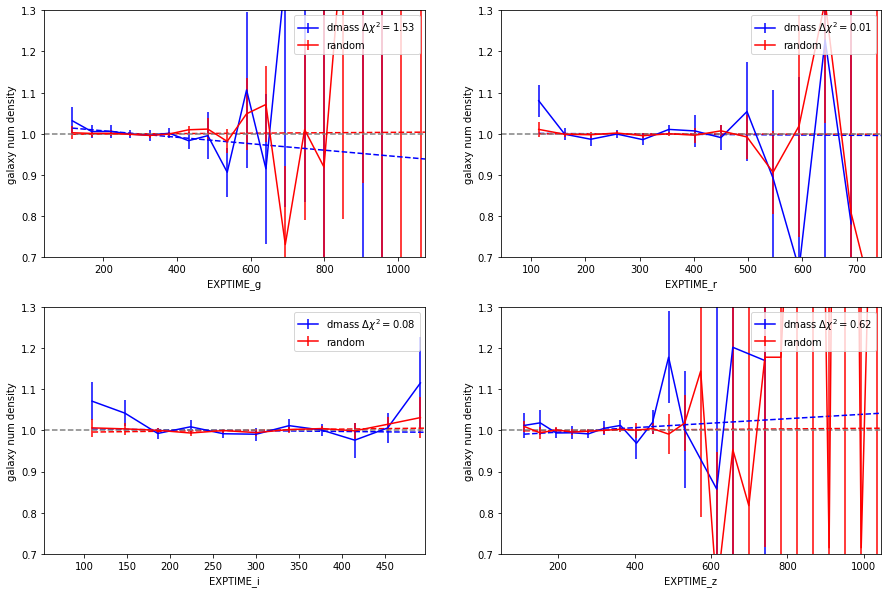

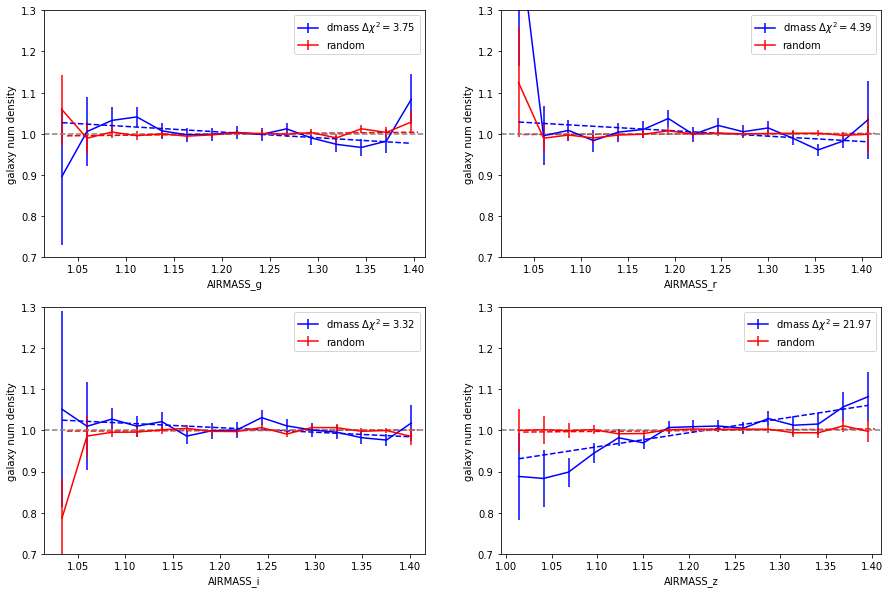

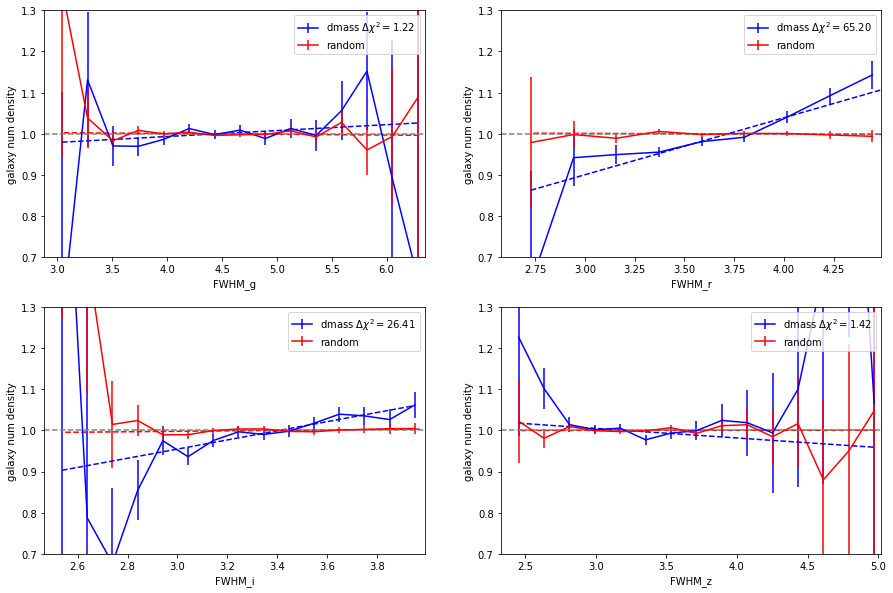

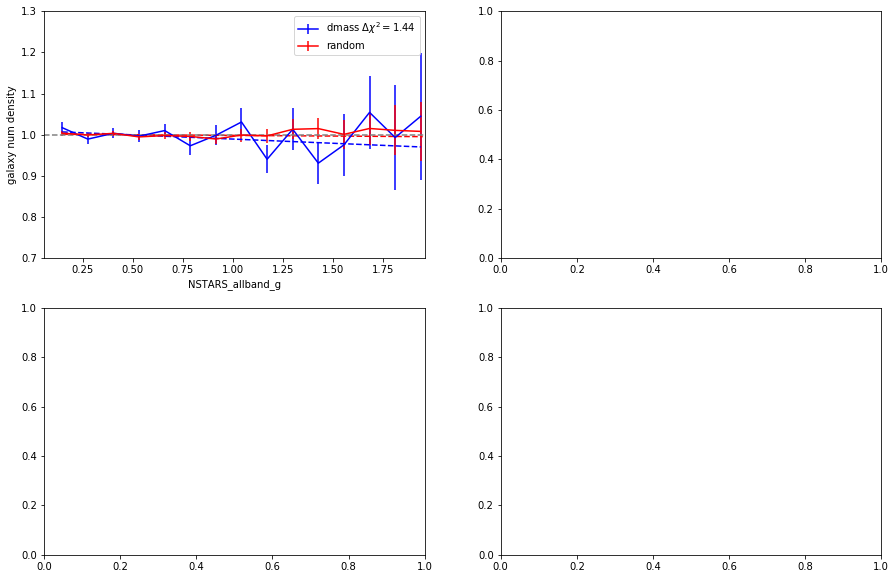

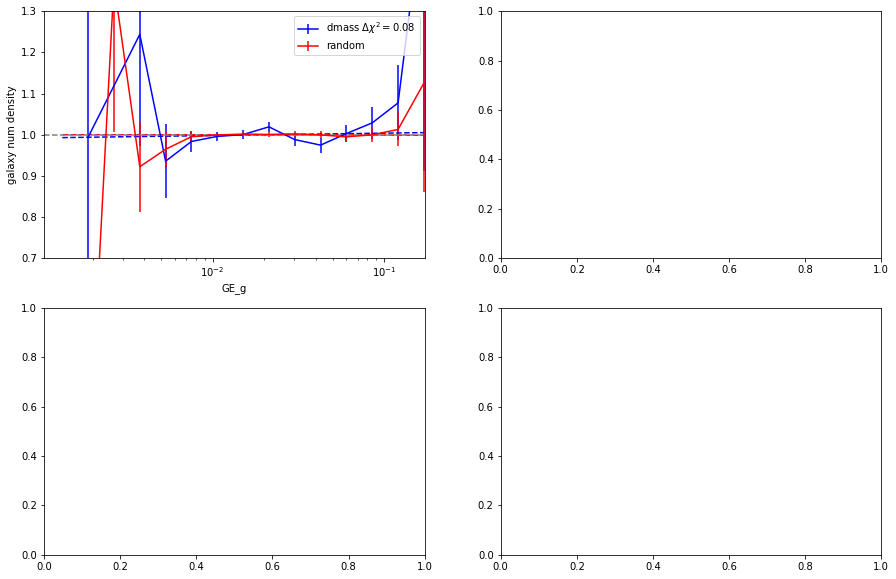

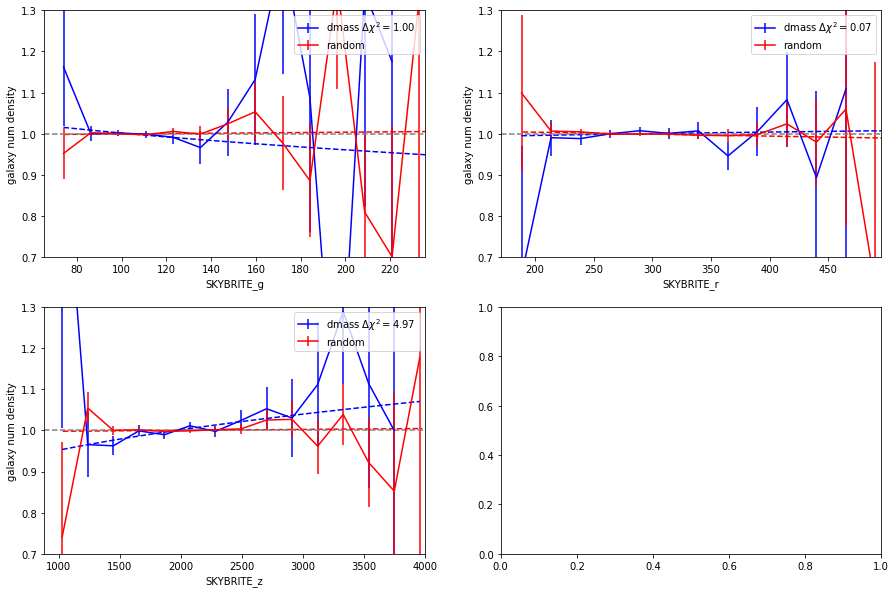

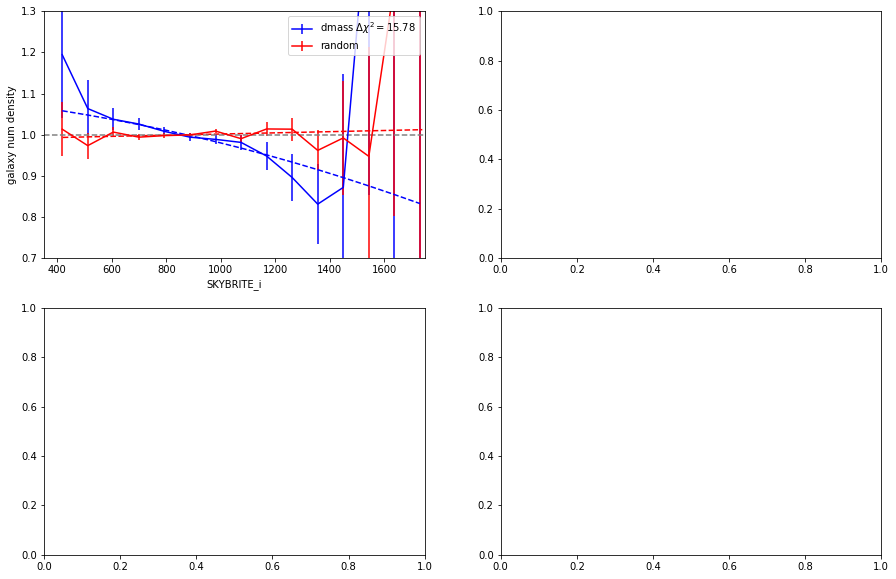

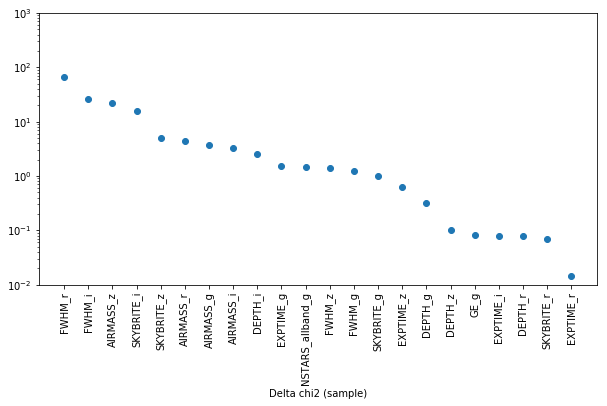

In [57]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='log', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = 'wg_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['noweight', 'GE_g']
noweight
GE_g
----------------------------------
initialize function  FWHM_r
linear
store weight  FWHM_r
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_fwhm_r_SPT.fits
suffix =  wg_ge_g_fwhm_r
chi2_null =  4.266567594119423
chi2_mod. =  3.345736315499252
Delta chi2 (sample) = 0.9208312786201711
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r.txt.model

chi2_null =  3.8588246608109067
chi2_mod. =  2.8250332569200345
Delta chi2 (sample) = 1.0337914038908722
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r.txt.model

chi2_null =  3.4305548142826368
chi2_mod. =  2.630798180088845
Delta chi2 (sample) = 0.7997566341937916
output save to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r.txt.model

chi2_null =  6.6973540257341515
chi2_mod. =  6.091754567424999
Delta chi2 (sample) = 0.6055994583091522
output save to  ../data_txt/system

(['AIRMASS_z',
  'SKYBRITE_z',
  'SKYBRITE_i',
  'FWHM_i',
  'FWHM_z',
  'SKYBRITE_r',
  'EXPTIME_g',
  'AIRMASS_g',
  'AIRMASS_i',
  'DEPTH_r',
  'DEPTH_g',
  'NSTARS_allband_g',
  'GE_g',
  'DEPTH_i',
  'AIRMASS_r',
  'FWHM_g',
  'DEPTH_z',
  'EXPTIME_r',
  'EXPTIME_z',
  'EXPTIME_i',
  'SKYBRITE_g',
  'FWHM_r'],
 [24.603578397844835,
  8.65936776339224,
  8.556004873595864,
  5.598210492367832,
  2.30573626980323,
  2.2212333308855534,
  2.0937716079502104,
  1.547592709316035,
  1.4017221106686417,
  1.0337914038908722,
  0.9208312786201711,
  0.9031040500033463,
  0.8353589089072386,
  0.7997566341937916,
  0.7905977289793249,
  0.7094065482379417,
  0.6055994583091522,
  0.45498625303283013,
  0.29417882973855036,
  0.21866976708945352,
  0.1612268616751038,
  0.10107229237199888])

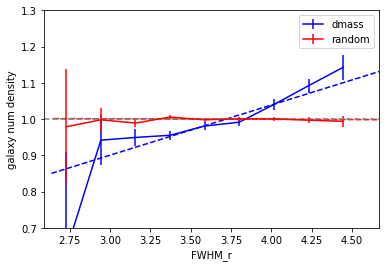

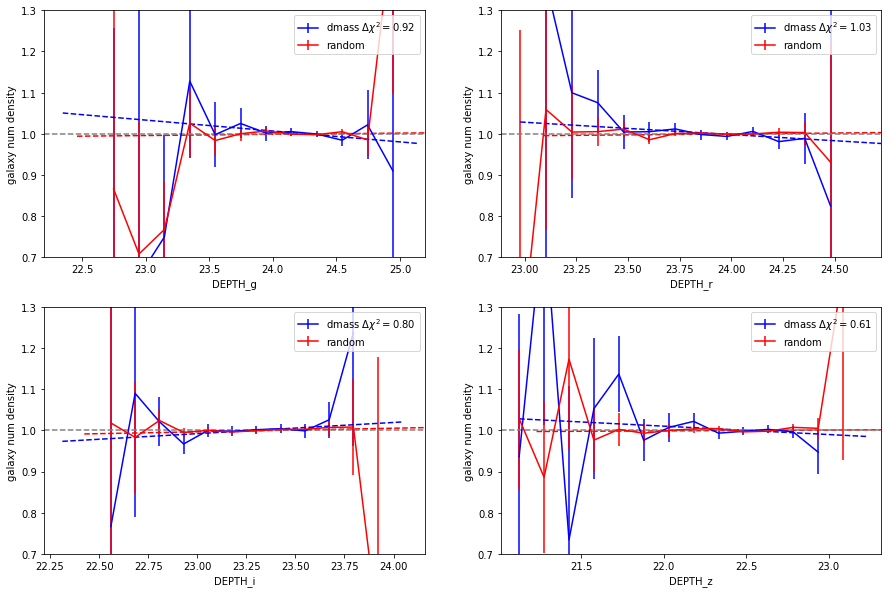

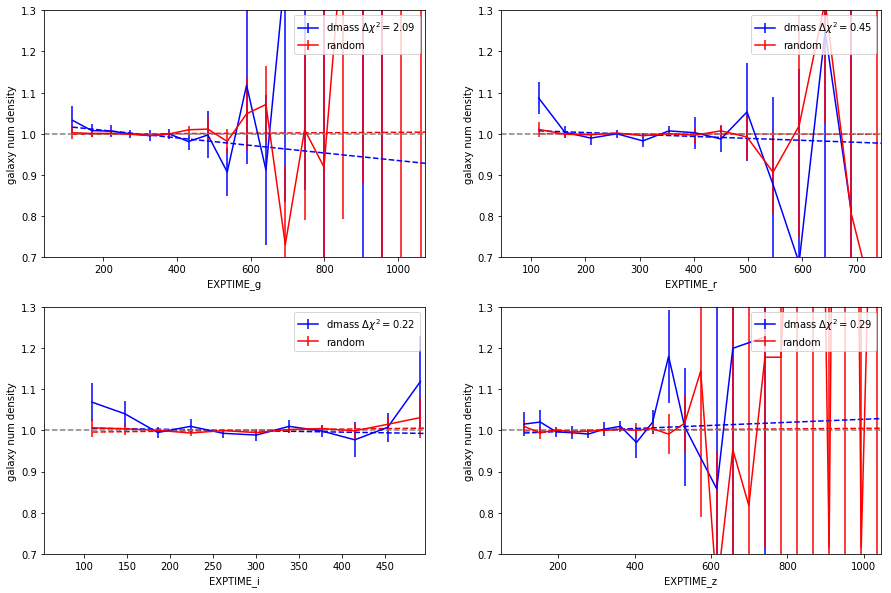

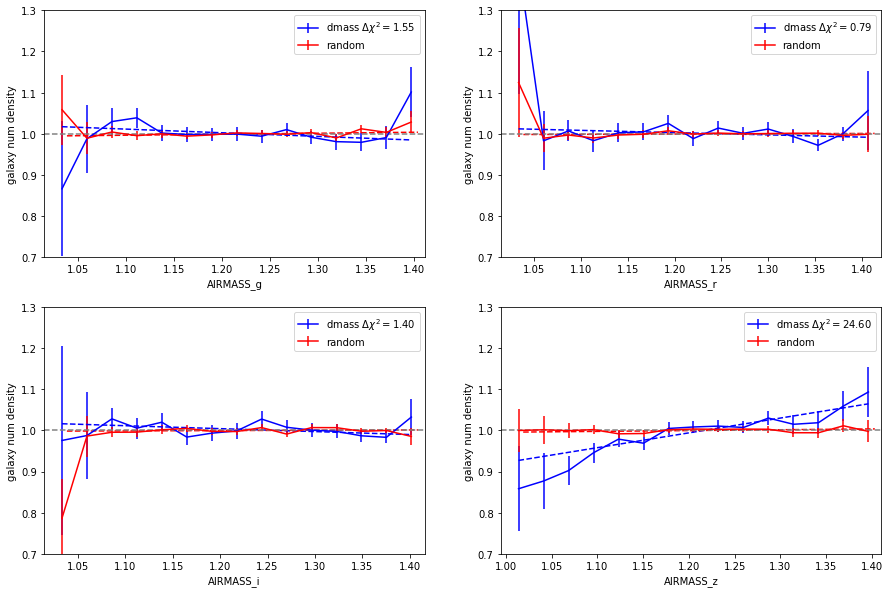

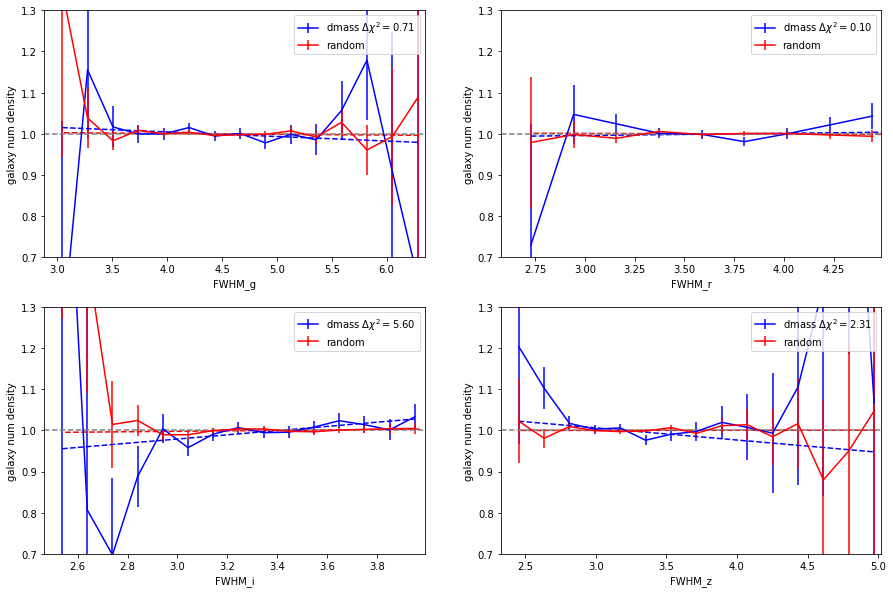

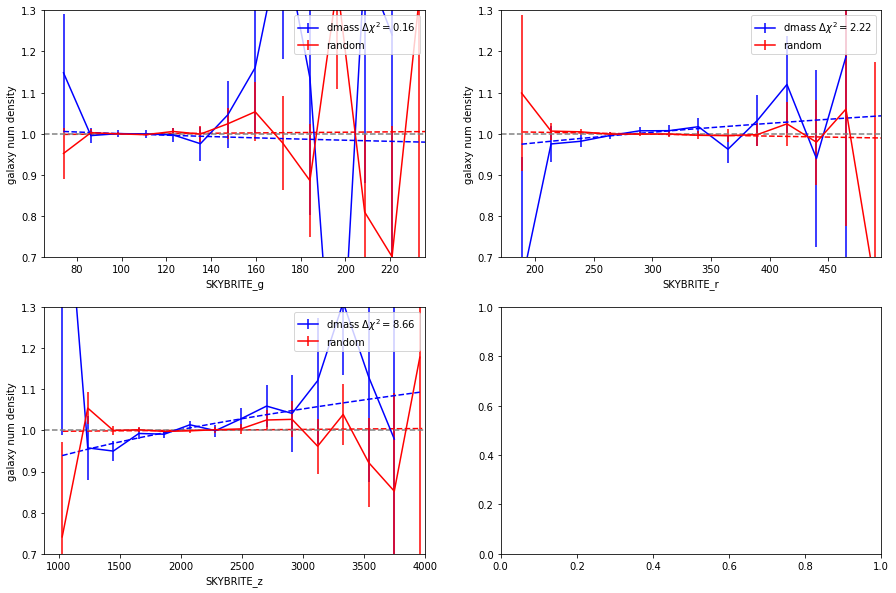

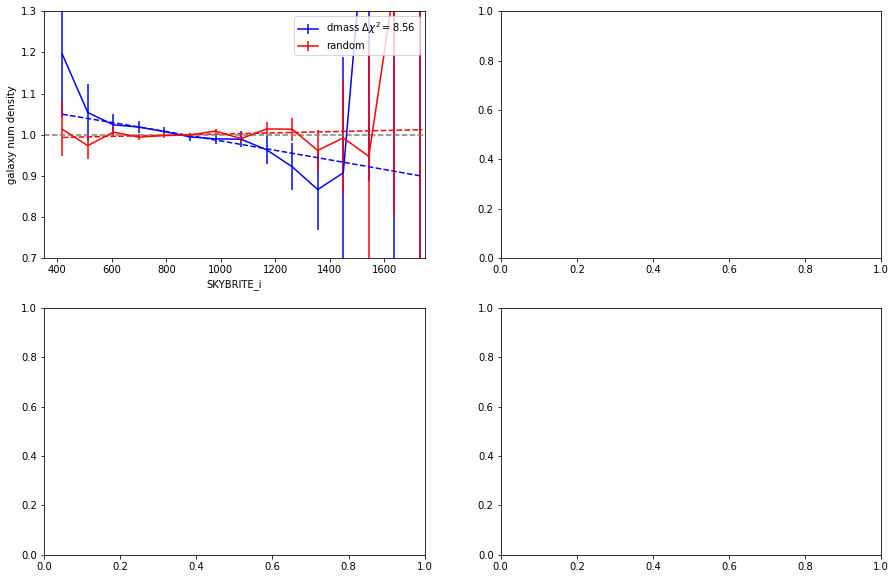

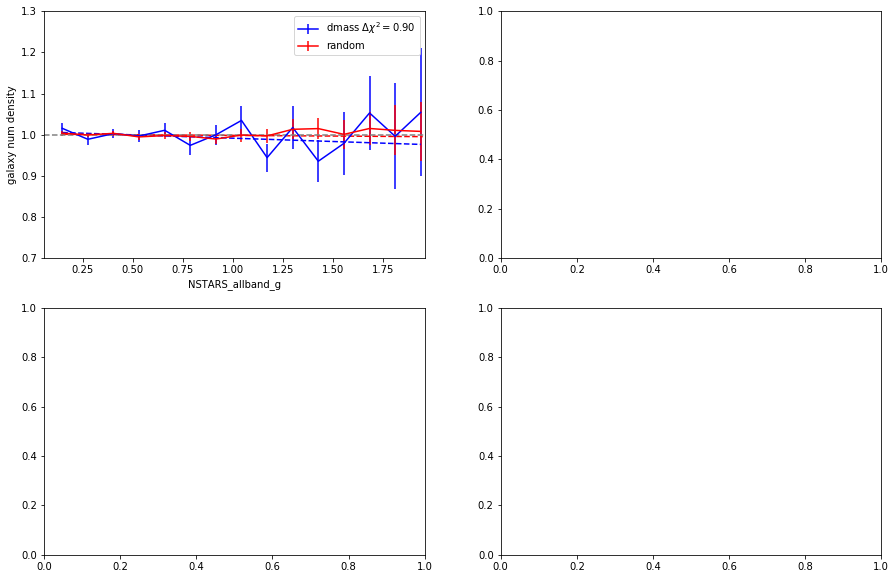

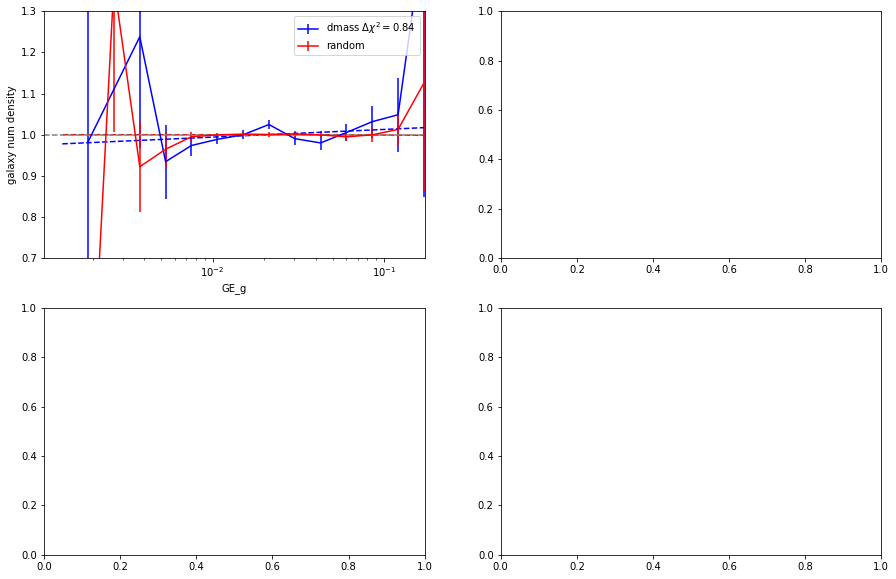

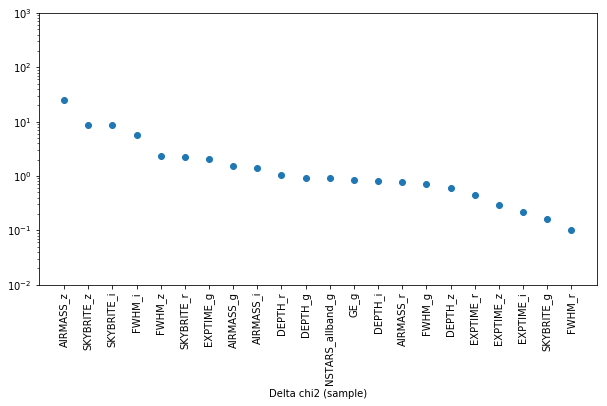

In [59]:
nextweight = 'FWHM_r'

all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['noweight', 'GE_g', 'FWHM_r']
noweight
GE_g
FWHM_r
----------------------------------
initialize function  AIRMASS_z
linear
store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_airmass_z_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_r_SPT_wg_ge_g_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_i_SPT_

(['SKYBRITE_i',
  'AIRMASS_i',
  'AIRMASS_r',
  'AIRMASS_g',
  'FWHM_i',
  'SKYBRITE_r',
  'EXPTIME_g',
  'DEPTH_r',
  'GE_g',
  'DEPTH_g',
  'FWHM_z',
  'EXPTIME_r',
  'DEPTH_i',
  'SKYBRITE_g',
  'SKYBRITE_z',
  'EXPTIME_i',
  'NSTARS_allband_g',
  'FWHM_r',
  'AIRMASS_z',
  'FWHM_g',
  'EXPTIME_z',
  'DEPTH_z'],
 [14.240635235229817,
  13.86282808918362,
  10.507918681505195,
  9.182119513045519,
  7.51169599321918,
  3.657792167218317,
  2.6298251116056983,
  2.318075778525825,
  2.20025229317094,
  1.3804043300020639,
  1.0618826442539184,
  0.9045847169567267,
  0.8178076589202927,
  0.683392731070601,
  0.5013134473354537,
  0.46485731496582083,
  0.3727678514630597,
  0.3338297043008982,
  0.3141718486278613,
  0.2520377228853423,
  0.18522723172381994,
  0.12136059815091382])

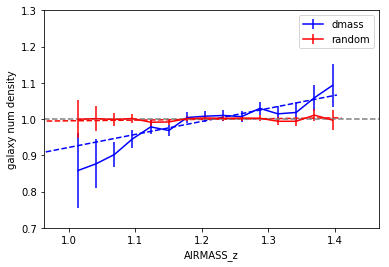

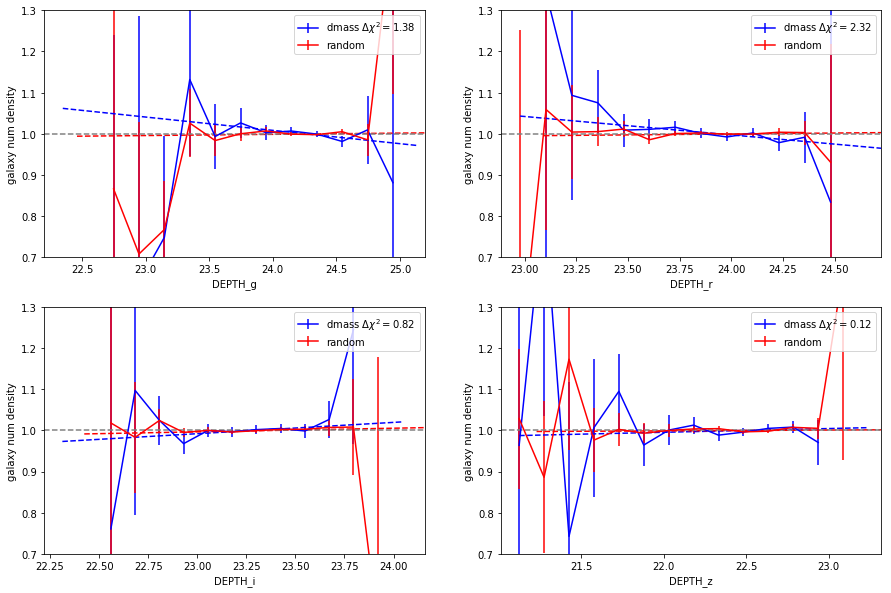

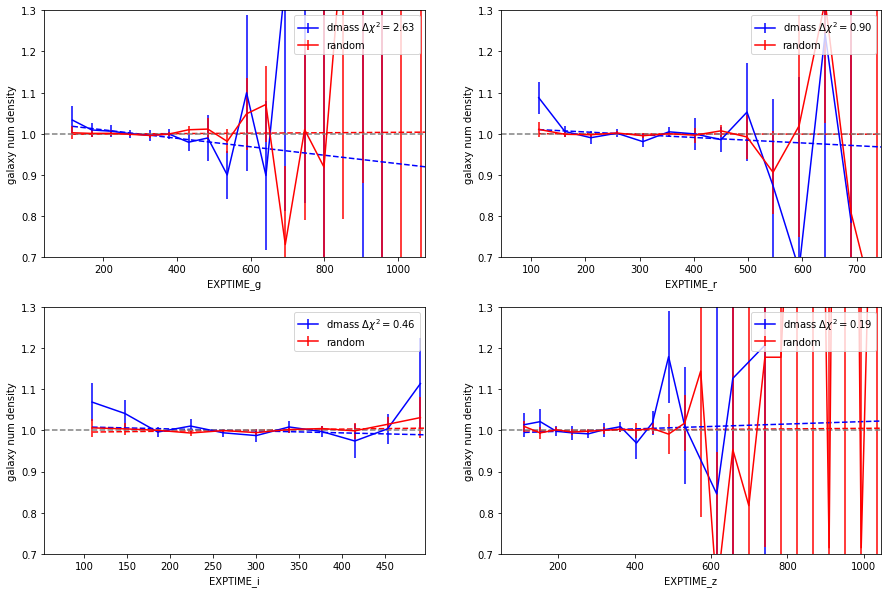

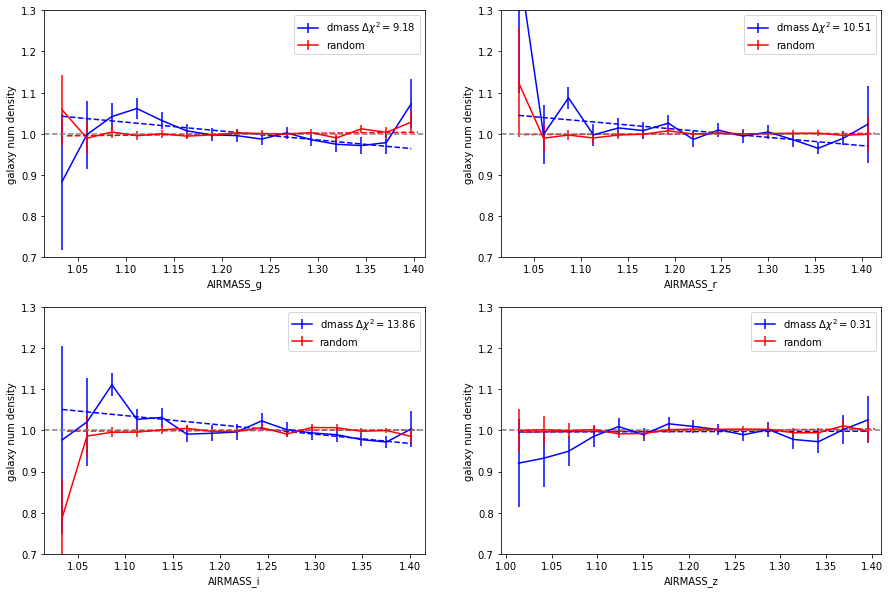

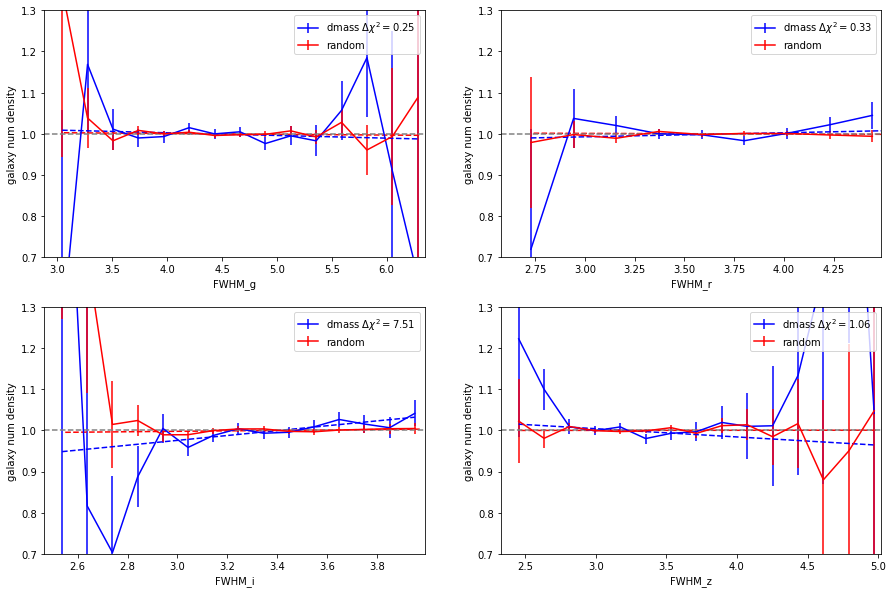

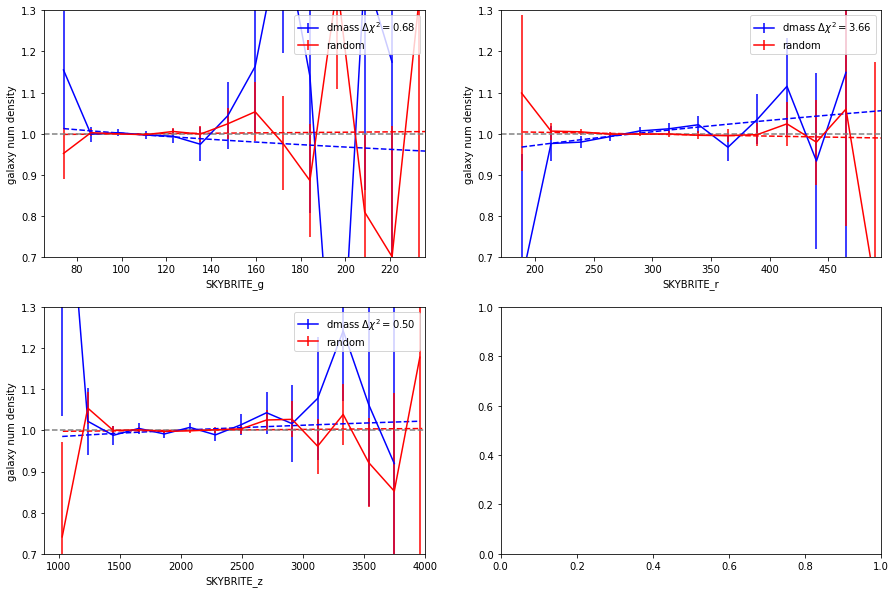

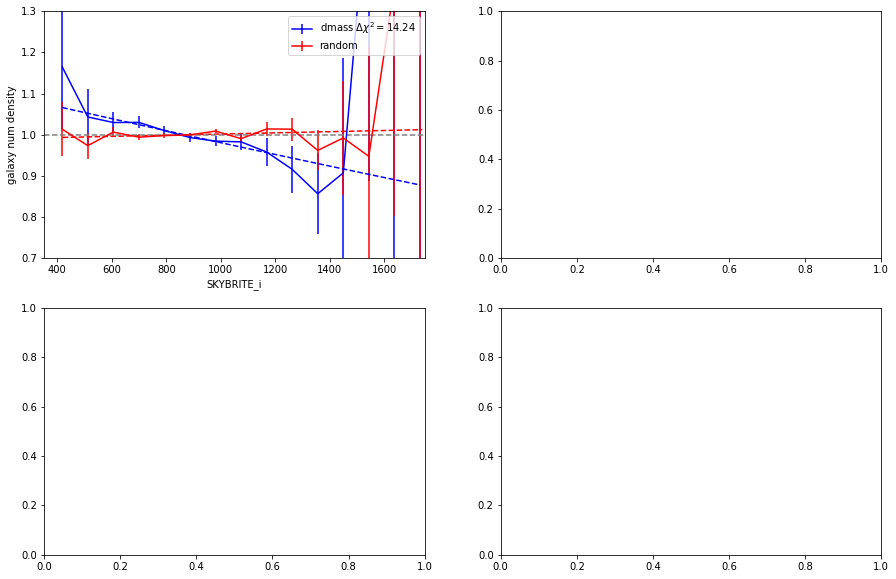

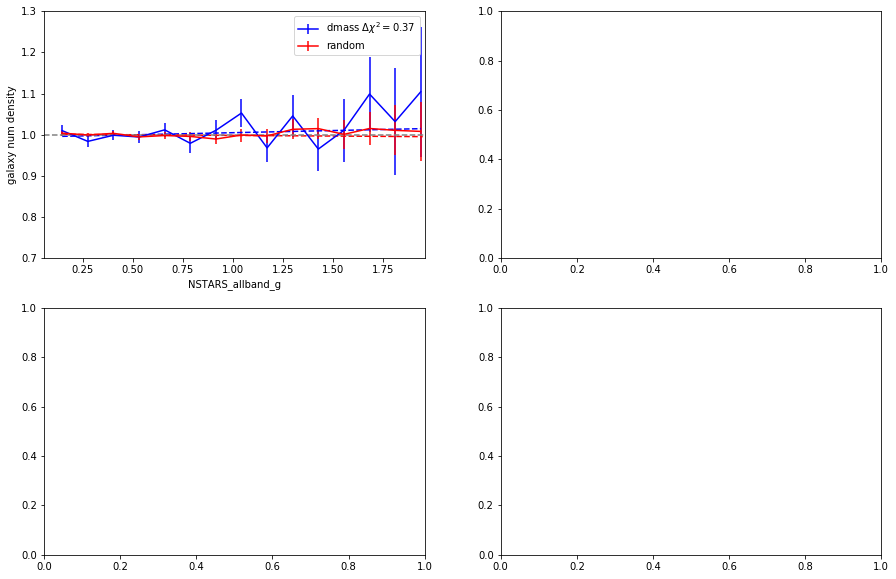

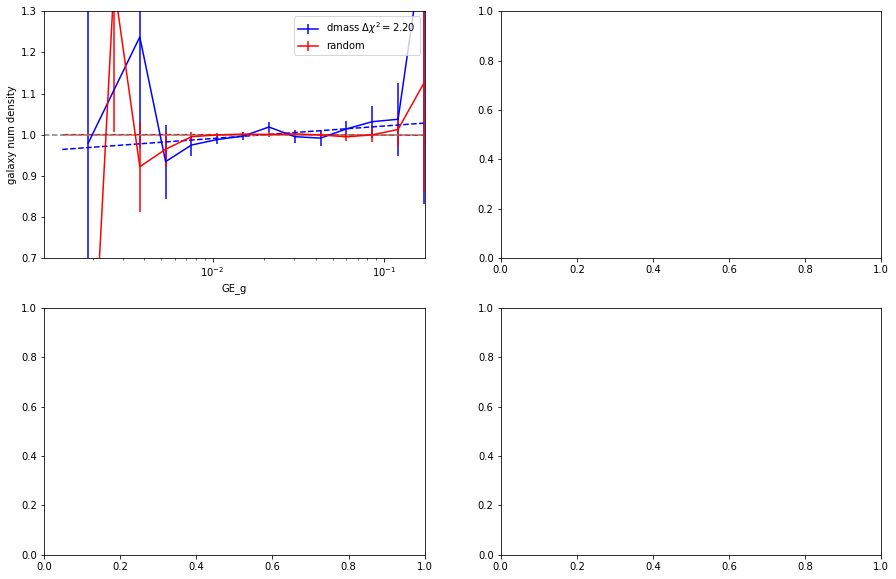

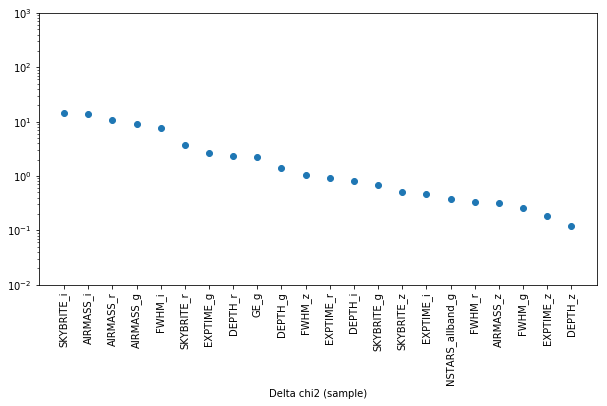

In [63]:
nextweight = 'AIRMASS_z'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['noweight', 'AIRMASS_z', 'GE_g', 'FWHM_r']
noweight
AIRMASS_z
GE_g
FWHM_r
----------------------------------
initialize function  SKYBRITE_i
linear
store weight  SKYBRITE_i
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_skybrite_i_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_r_SPT_wg_ge_g_fwhm_r_ai

(['SKYBRITE_r',
  'FWHM_i',
  'AIRMASS_i',
  'AIRMASS_g',
  'SKYBRITE_z',
  'AIRMASS_r',
  'DEPTH_r',
  'EXPTIME_g',
  'GE_g',
  'FWHM_g',
  'DEPTH_g',
  'EXPTIME_r',
  'FWHM_z',
  'AIRMASS_z',
  'EXPTIME_z',
  'DEPTH_i',
  'EXPTIME_i',
  'SKYBRITE_g',
  'NSTARS_allband_g',
  'SKYBRITE_i',
  'FWHM_r',
  'DEPTH_z'],
 [7.8737022512314185,
  3.912255518883393,
  3.5905548137017593,
  3.588933868574345,
  2.9718866700159836,
  2.6644637353216662,
  2.2422336443960402,
  1.5685705434012585,
  1.131413989562378,
  1.0066693291670727,
  0.9904143386416608,
  0.5194830066453058,
  0.4902268225026436,
  0.4697662444205859,
  0.38353143709345616,
  0.23770414410328833,
  0.2335645347309807,
  0.10783558662616599,
  0.07330662901754259,
  0.020663398931145327,
  0.017790373371044055,
  0.009071246537045496])

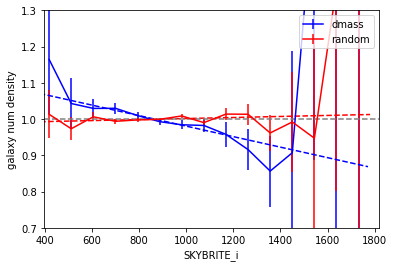

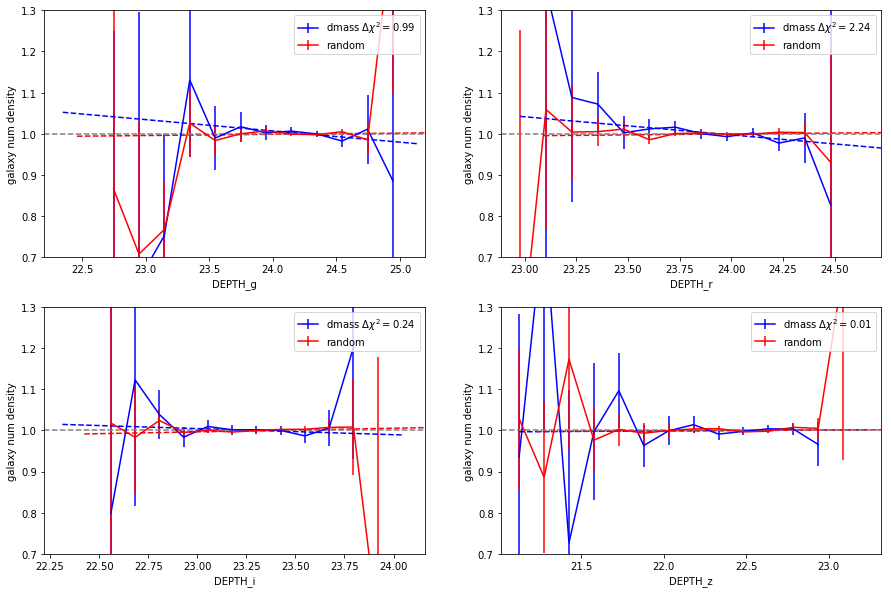

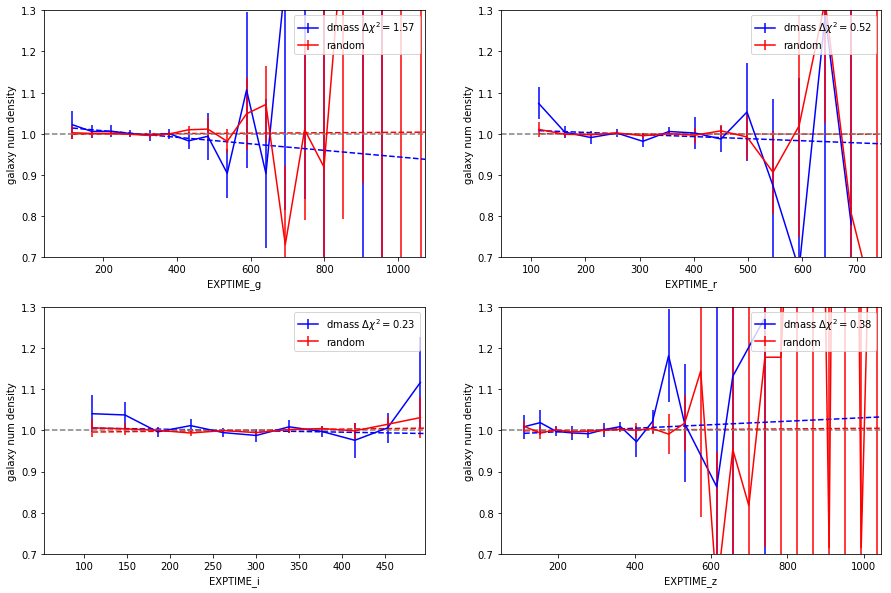

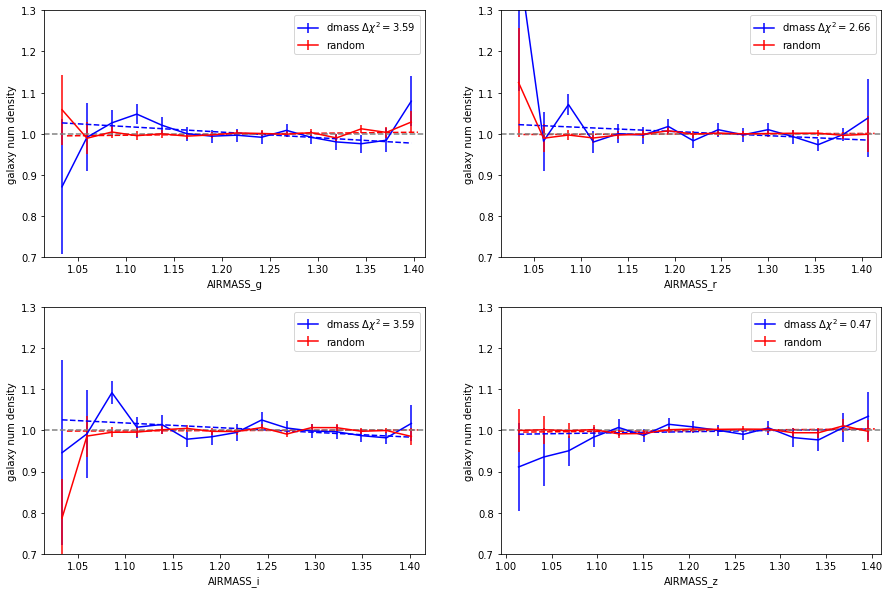

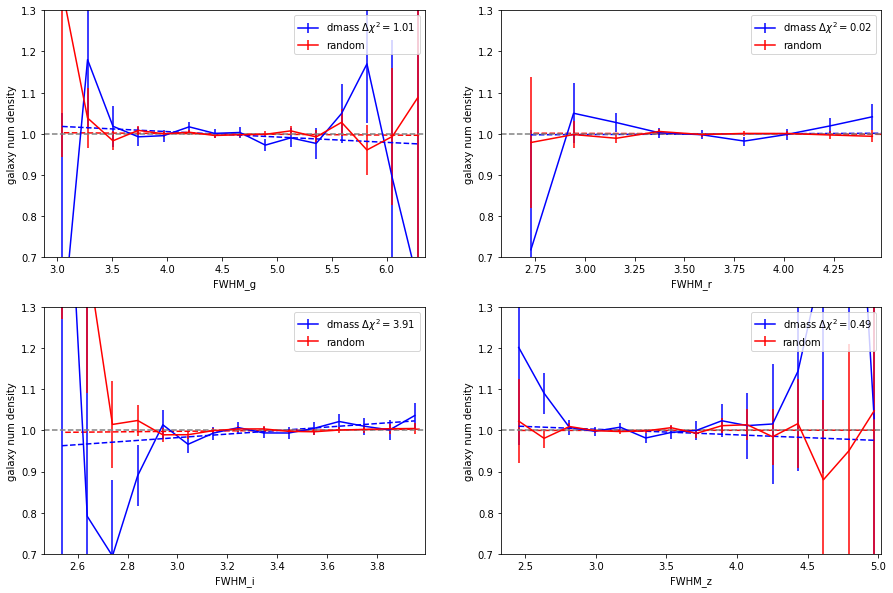

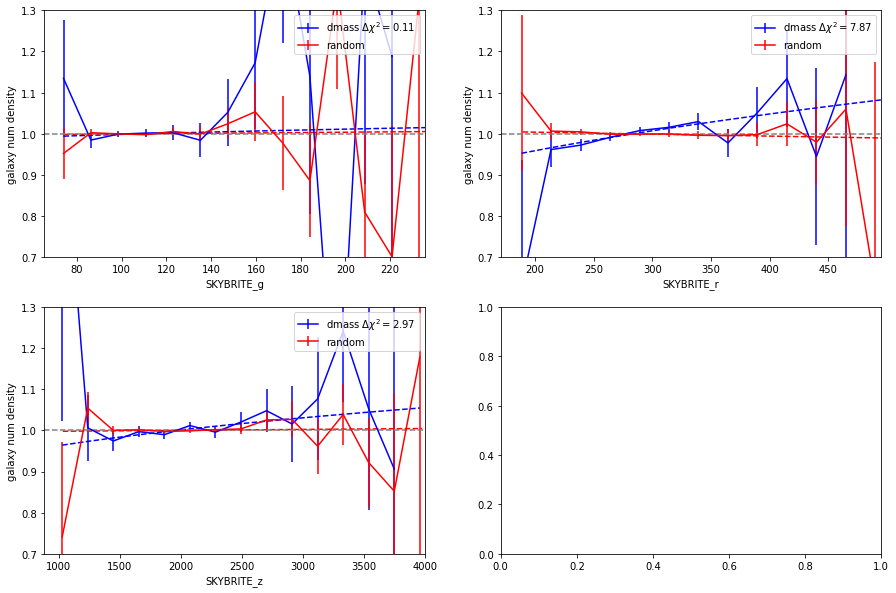

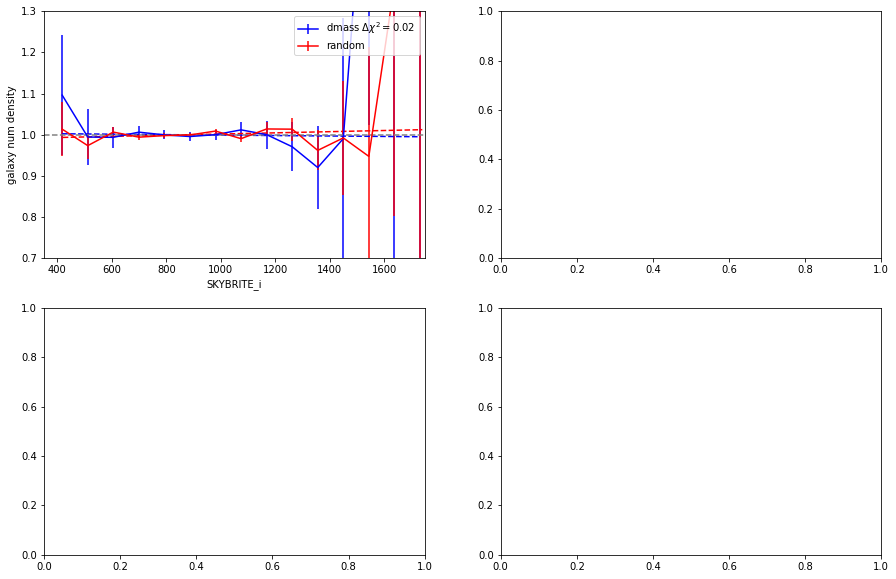

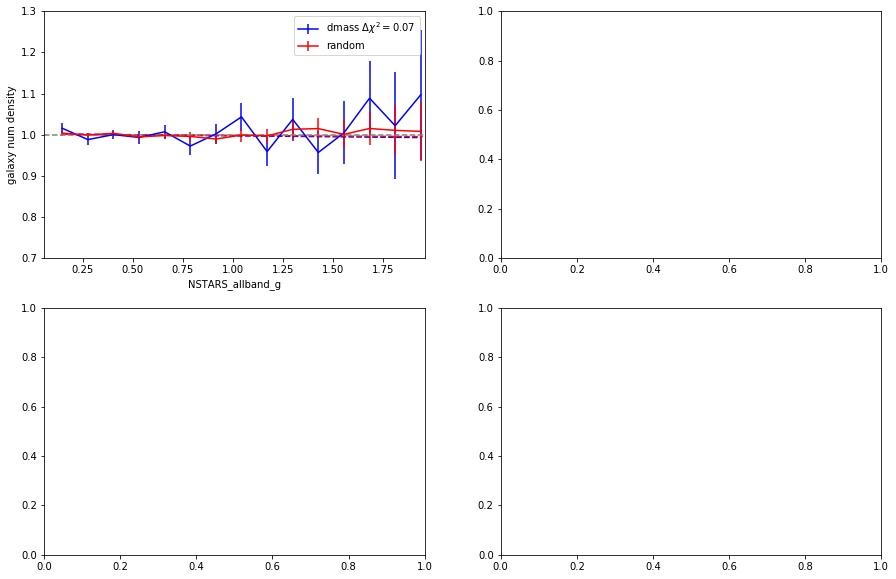

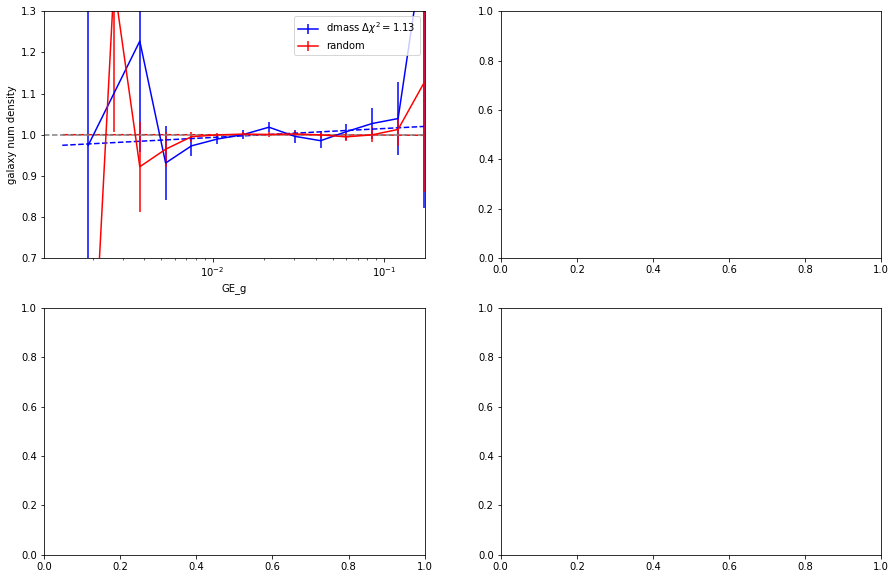

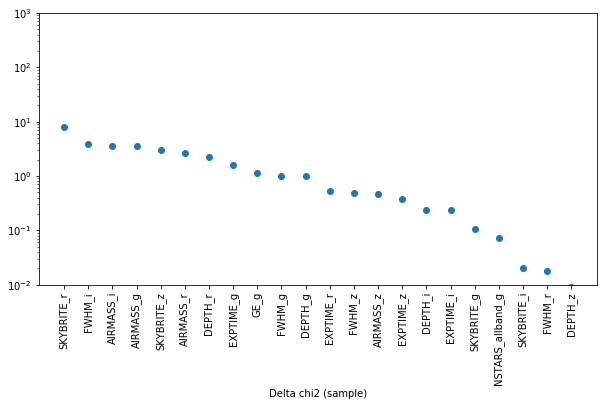

In [65]:
nextweight = 'SKYBRITE_i'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )


suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['noweight', 'AIRMASS_z', 'SKYBRITE_i', 'GE_g', 'FWHM_r']
noweight
AIRMASS_z
SKYBRITE_i
GE_g
FWHM_r
----------------------------------
initialize function  SKYBRITE_r
linear
store weight  SKYBRITE_r
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_skybrite_r_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt
saving

chi2_null =  7.342073048663915
chi2_mod. =  6.37272803120434
Delta chi2 (sample) = 0.9693450174595748
output save to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r.txt.model

[3.7047709322593807, 3.4598303522899183, 3.419781315245311, 3.1824998355527274, 1.6916223655377856, 1.648829213318744, 1.0418000839131167, 0.9693450174595748, 0.7640574654055108, 0.7592571938161683, 0.620261450495625, 0.5357727031113795, 0.28127896140463626, 0.2721838263926406, 0.22346149428401763, 0.21718457779754274, 0.16193857639876974, 0.12984715579222383, 0.09553049434567917, 0.0342812833380175, 0.03100786810731293, 0.015436922889901616]


(['FWHM_i',
  'AIRMASS_i',
  'AIRMASS_r',
  'AIRMASS_g',
  'FWHM_g',
  'SKYBRITE_z',
  'EXPTIME_g',
  'GE_g',
  'EXPTIME_z',
  'FWHM_z',
  'SKYBRITE_i',
  'AIRMASS_z',
  'FWHM_r',
  'DEPTH_g',
  'DEPTH_z',
  'SKYBRITE_g',
  'EXPTIME_r',
  'DEPTH_r',
  'NSTARS_allband_g',
  'DEPTH_i',
  'SKYBRITE_r',
  'EXPTIME_i'],
 [3.7047709322593807,
  3.4598303522899183,
  3.419781315245311,
  3.1824998355527274,
  1.6916223655377856,
  1.648829213318744,
  1.0418000839131167,
  0.9693450174595748,
  0.7640574654055108,
  0.7592571938161683,
  0.620261450495625,
  0.5357727031113795,
  0.28127896140463626,
  0.2721838263926406,
  0.22346149428401763,
  0.21718457779754274,
  0.16193857639876974,
  0.12984715579222383,
  0.09553049434567917,
  0.0342812833380175,
  0.03100786810731293,
  0.015436922889901616])

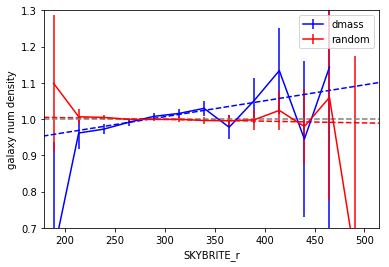

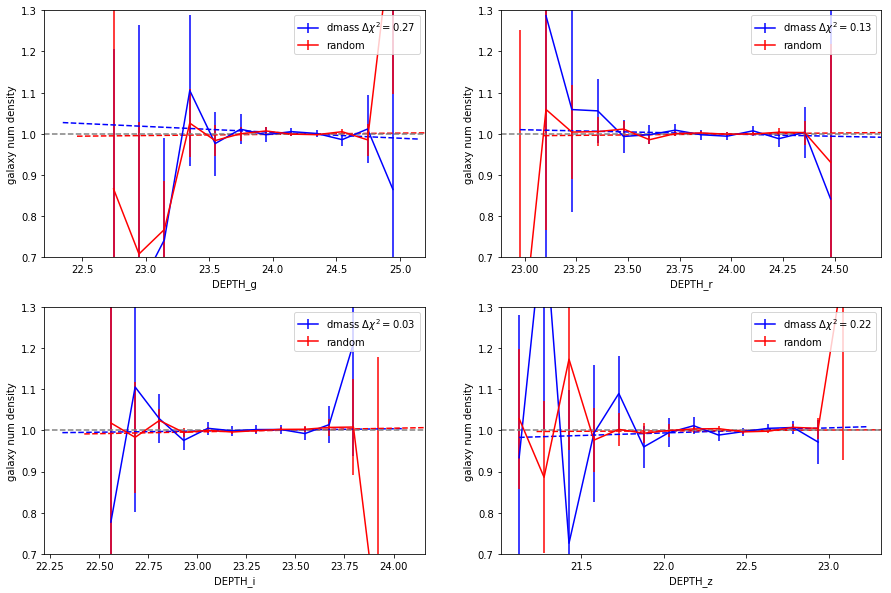

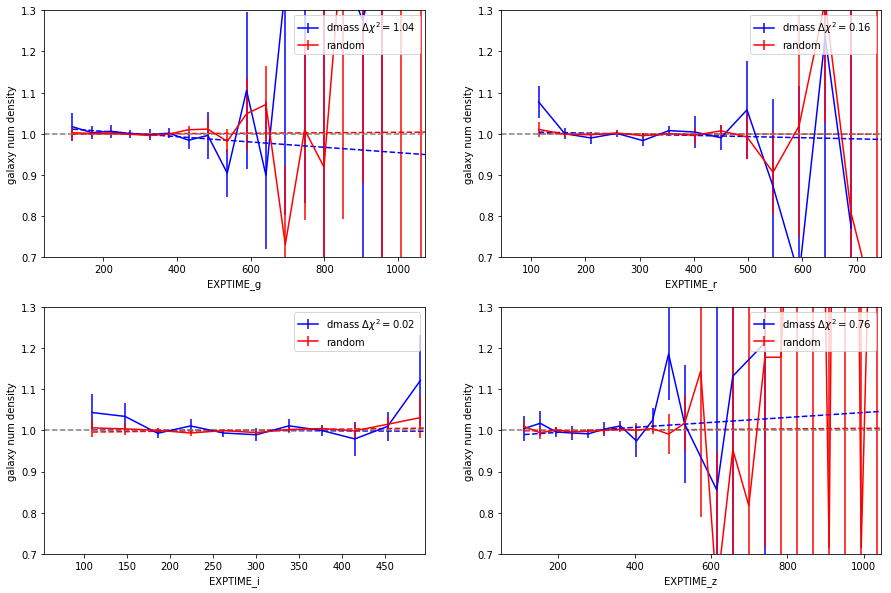

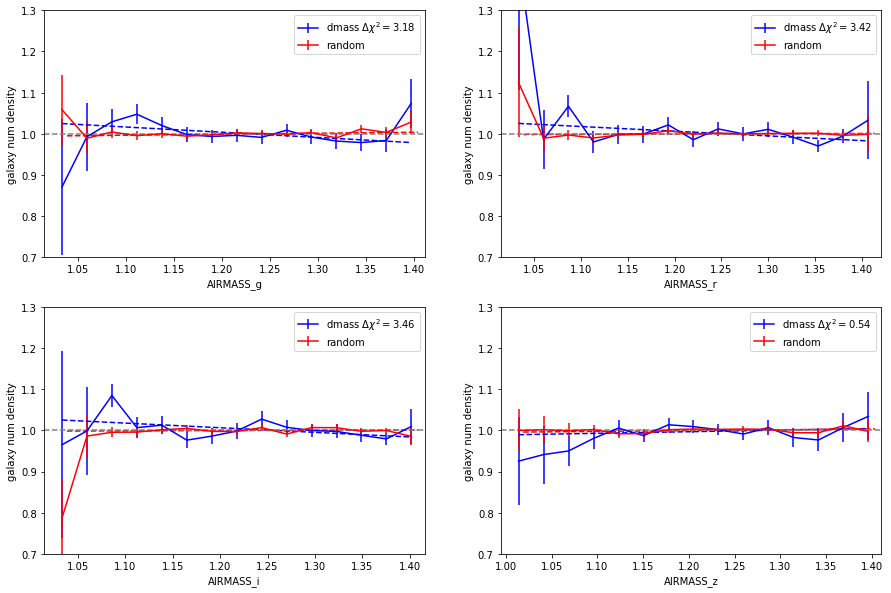

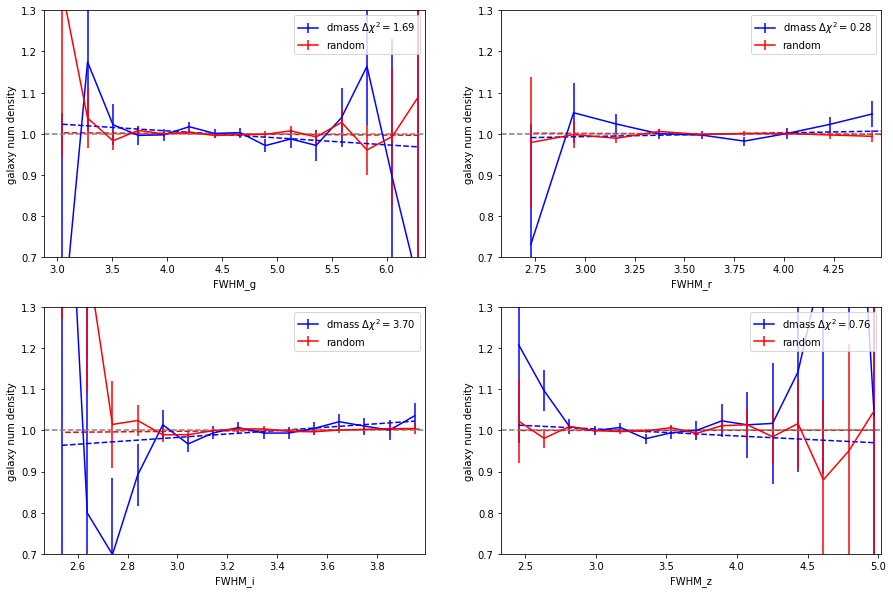

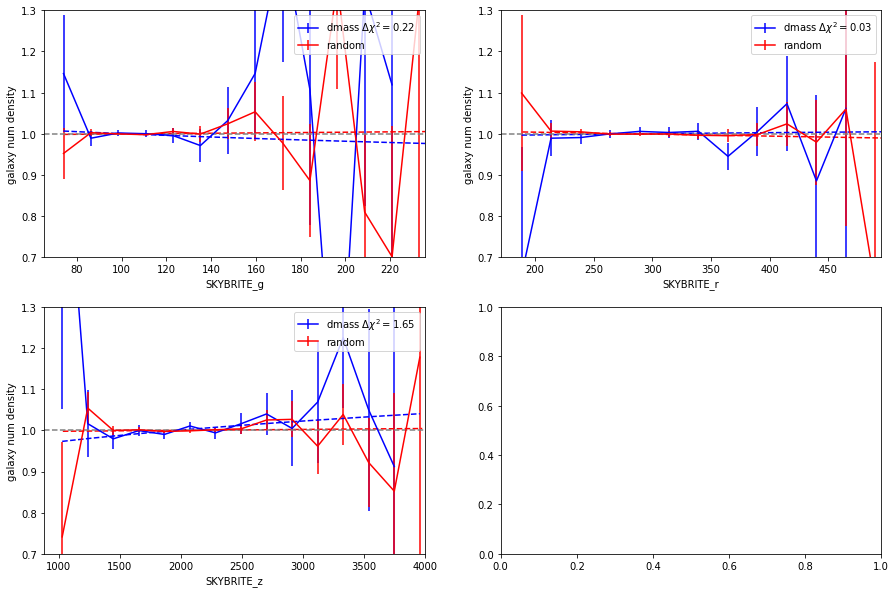

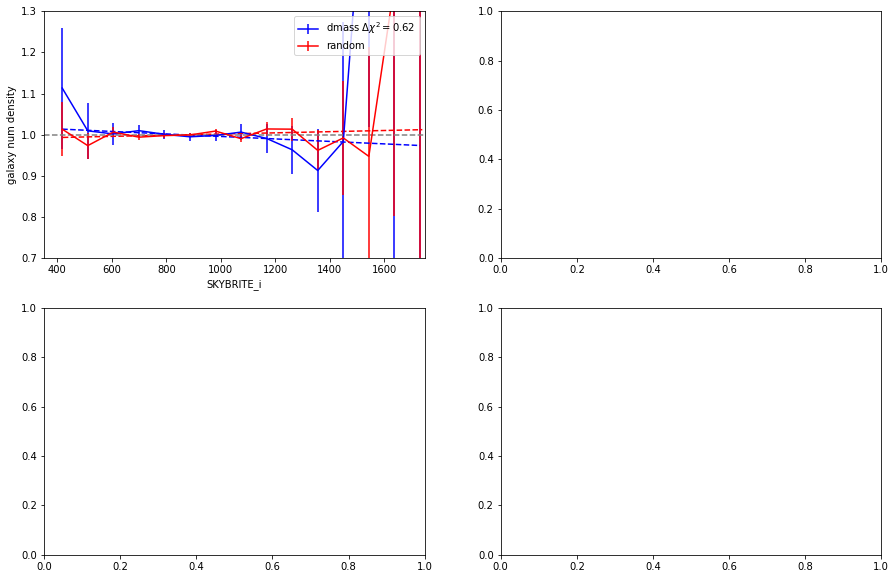

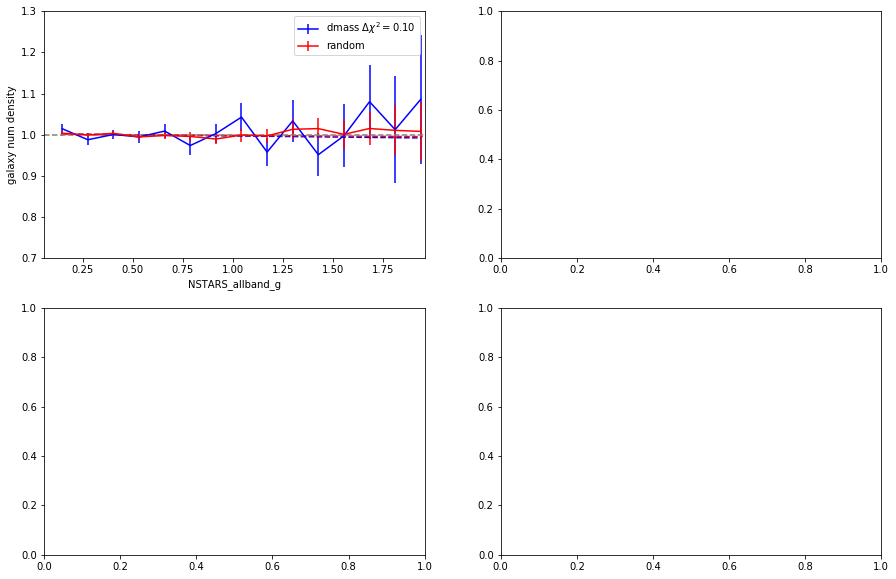

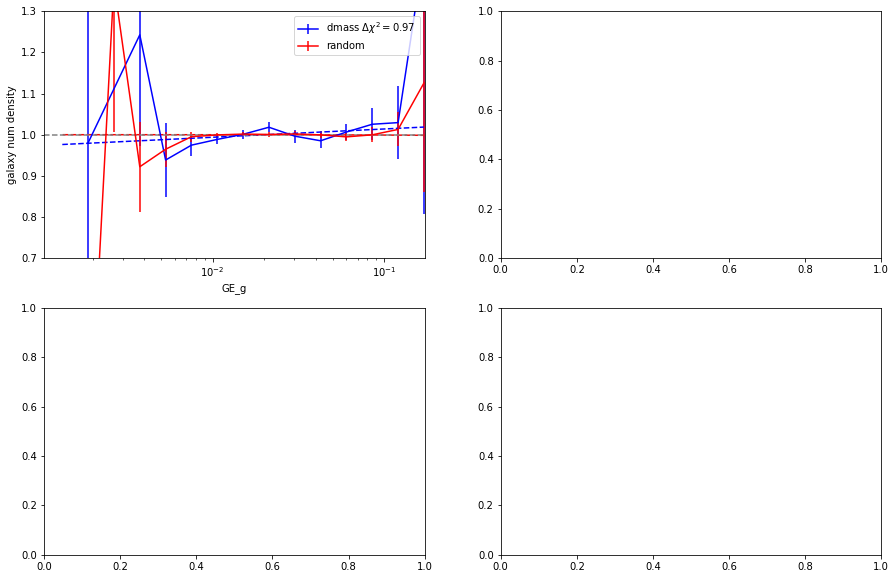

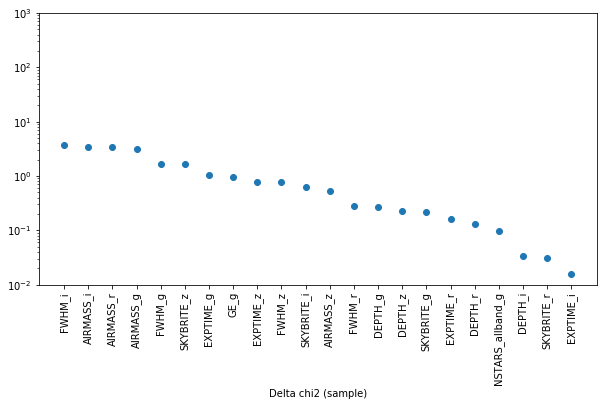

In [66]:
nextweight = 'SKYBRITE_r'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'FWHM_r', 'AIRMASS_z', 'GE_g', 'noweight', 'SKYBRITE_i']
SKYBRITE_r
FWHM_r
AIRMASS_z
GE_g
noweight
SKYBRITE_i
----------------------------------
initialize function  FWHM_i
linear
store weight  FWHM_i
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_fwhm_i_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_g_SPT_wg_ge_g_f

chi2_null =  9.353250516554759
chi2_mod. =  9.269625480555698
Delta chi2 (sample) = 0.08362503599906113
output save to  ../data_txt/systematics/6th_include_ge/systematic_NSTARS_allband_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt.model

chi2_null =  8.10363501868554
chi2_mod. =  7.223895448398543
Delta chi2 (sample) = 0.8797395702869979
output save to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i.txt.model

[2.5254123629523786, 2.5011103799919834, 2.2211869839012586, 1.9706409967568401, 1.7779535049574537, 1.069287778898687, 1.046516061551789, 0.8797395702869979, 0.7344768866093032, 0.5716358918710256, 0.31934269616778144, 0.2029282020505363, 0.19951811857576196, 0.17317691627759757, 0.1708763902091852, 0.14961854171075561, 0.08362503599906113, 0.02520527602261513, 0.021291558814692912, 0.015099976580199126, 0.0028762249062039835, 0.0022790341493710287]


(['AIRMASS_r',
  'AIRMASS_g',
  'FWHM_g',
  'AIRMASS_i',
  'SKYBRITE_z',
  'FWHM_z',
  'EXPTIME_g',
  'GE_g',
  'EXPTIME_z',
  'AIRMASS_z',
  'DEPTH_g',
  'EXPTIME_r',
  'DEPTH_z',
  'SKYBRITE_g',
  'DEPTH_r',
  'SKYBRITE_i',
  'NSTARS_allband_g',
  'EXPTIME_i',
  'SKYBRITE_r',
  'FWHM_r',
  'DEPTH_i',
  'FWHM_i'],
 [2.5254123629523786,
  2.5011103799919834,
  2.2211869839012586,
  1.9706409967568401,
  1.7779535049574537,
  1.069287778898687,
  1.046516061551789,
  0.8797395702869979,
  0.7344768866093032,
  0.5716358918710256,
  0.31934269616778144,
  0.2029282020505363,
  0.19951811857576196,
  0.17317691627759757,
  0.1708763902091852,
  0.14961854171075561,
  0.08362503599906113,
  0.02520527602261513,
  0.021291558814692912,
  0.015099976580199126,
  0.0028762249062039835,
  0.0022790341493710287])

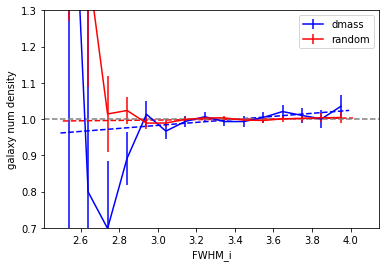

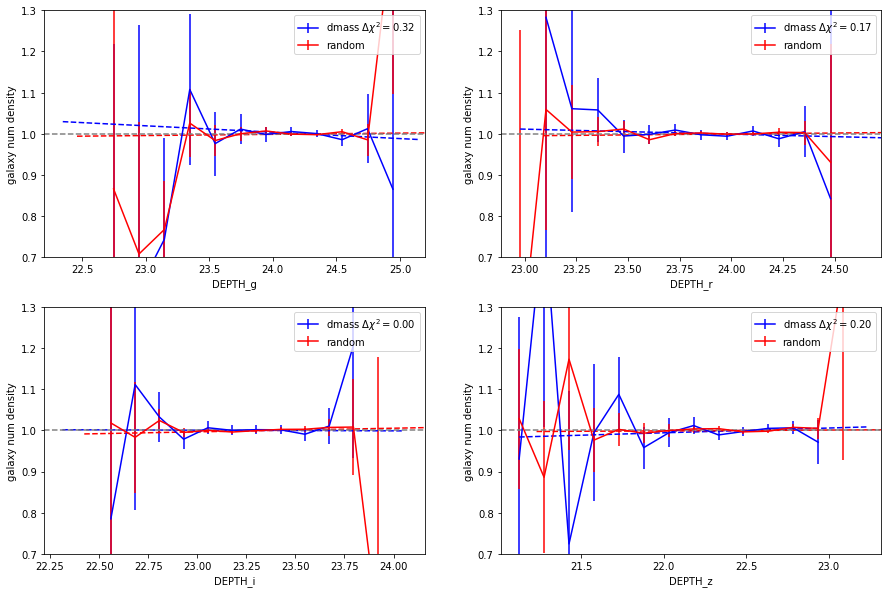

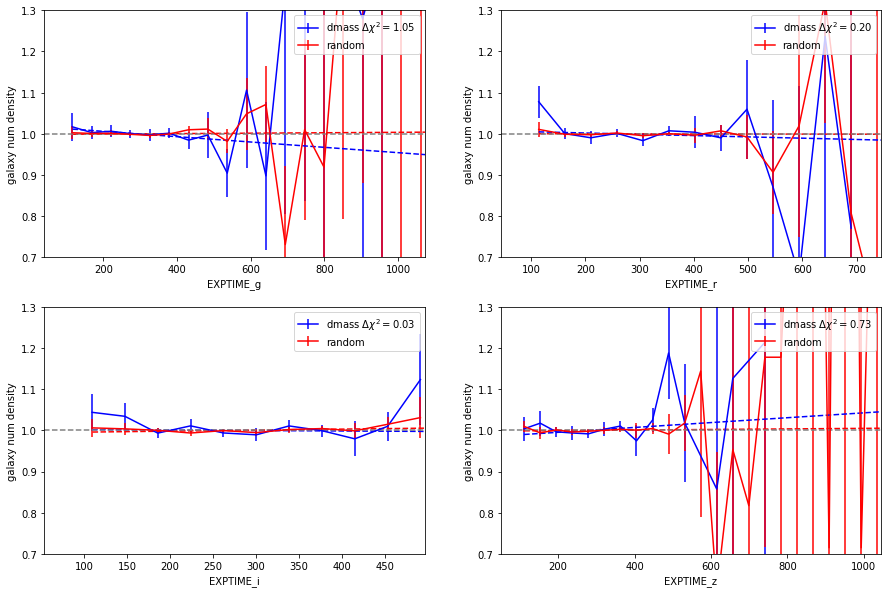

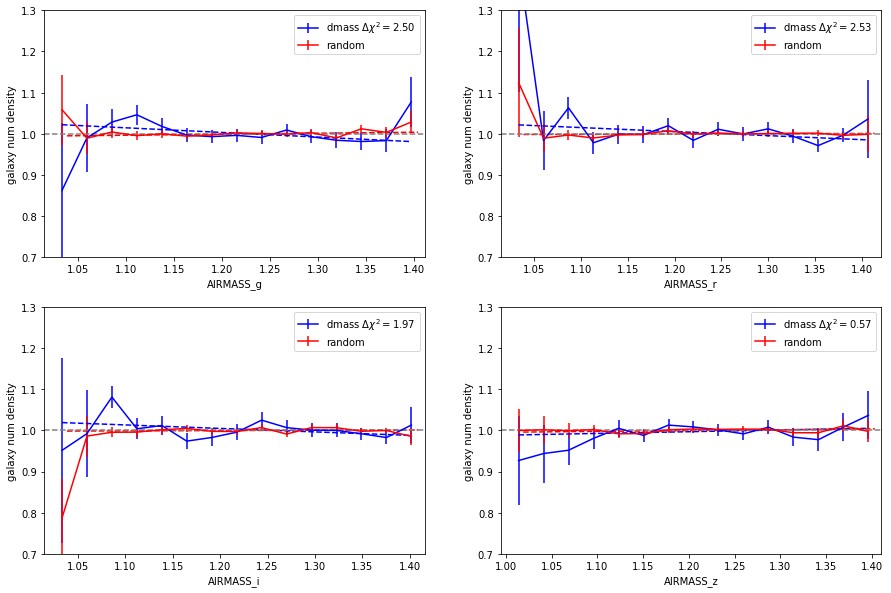

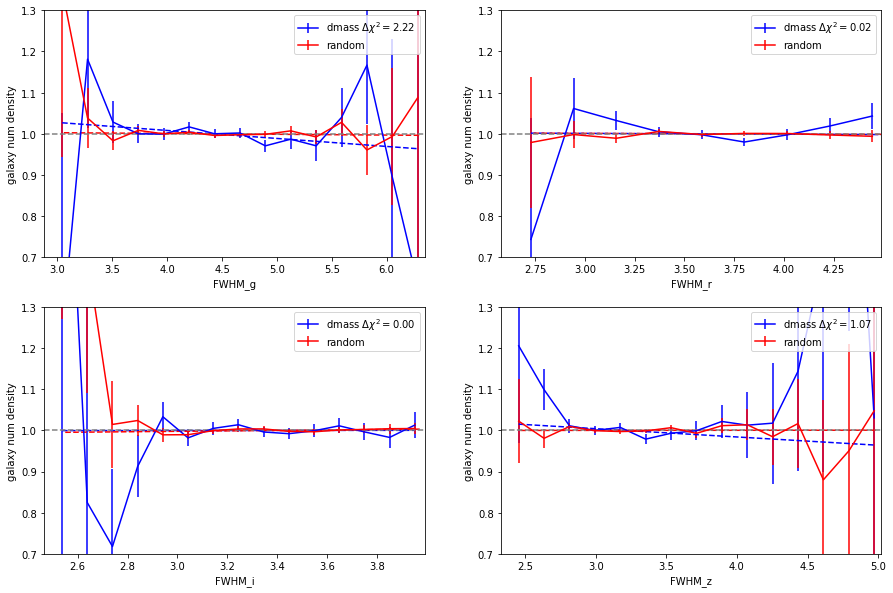

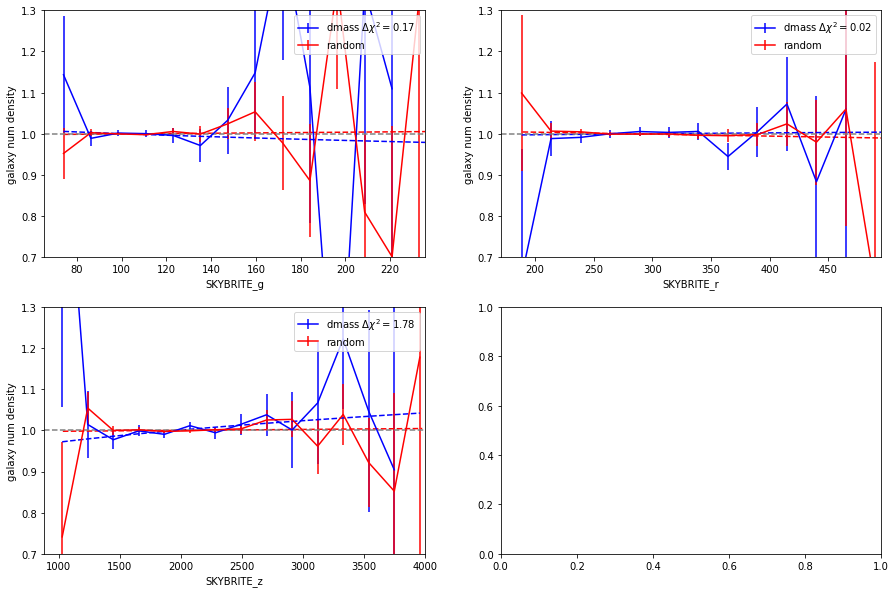

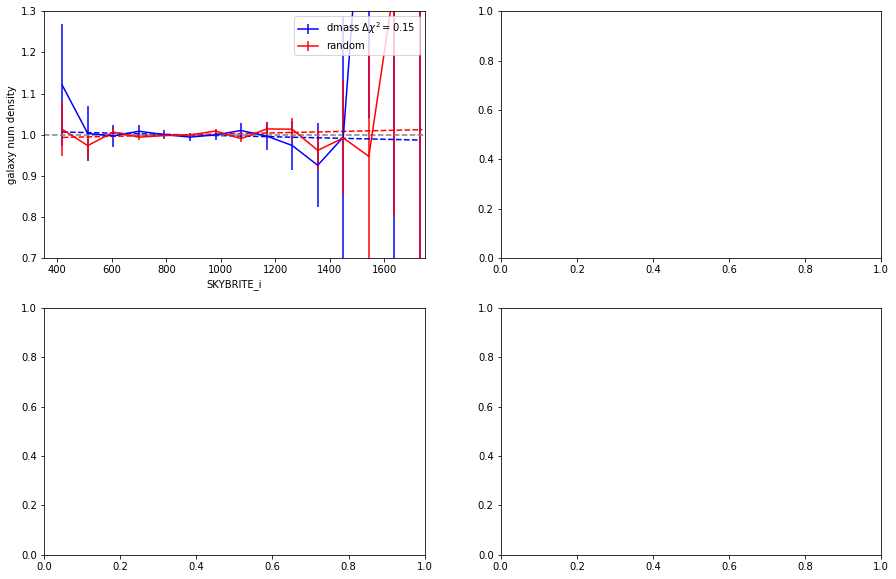

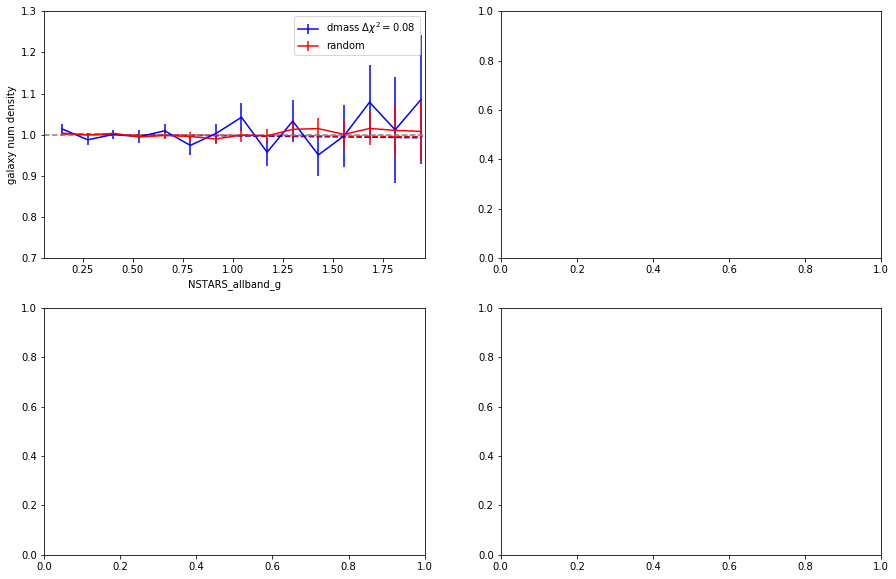

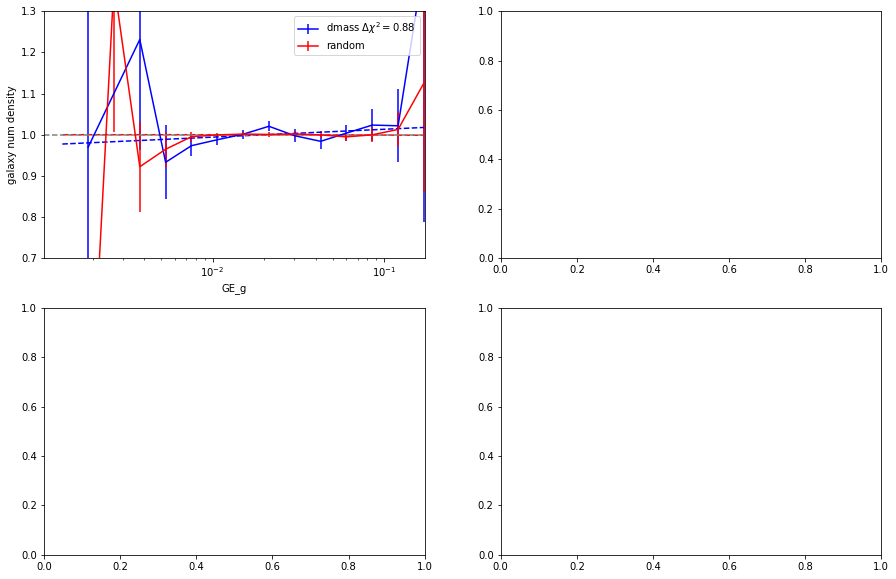

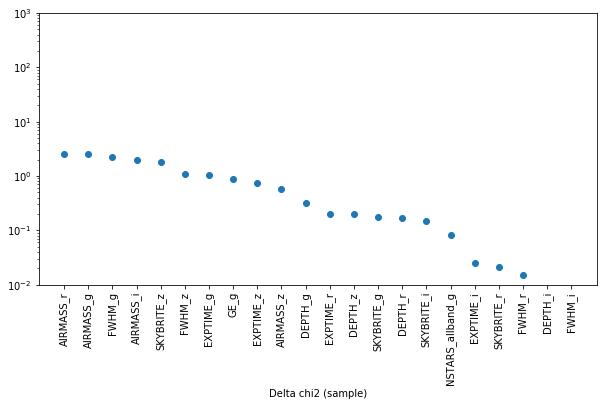

In [67]:
nextweight = 'FWHM_i'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'FWHM_r', 'AIRMASS_z', 'GE_g', 'noweight', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
FWHM_r
AIRMASS_z
GE_g
noweight
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  AIRMASS_r
linear
store weight  AIRMASS_r
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_airmass_r_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt
saving data t

chi2_null =  3.914007737559943
chi2_mod. =  3.913604123549513
Delta chi2 (sample) = 0.0004036140104299868
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt.model

chi2_null =  9.754998336232216
chi2_mod. =  9.09842026552858
Delta chi2 (sample) = 0.6565780707036364
output save to  ../data_txt/systematics/6th_include_ge/systematic_NSTARS_allband_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt.model

chi2_null =  8.7953493318096
chi2_mod. =  8.465315969011712
Delta chi2 (sample) = 0.330033362797888
output save to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r.txt.model

[3.159251787742005, 3.0297993230542755, 1.2415650931006903, 1.0081870721933015, 0.7128929782075835, 0.6565780707036364, 0.6560804319067124, 0.33790847689461945, 0.330033362797888, 0.18306006141975972, 0.12864571751037346, 0.

(['SKYBRITE_z',
  'FWHM_g',
  'AIRMASS_z',
  'EXPTIME_z',
  'EXPTIME_g',
  'NSTARS_allband_g',
  'FWHM_z',
  'AIRMASS_g',
  'GE_g',
  'DEPTH_g',
  'DEPTH_z',
  'FWHM_r',
  'EXPTIME_r',
  'SKYBRITE_r',
  'DEPTH_r',
  'AIRMASS_i',
  'FWHM_i',
  'DEPTH_i',
  'SKYBRITE_g',
  'AIRMASS_r',
  'EXPTIME_i',
  'SKYBRITE_i'],
 [3.159251787742005,
  3.0297993230542755,
  1.2415650931006903,
  1.0081870721933015,
  0.7128929782075835,
  0.6565780707036364,
  0.6560804319067124,
  0.33790847689461945,
  0.330033362797888,
  0.18306006141975972,
  0.12864571751037346,
  0.12117351473450633,
  0.08727248835525625,
  0.07289549930348471,
  0.06933738609489559,
  0.04373360746191146,
  0.03770813423116692,
  0.029370947822719096,
  0.01160295867087413,
  0.0044735430115849795,
  0.0012019350898793135,
  0.0004036140104299868])

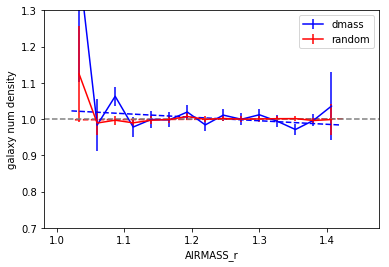

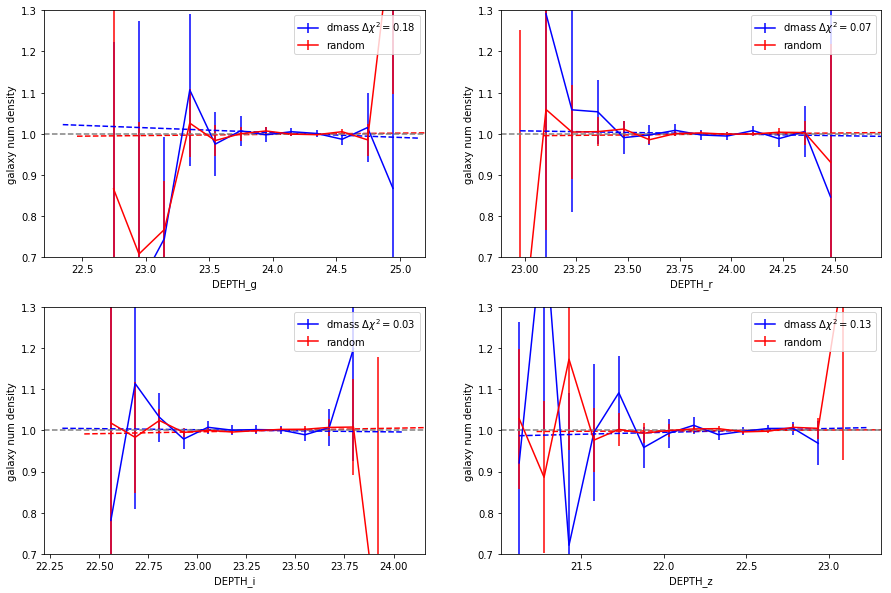

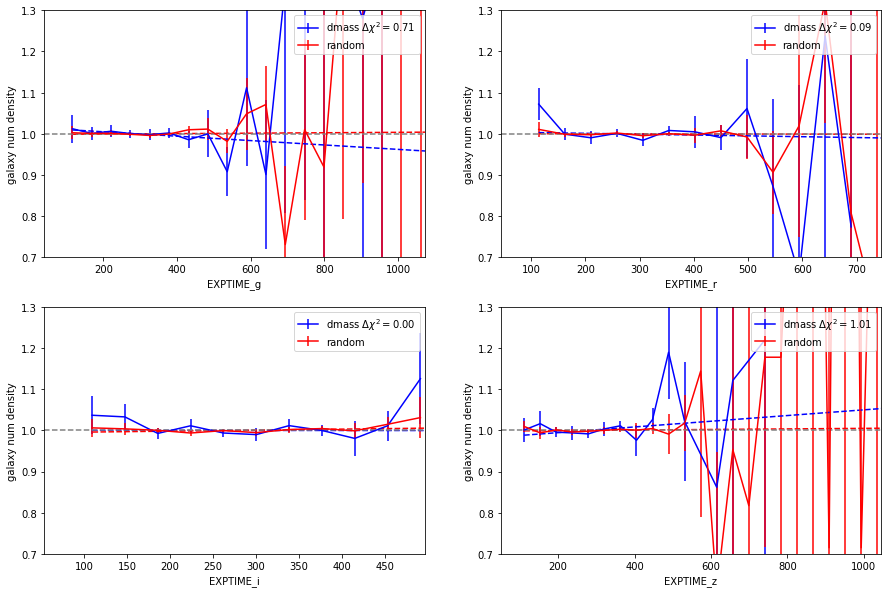

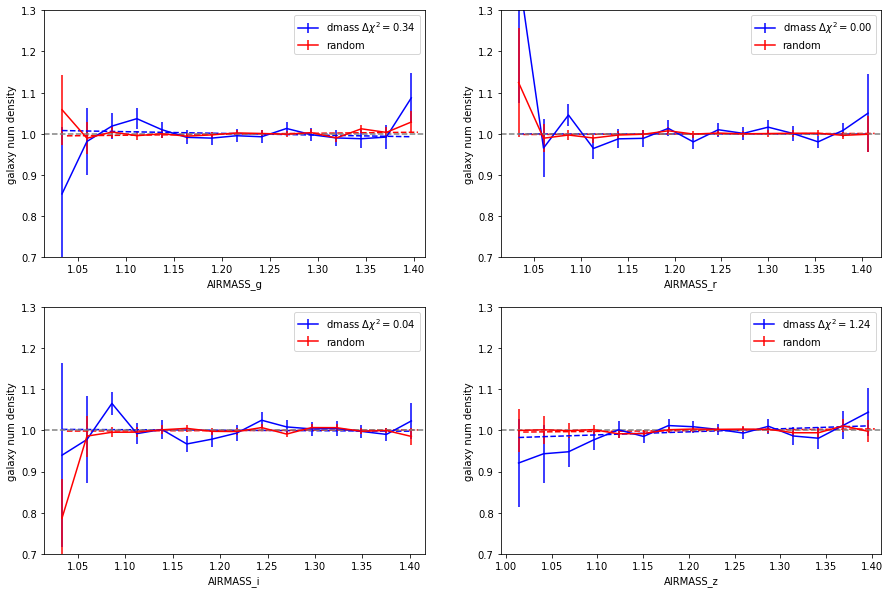

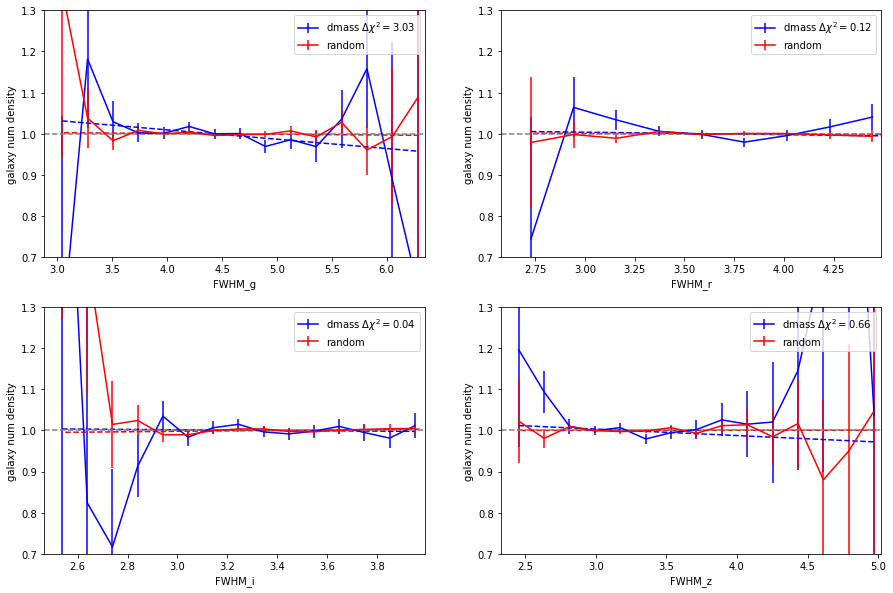

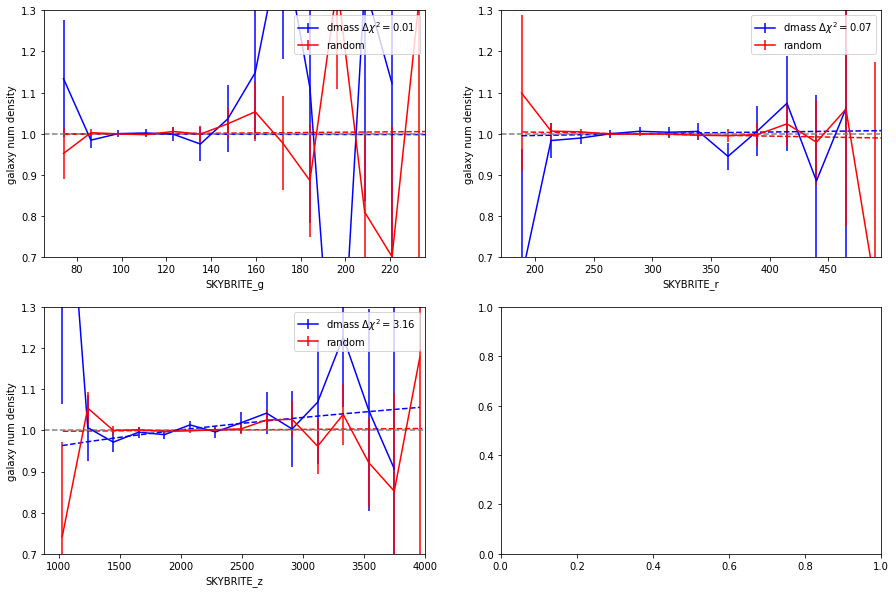

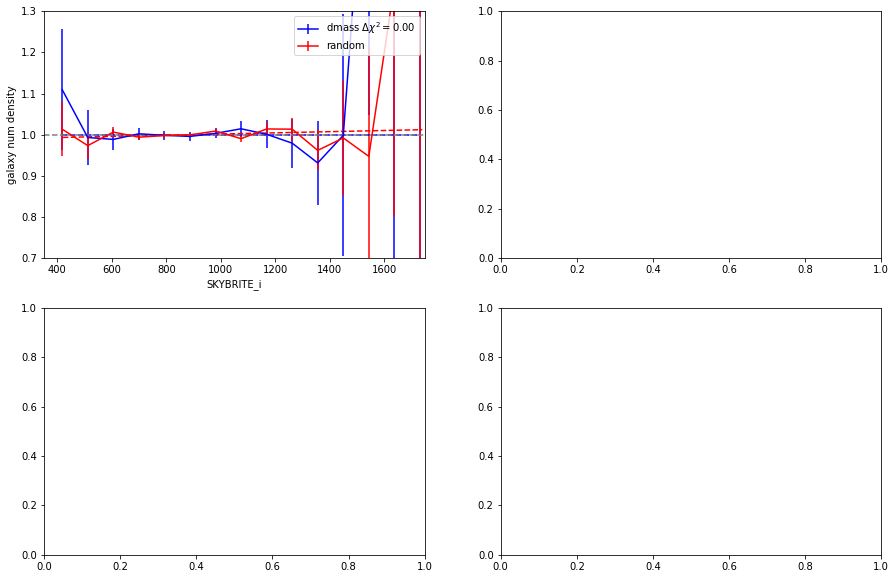

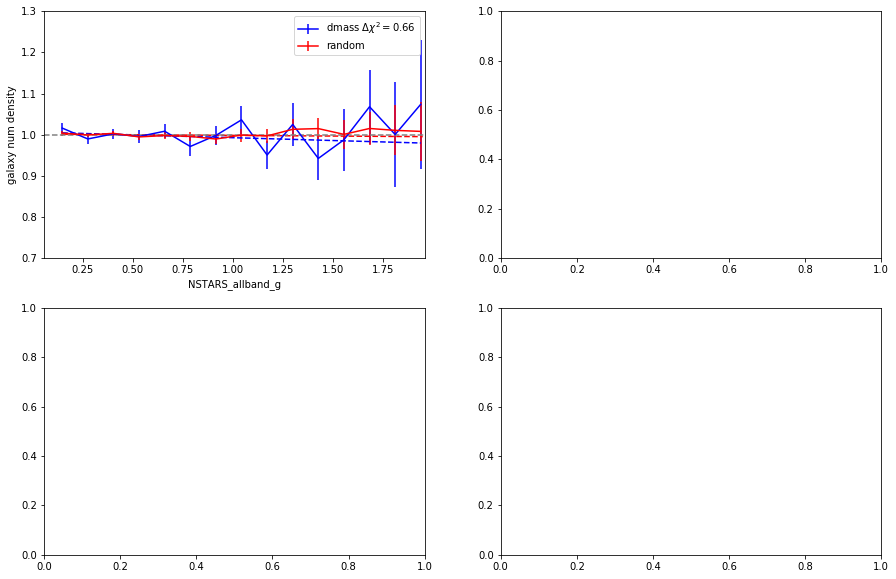

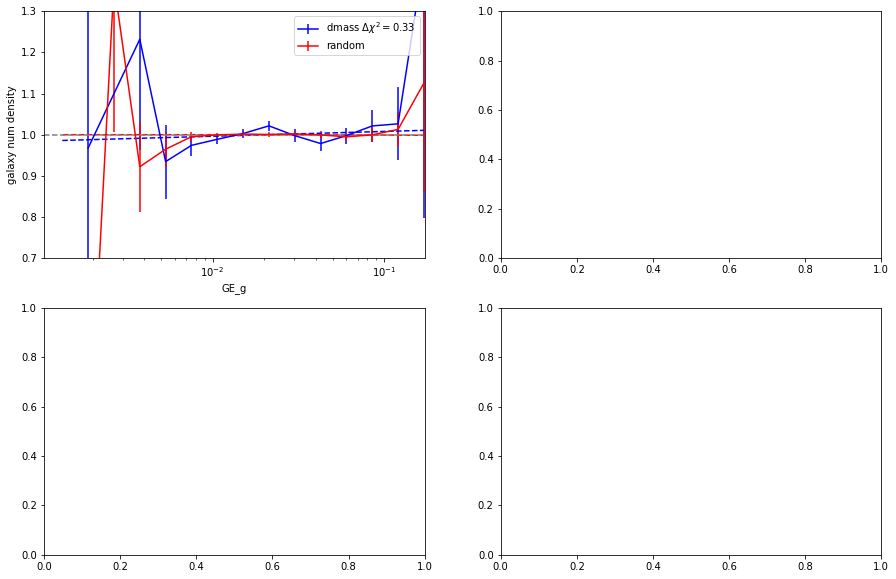

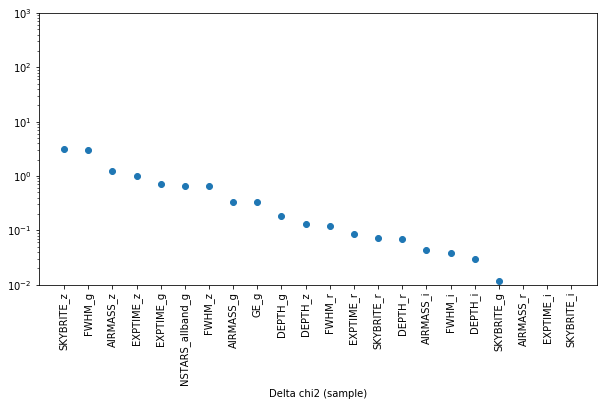

In [68]:
nextweight = 'AIRMASS_r'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'AIRMASS_r', 'FWHM_r', 'AIRMASS_z', 'GE_g', 'noweight', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
AIRMASS_r
FWHM_r
AIRMASS_z
GE_g
noweight
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  SKYBRITE_z
linear
store weight  SKYBRITE_z
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_skybrite_z_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwh

chi2_null =  20.391902684973974
chi2_mod. =  20.279804242109655
Delta chi2 (sample) = 0.11209844286431903
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt.model

chi2_null =  5.433483576337229
chi2_mod. =  5.4319714404599715
Delta chi2 (sample) = 0.0015121358772578475
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt.model

chi2_null =  5.779483713704543
chi2_mod. =  5.774082395393131
Delta chi2 (sample) = 0.005401318311412773
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z.txt.model

chi2_null =  3.857789145011542
chi2_mod. =  3.826290261544058
Delta chi2 (sample) = 0.03149888346748364
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_i_

(['FWHM_g',
  'DEPTH_z',
  'EXPTIME_z',
  'GE_g',
  'AIRMASS_g',
  'EXPTIME_g',
  'FWHM_z',
  'AIRMASS_z',
  'AIRMASS_i',
  'AIRMASS_r',
  'DEPTH_g',
  'NSTARS_allband_g',
  'SKYBRITE_g',
  'EXPTIME_r',
  'FWHM_r',
  'SKYBRITE_i',
  'FWHM_i',
  'DEPTH_i',
  'DEPTH_r',
  'EXPTIME_i',
  'SKYBRITE_z',
  'SKYBRITE_r'],
 [2.7901853624841344,
  1.3125078298310315,
  1.2429909868747382,
  0.8583997544486017,
  0.8384185101367247,
  0.7278251685497397,
  0.5606318925832117,
  0.5233974328281548,
  0.4698195885402736,
  0.24805128055693437,
  0.15490027999674938,
  0.1375668616561132,
  0.11209844286431903,
  0.04743978217797551,
  0.040627055569823156,
  0.03149888346748364,
  0.027764225128393605,
  0.016009314336027813,
  0.01531999091598335,
  0.01068210493196009,
  0.005401318311412773,
  0.0015121358772578475])

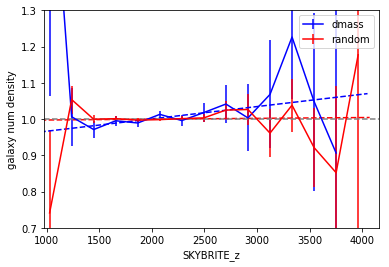

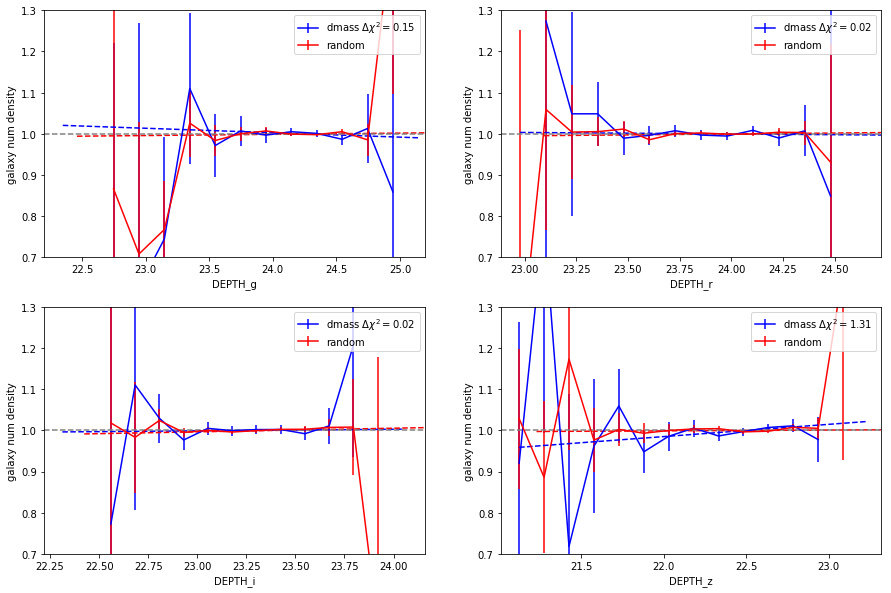

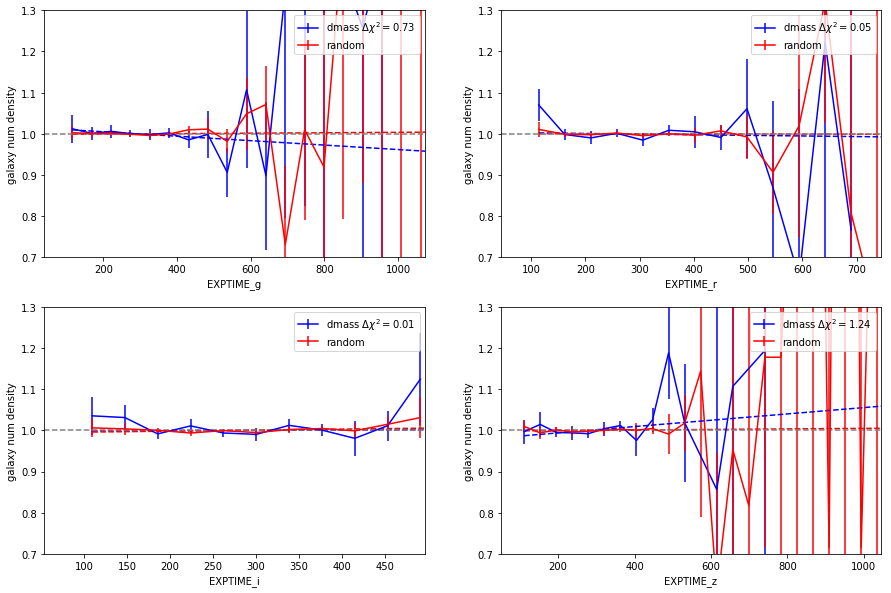

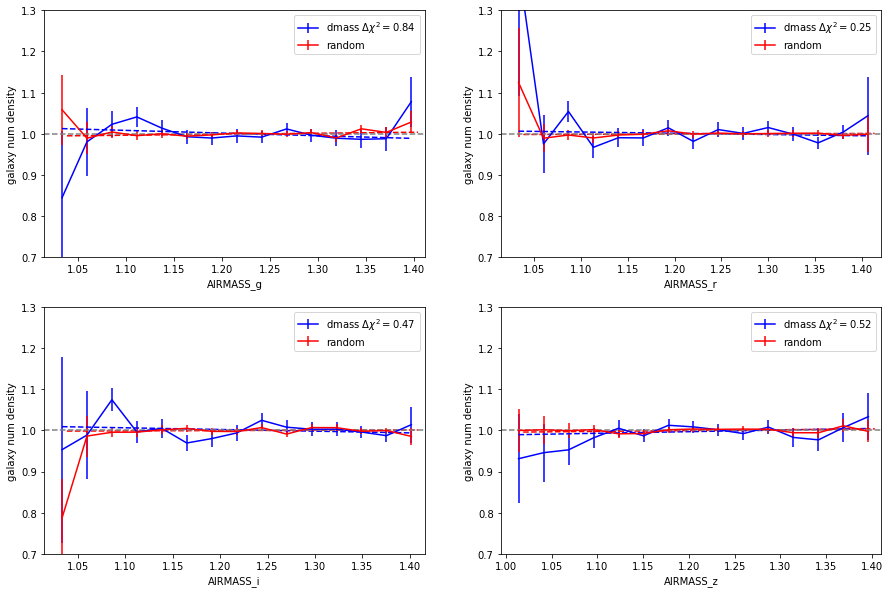

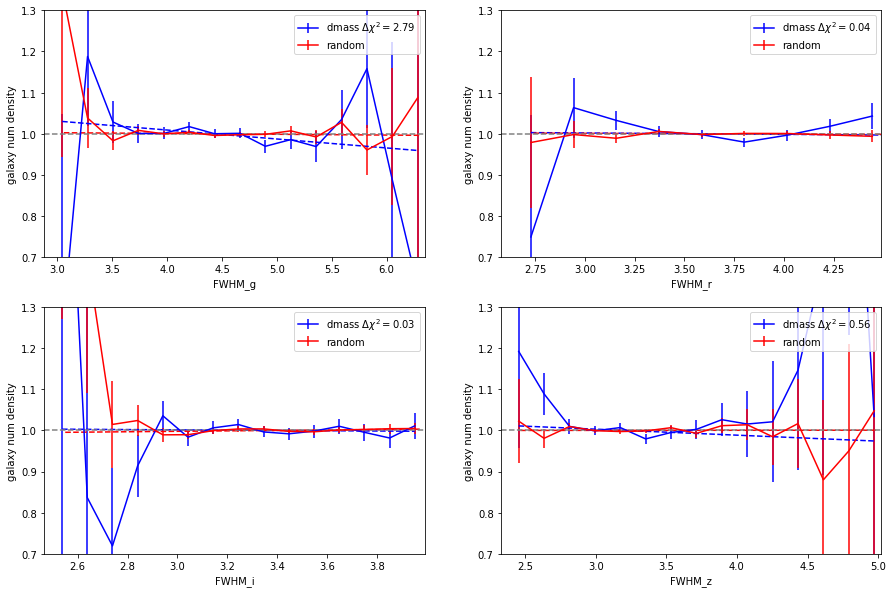

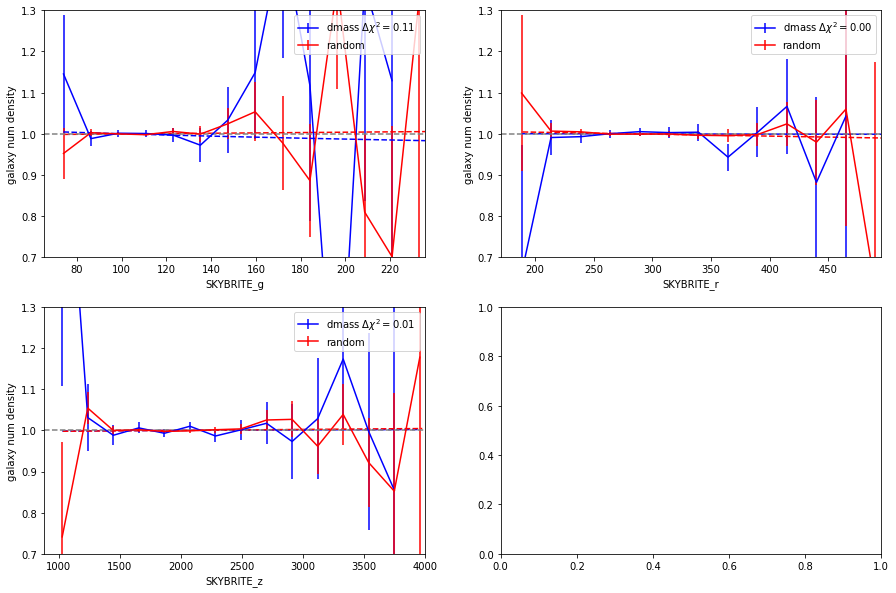

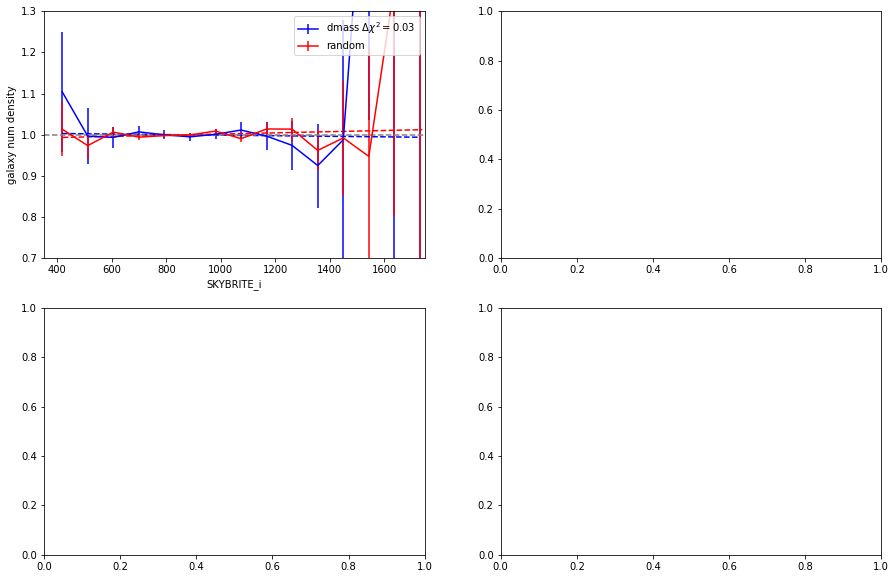

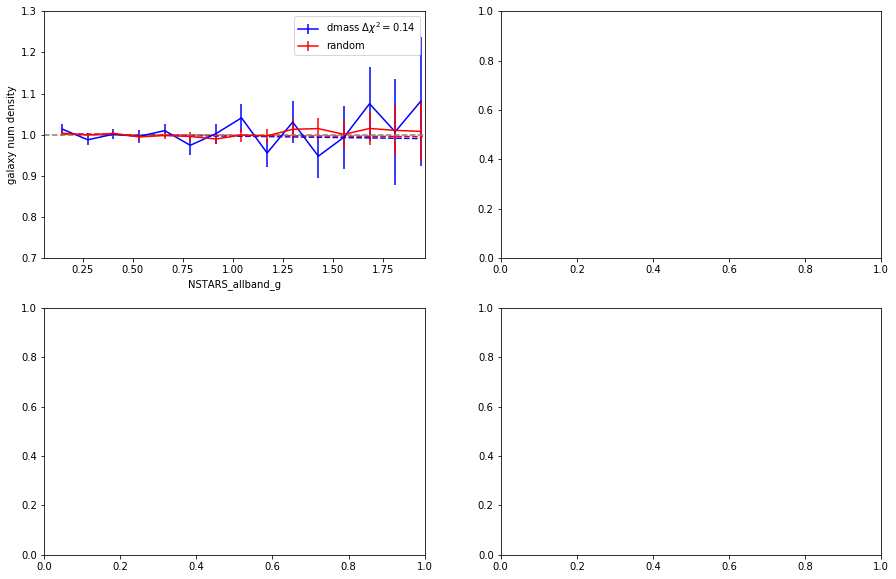

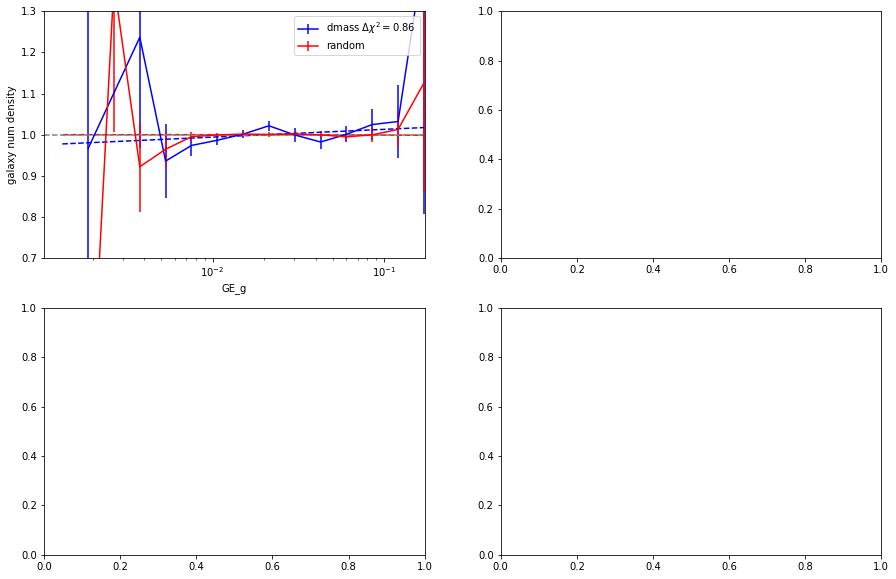

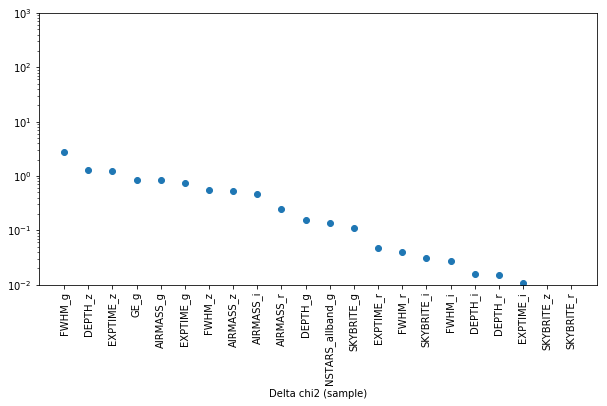

In [69]:
nextweight = 'SKYBRITE_z'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'AIRMASS_r', 'FWHM_r', 'SKYBRITE_z', 'AIRMASS_z', 'GE_g', 'noweight', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
AIRMASS_r
FWHM_r
SKYBRITE_z
AIRMASS_z
GE_g
noweight
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  FWHM_g
linear
store weight  FWHM_g
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_fwhm_g_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt
saving data to  ../data_txt/systematics/6th_incl

chi2_null =  20.406586420699917
chi2_mod. =  20.150434891673527
Delta chi2 (sample) = 0.2561515290263898
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt.model

chi2_null =  5.465060399560355
chi2_mod. =  5.44065941451402
Delta chi2 (sample) = 0.024400985046335144
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt.model

chi2_null =  5.70588702660647
chi2_mod. =  5.705108794072839
Delta chi2 (sample) = 0.0007782325336309626
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g.txt.model

chi2_null =  4.199413920049309
chi2_mod. =  4.040170282998199
Delta chi2 (sample) = 0.15924363705110967
output save to  ../data_txt/systematics/6th_include_ge/syste

(['AIRMASS_g',
  'DEPTH_z',
  'EXPTIME_z',
  'AIRMASS_i',
  'GE_g',
  'FWHM_z',
  'AIRMASS_r',
  'EXPTIME_g',
  'AIRMASS_z',
  'SKYBRITE_g',
  'SKYBRITE_i',
  'NSTARS_allband_g',
  'EXPTIME_r',
  'DEPTH_r',
  'DEPTH_g',
  'FWHM_r',
  'SKYBRITE_r',
  'FWHM_g',
  'DEPTH_i',
  'EXPTIME_i',
  'FWHM_i',
  'SKYBRITE_z'],
 [1.767798334588334,
  1.3185348590789312,
  1.0930650560974042,
  0.9342523058042875,
  0.8218363642903572,
  0.6921346767922962,
  0.5821011166753145,
  0.5052431295058835,
  0.4267935319602527,
  0.2561515290263898,
  0.15924363705110967,
  0.11234148204344763,
  0.09727268277710355,
  0.0932868873713848,
  0.0914829789198146,
  0.0375851248859842,
  0.024400985046335144,
  0.0042140033394879595,
  0.00415371802146014,
  0.002040757533318782,
  0.0017650399999471489,
  0.0007782325336309626])

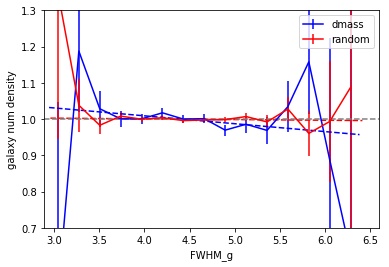

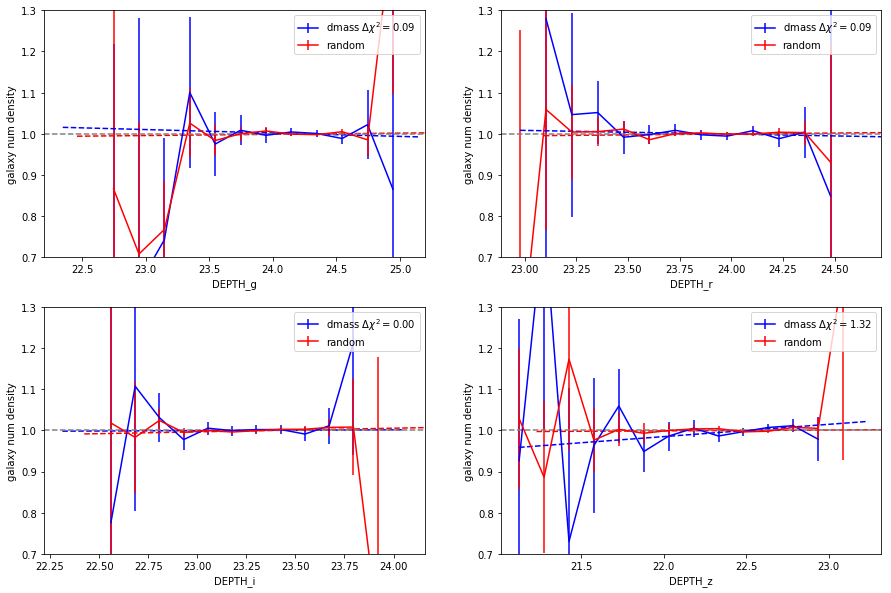

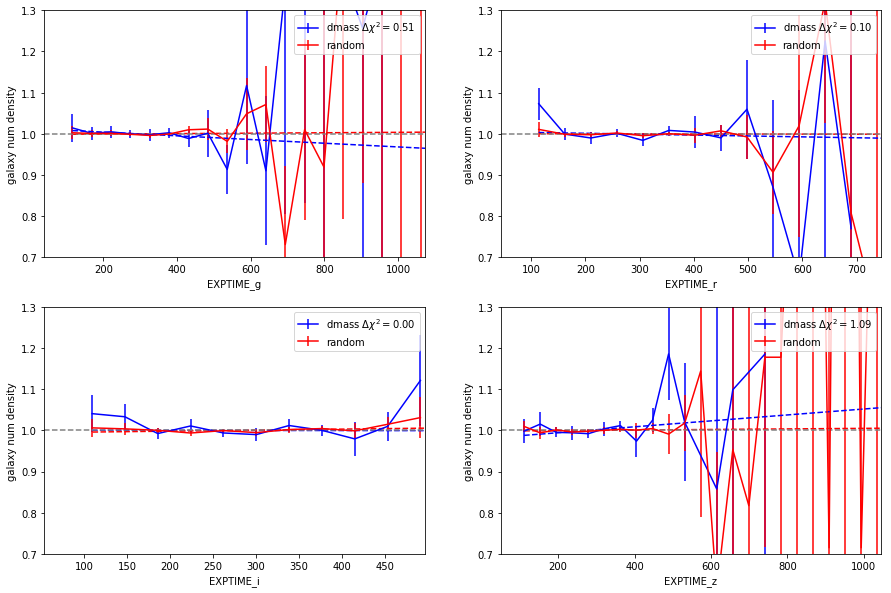

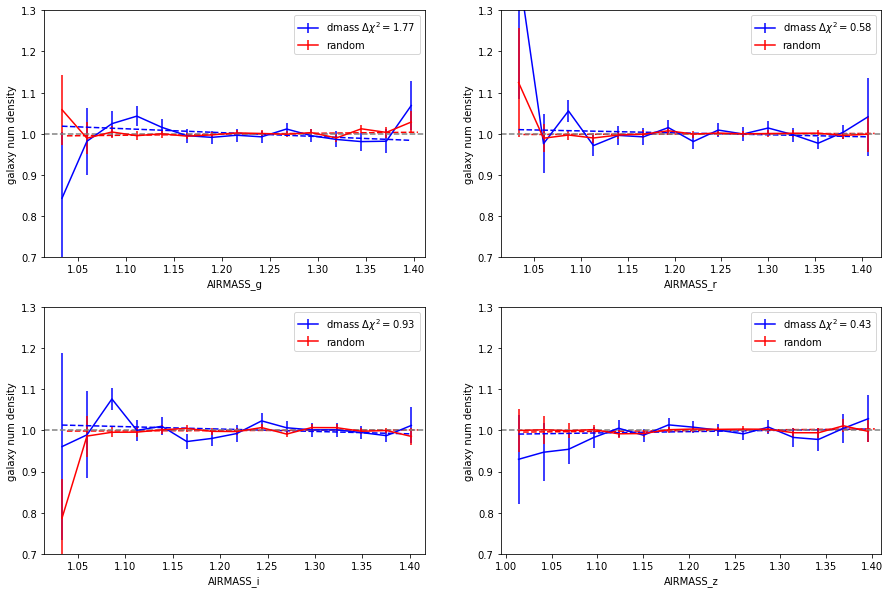

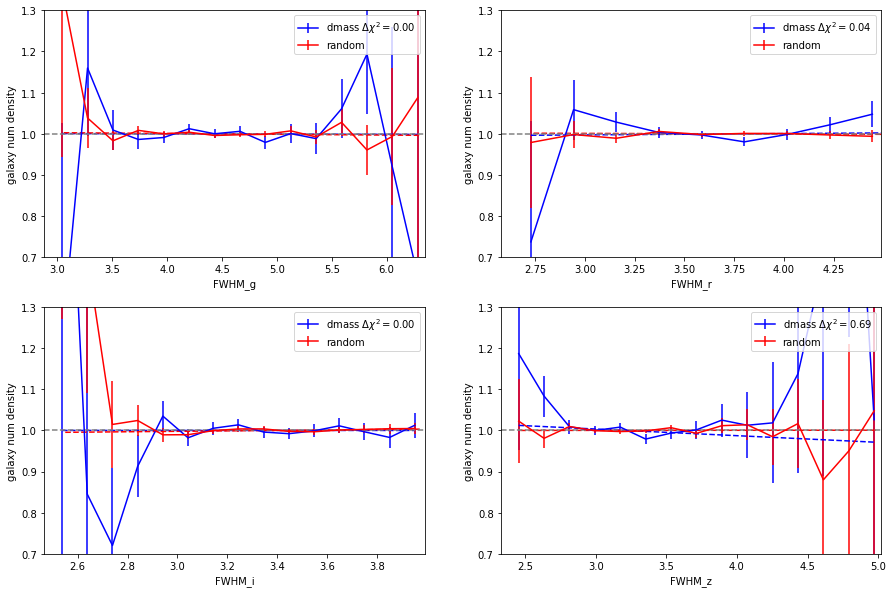

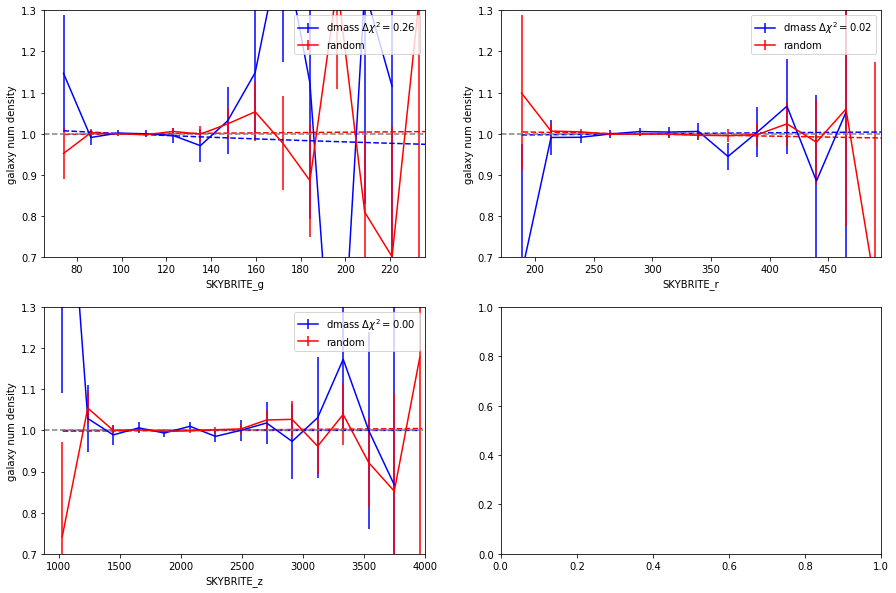

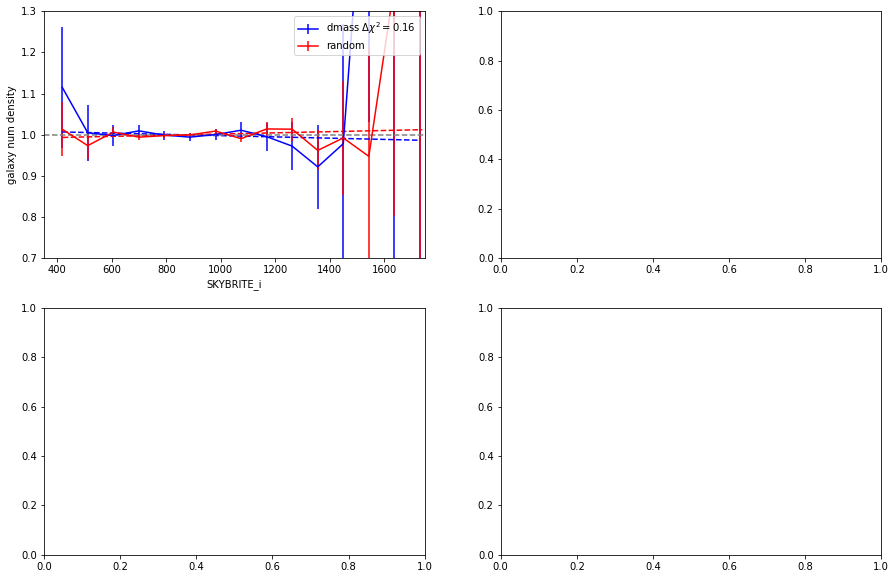

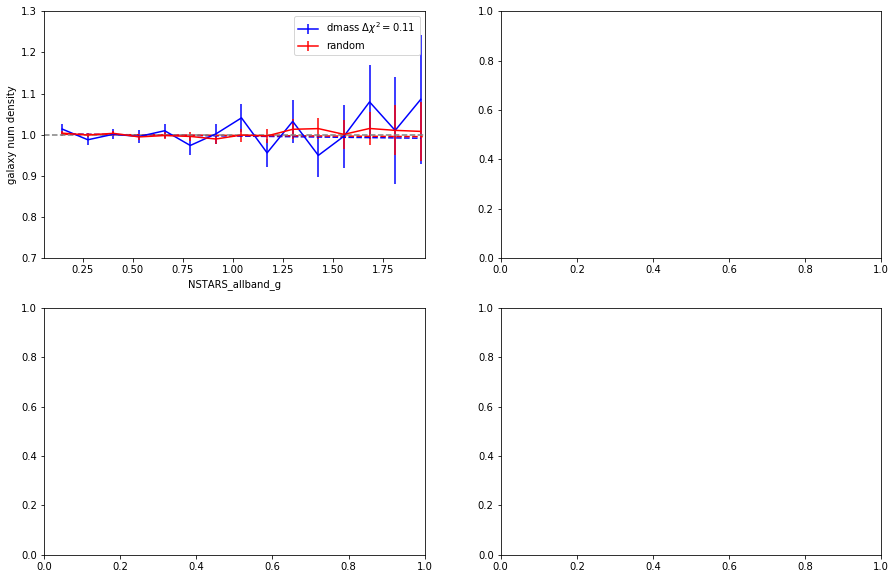

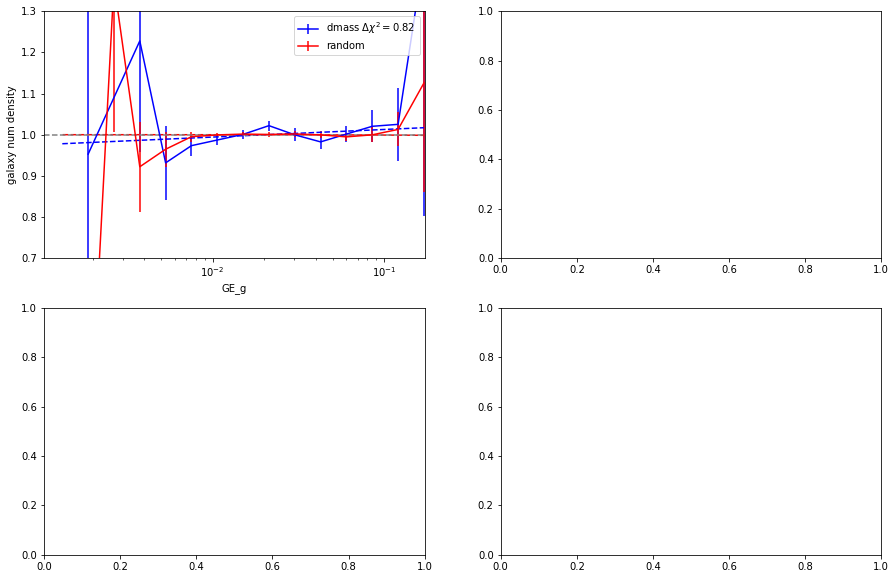

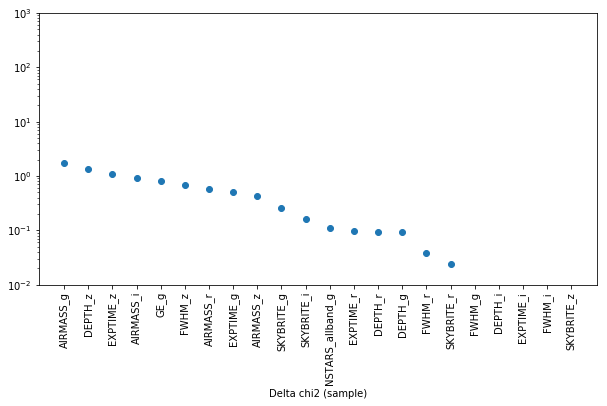

In [70]:
nextweight = 'FWHM_g'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'AIRMASS_r', 'FWHM_g', 'FWHM_r', 'SKYBRITE_z', 'AIRMASS_z', 'GE_g', 'noweight', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
AIRMASS_r
FWHM_g
FWHM_r
SKYBRITE_z
AIRMASS_z
GE_g
noweight
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  AIRMASS_g
linear
store weight  AIRMASS_g
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_airmass_g_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwh

chi2_null =  20.33018572349452
chi2_mod. =  20.312887574299204
Delta chi2 (sample) = 0.017298149195315915
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g.txt.model

chi2_null =  5.400317865618515
chi2_mod. =  5.390235283477719
Delta chi2 (sample) = 0.010082582140795715
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g.txt.model

chi2_null =  5.803636885788697
chi2_mod. =  5.737704587378501
Delta chi2 (sample) = 0.06593229841019532
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g.txt.model

chi2_null =  3.9461683093105187
chi2_mod. =  3.945754870560247
Delta chi2 (sample) = 0.0004134387502716663
output save to  ../data_tx

(['EXPTIME_z',
  'DEPTH_z',
  'AIRMASS_z',
  'GE_g',
  'FWHM_z',
  'EXPTIME_g',
  'NSTARS_allband_g',
  'FWHM_g',
  'DEPTH_g',
  'SKYBRITE_z',
  'AIRMASS_i',
  'EXPTIME_r',
  'FWHM_i',
  'SKYBRITE_g',
  'EXPTIME_i',
  'DEPTH_r',
  'FWHM_r',
  'SKYBRITE_r',
  'AIRMASS_r',
  'DEPTH_i',
  'AIRMASS_g',
  'SKYBRITE_i'],
 [1.2530707957567309,
  1.1957659681825028,
  0.7739663348896748,
  0.7049297990575845,
  0.46675761262986093,
  0.36032592956238263,
  0.2644967399280933,
  0.16955892554936547,
  0.06708201596474384,
  0.06593229841019532,
  0.03649681829941365,
  0.02606479721720767,
  0.023008333485528,
  0.017298149195315915,
  0.01720964083614085,
  0.012140937384837791,
  0.012107066746963824,
  0.010082582140795715,
  0.008207534979010944,
  0.004460485823306826,
  0.000954487548604277,
  0.0004134387502716663])

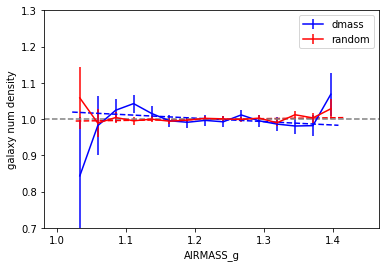

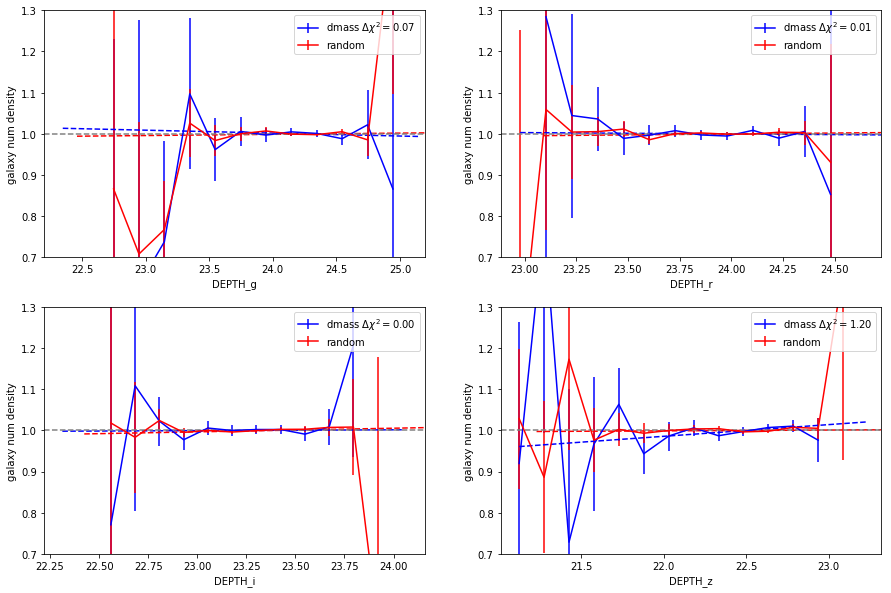

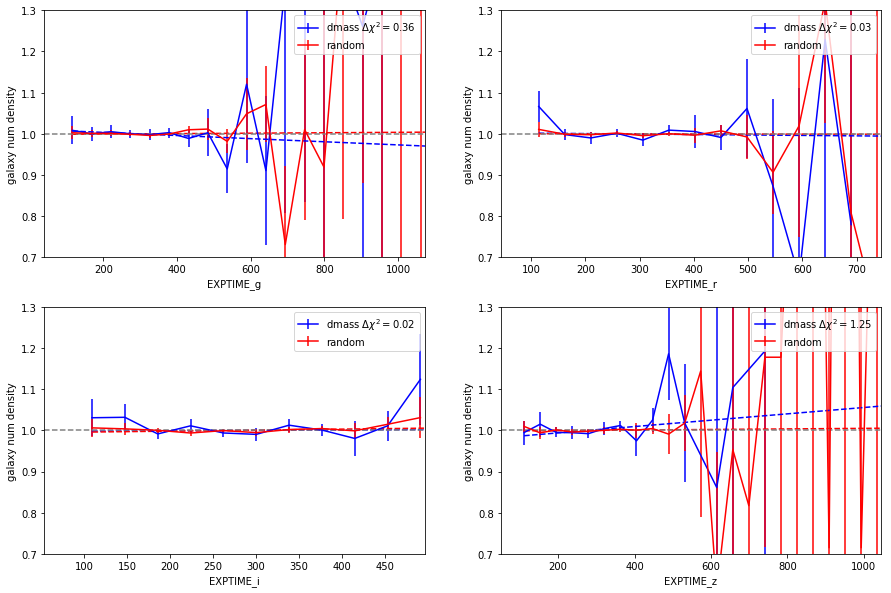

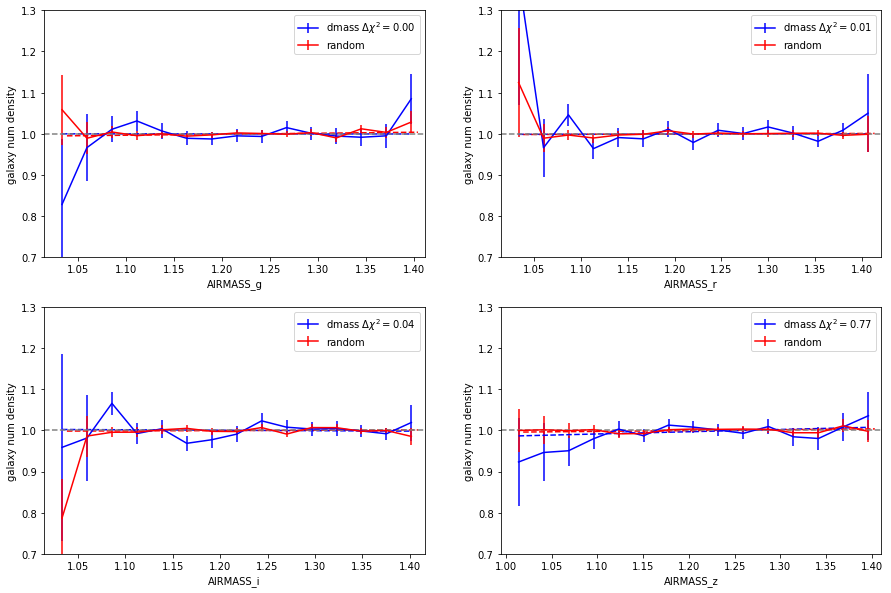

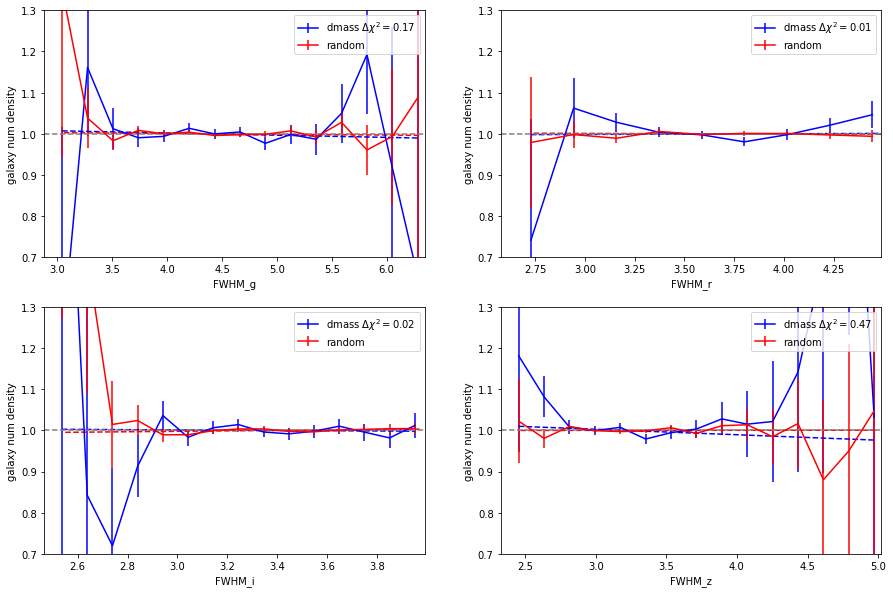

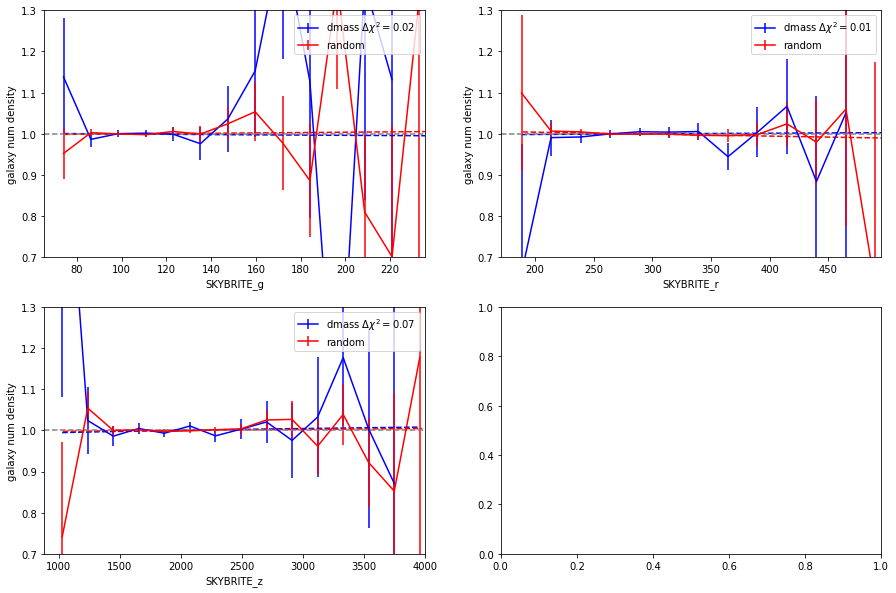

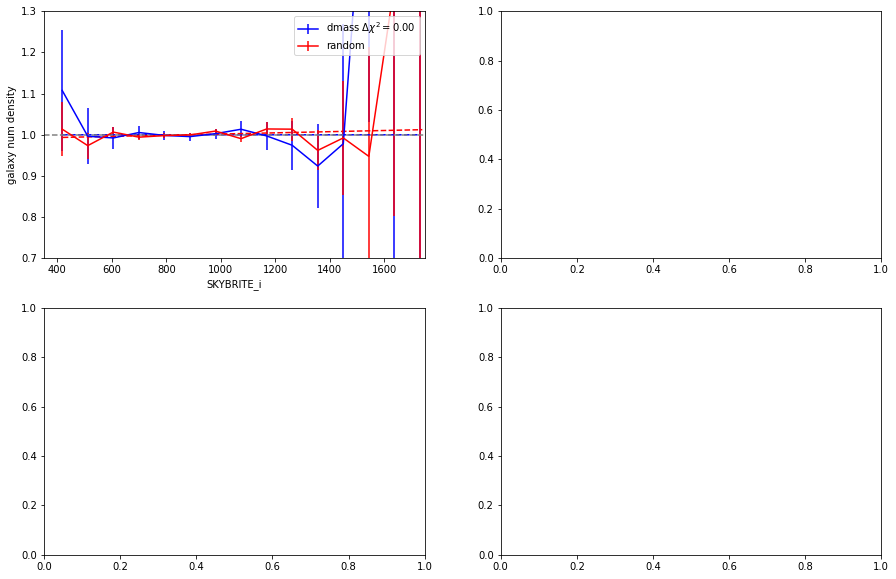

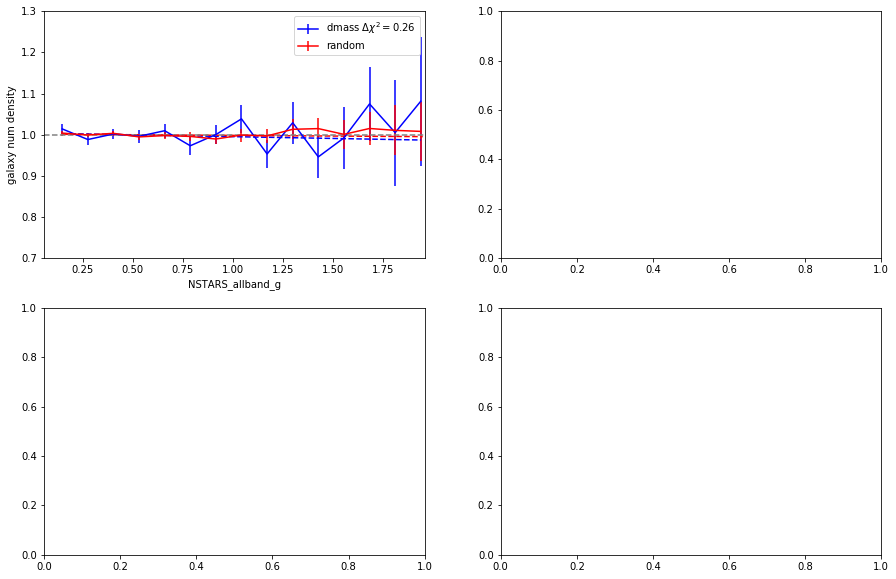

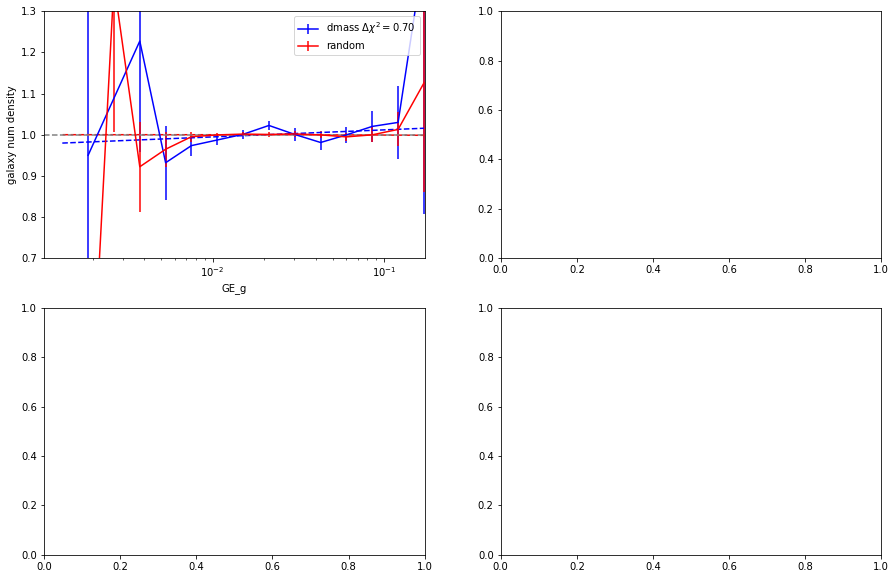

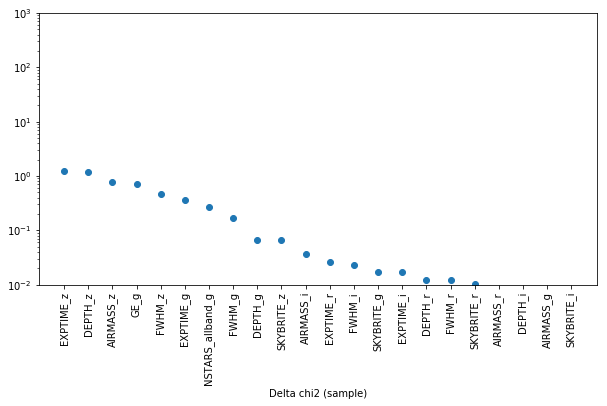

In [71]:
nextweight = 'AIRMASS_g'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'AIRMASS_r', 'FWHM_g', 'FWHM_r', 'SKYBRITE_z', 'AIRMASS_z', 'GE_g', 'noweight', 'AIRMASS_g', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
AIRMASS_r
FWHM_g
FWHM_r
SKYBRITE_z
AIRMASS_z
GE_g
noweight
AIRMASS_g
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  EXPTIME_z
linear
store weight  EXPTIME_z
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_exptime_z_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z


../systematics.py:451: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:455: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:455: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt


../systematics.py:451: RuntimeWarning: divide by zero encountered in divide
  Ngal_avg = Ngal *1./Nrand


saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_EXPTIME_z_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_AIRMASS_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_AIRMASS_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_AIRM

chi2_null =  4.0641004032011345
chi2_mod. =  4.061890840855005
Delta chi2 (sample) = 0.0022095623461293457
output save to  ../data_txt/systematics/6th_include_ge/systematic_SKYBRITE_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt.model

chi2_null =  9.503557720505446
chi2_mod. =  9.217510918279356
Delta chi2 (sample) = 0.2860468022260907
output save to  ../data_txt/systematics/6th_include_ge/systematic_NSTARS_allband_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt.model

chi2_null =  8.976854879578353
chi2_mod. =  8.256398939723208
Delta chi2 (sample) = 0.7204559398551442
output save to  ../data_txt/systematics/6th_include_ge/systematic_GE_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z.txt.model

[1.8525890018172069, 0.8949869021267958, 0.8427864360546886, 0.7466429797419565, 0.7204559398551442, 0.69

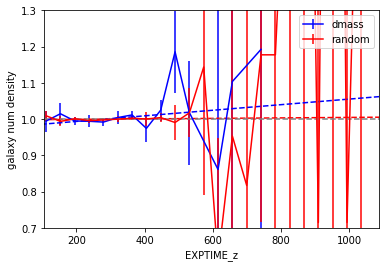

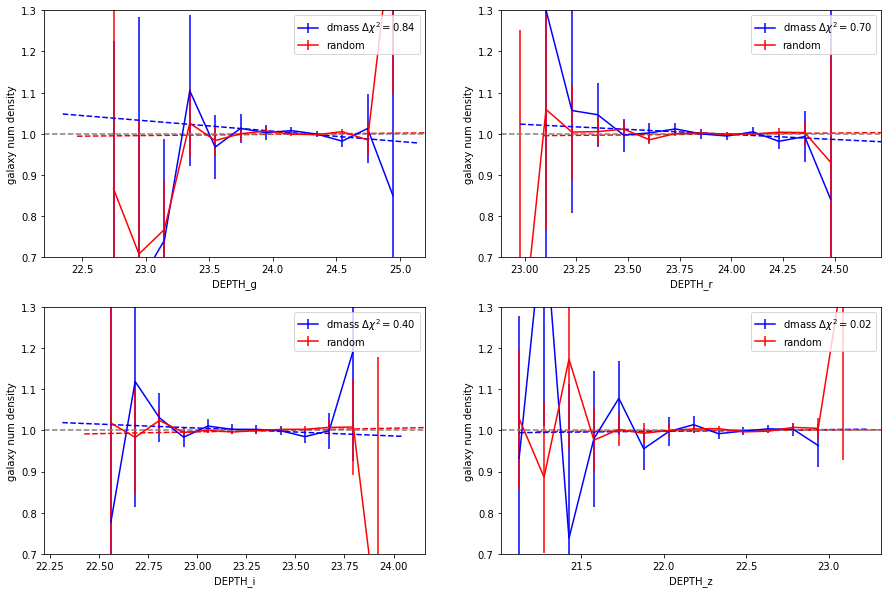

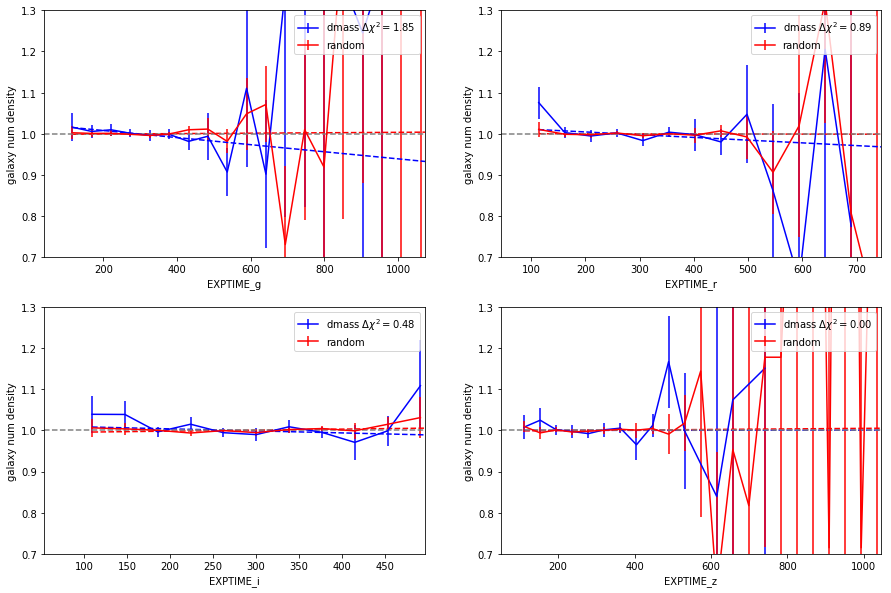

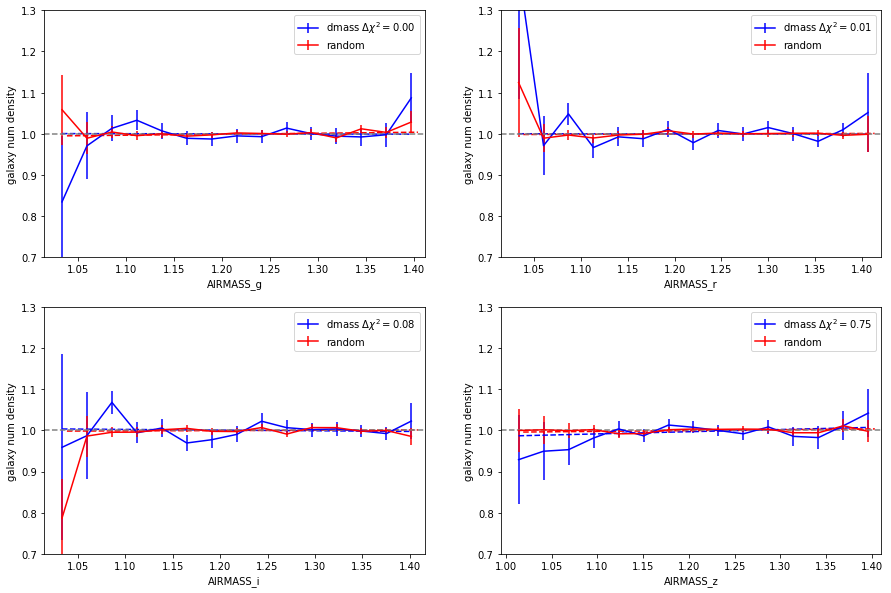

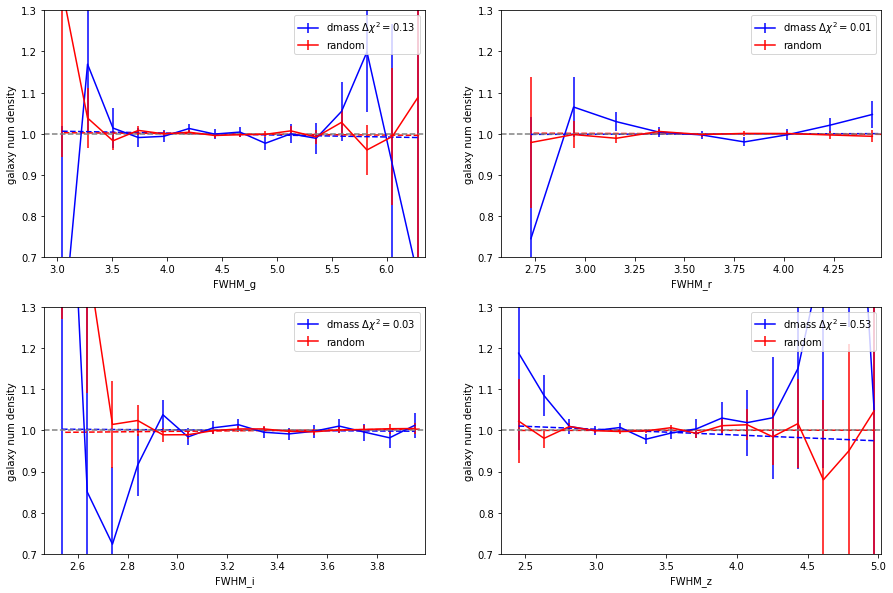

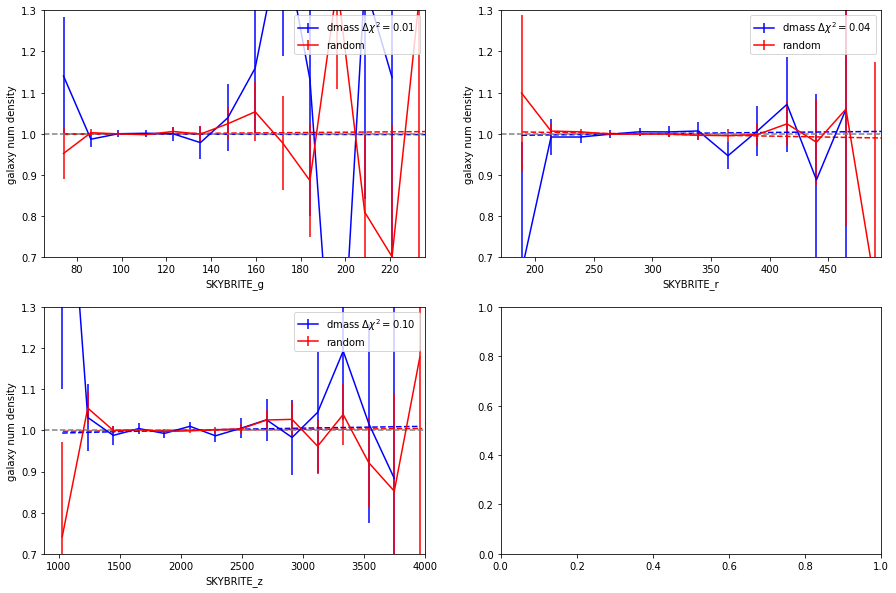

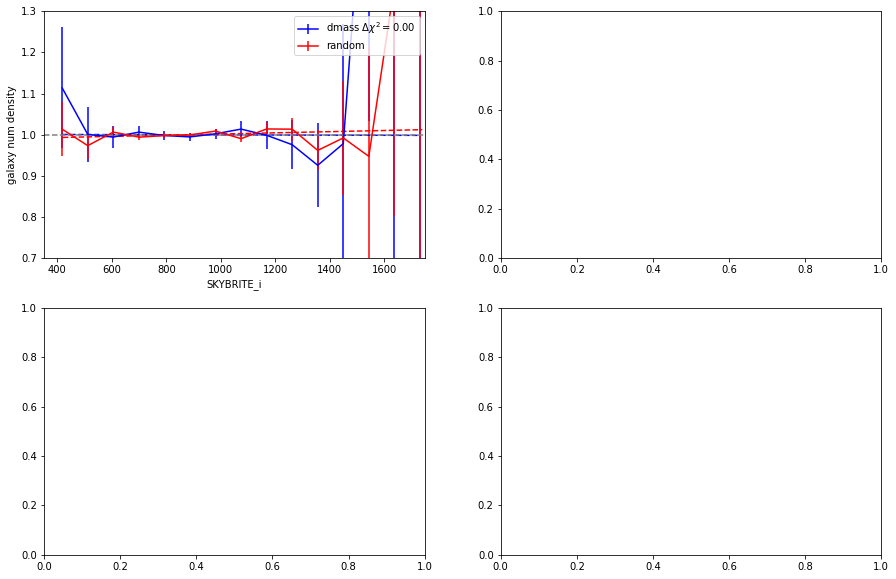

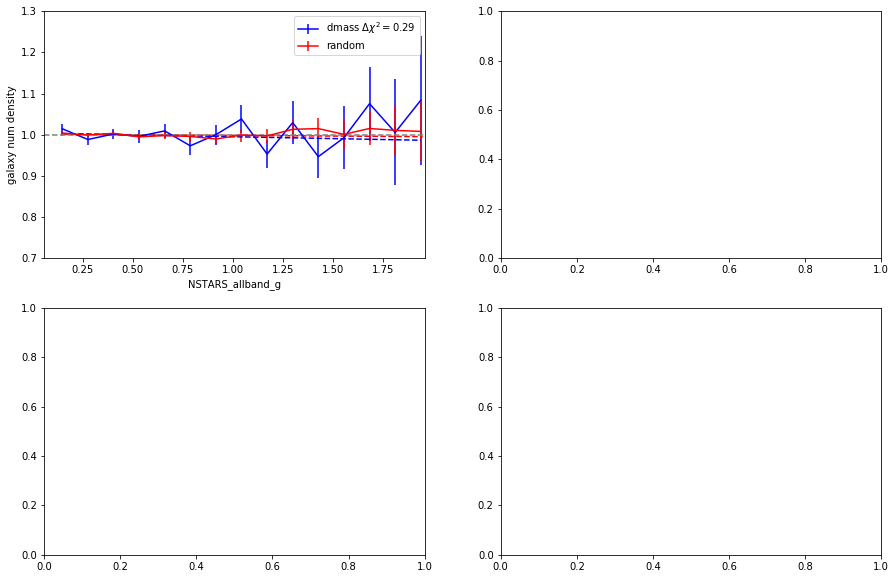

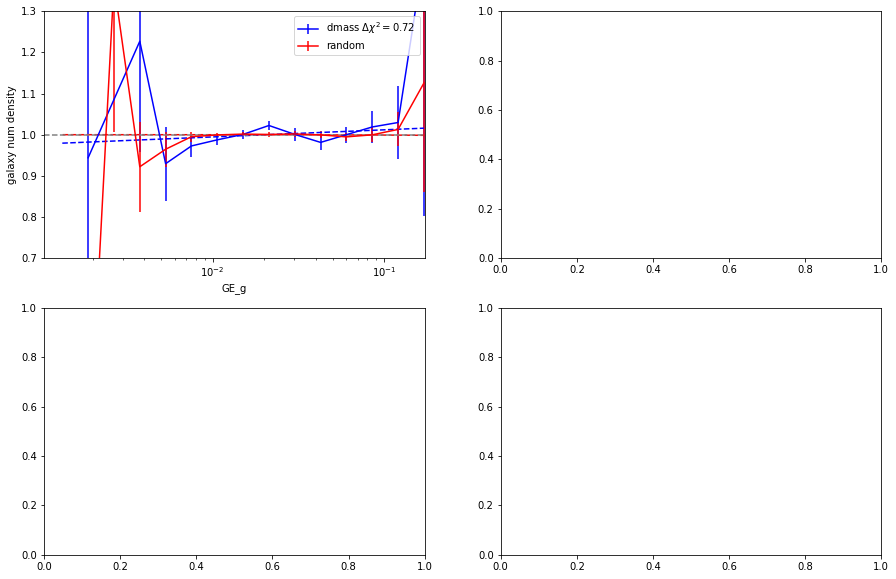

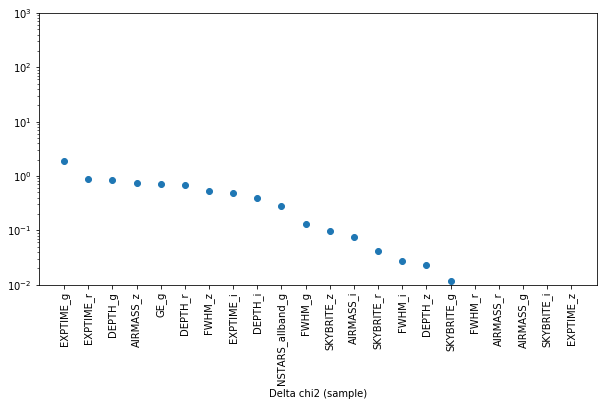

(['EXPTIME_g',
  'EXPTIME_r',
  'DEPTH_g',
  'AIRMASS_z',
  'GE_g',
  'DEPTH_r',
  'FWHM_z',
  'EXPTIME_i',
  'DEPTH_i',
  'NSTARS_allband_g',
  'FWHM_g',
  'SKYBRITE_z',
  'AIRMASS_i',
  'SKYBRITE_r',
  'FWHM_i',
  'DEPTH_z',
  'SKYBRITE_g',
  'FWHM_r',
  'AIRMASS_r',
  'AIRMASS_g',
  'SKYBRITE_i',
  'EXPTIME_z'],
 [1.8525890018172069,
  0.8949869021267958,
  0.8427864360546886,
  0.7466429797419565,
  0.7204559398551442,
  0.6963111638731565,
  0.5294640057846927,
  0.4828174453398324,
  0.40088416882015077,
  0.2860468022260907,
  0.1331894581452726,
  0.09605139187858924,
  0.07682885211981194,
  0.041704094592064145,
  0.02692829732364377,
  0.023358557203517982,
  0.01157588421222755,
  0.006526198821063645,
  0.006218157402571478,
  0.003894978514853875,
  0.0022095623461293457,
  0.00020157332906922676])

In [76]:
nextweight = 'EXPTIME_z'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITE_r', 'EXPTIME_z', 'AIRMASS_r', 'FWHM_g', 'FWHM_r', 'SKYBRITE_z', 'AIRMASS_z', 'GE_g', 'noweight', 'AIRMASS_g', 'SKYBRITE_i', 'FWHM_i']
SKYBRITE_r
EXPTIME_z
AIRMASS_r
FWHM_g
FWHM_r
SKYBRITE_z
AIRMASS_z
GE_g
noweight
AIRMASS_g
SKYBRITE_i
FWHM_i
----------------------------------
initialize function  EXPTIME_g
linear
store weight  EXPTIME_g
save weight to fits ../data_txt/systematics/6th_include_ge//weights/wg_exptime_g_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g.txt
saving data to  ../data_txt/systematics/6th_include_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g.txt
saving data to  ../data_txt/systematics/6th_includ

chi2_null =  8.389265032326376
chi2_mod. =  8.329445175091678
Delta chi2 (sample) = 0.059819857234698404
output save to  ../data_txt/systematics/6th_include_ge/systematic_FWHM_g_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g.txt.model

chi2_null =  9.528329787189659
chi2_mod. =  9.51654630287614
Delta chi2 (sample) = 0.0117834843135185
output save to  ../data_txt/systematics/6th_include_ge/systematic_FWHM_r_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g.txt.model

chi2_null =  8.122988461585184
chi2_mod. =  8.097366838728847
Delta chi2 (sample) = 0.0256216228563364
output save to  ../data_txt/systematics/6th_include_ge/systematic_FWHM_i_SPT_wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g.txt.model

chi2_null =  10.548081223601933
chi2_mod. =  10.02035455904744
Delta chi2 (sample) = 0.527

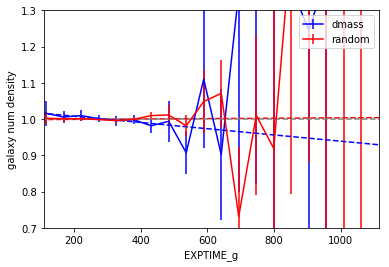

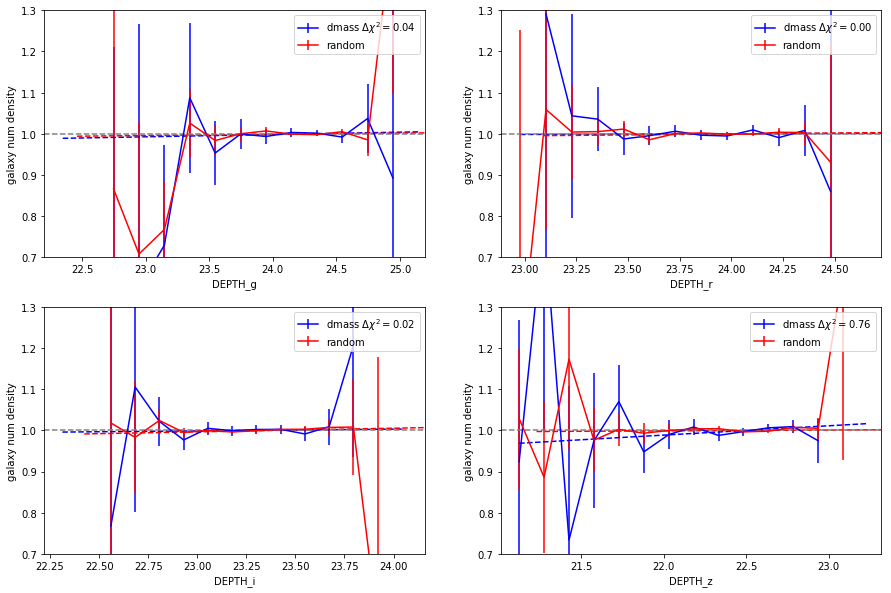

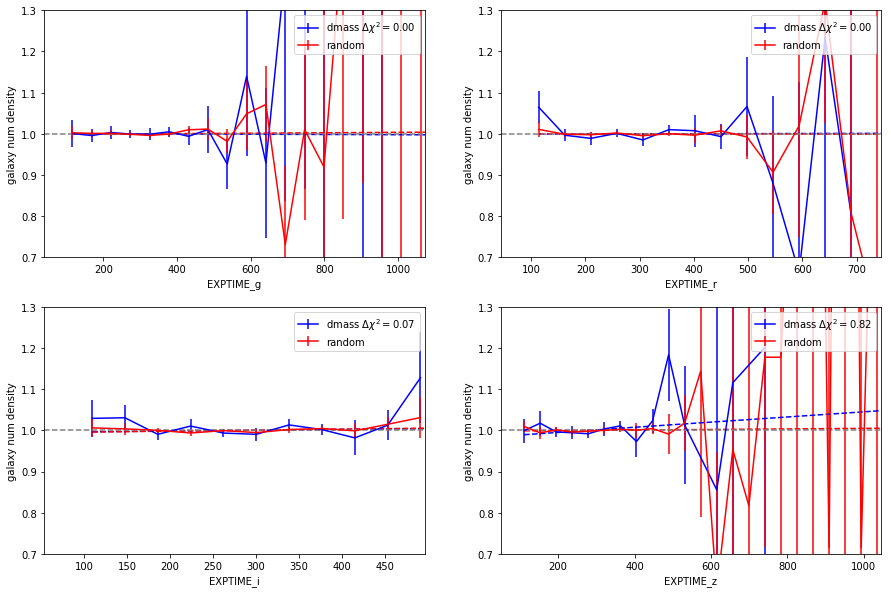

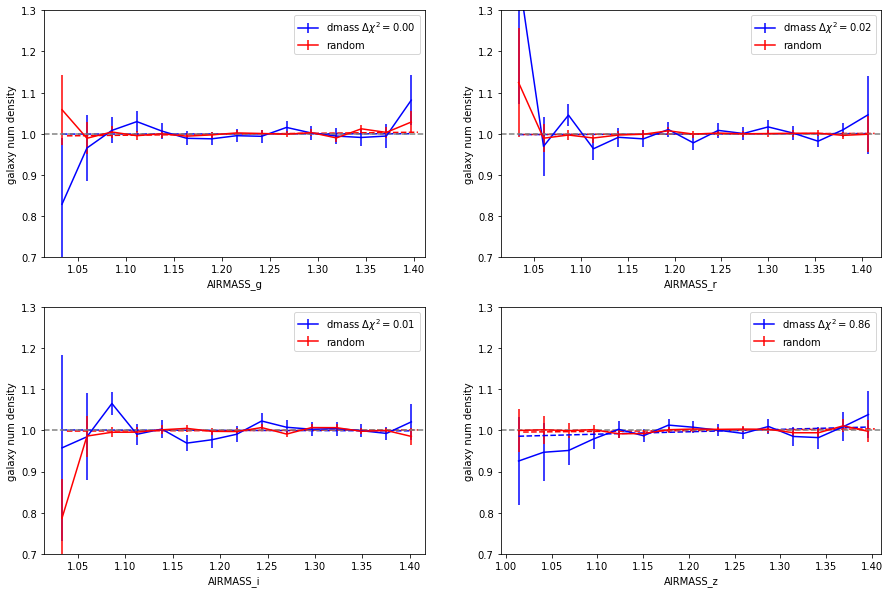

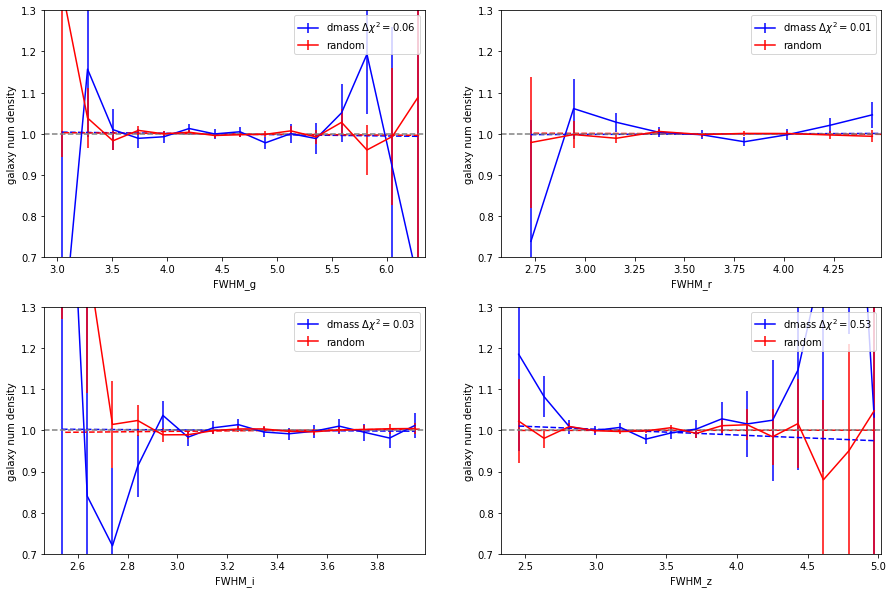

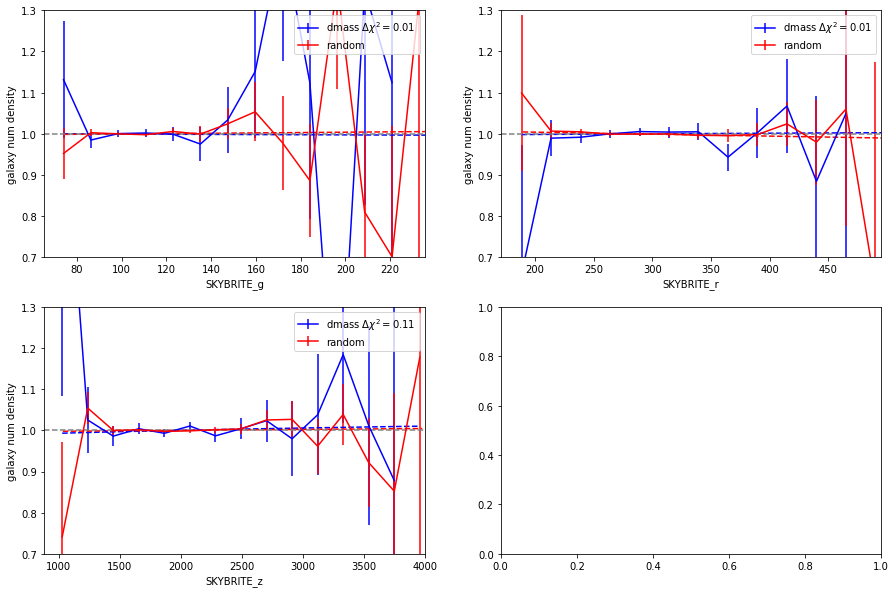

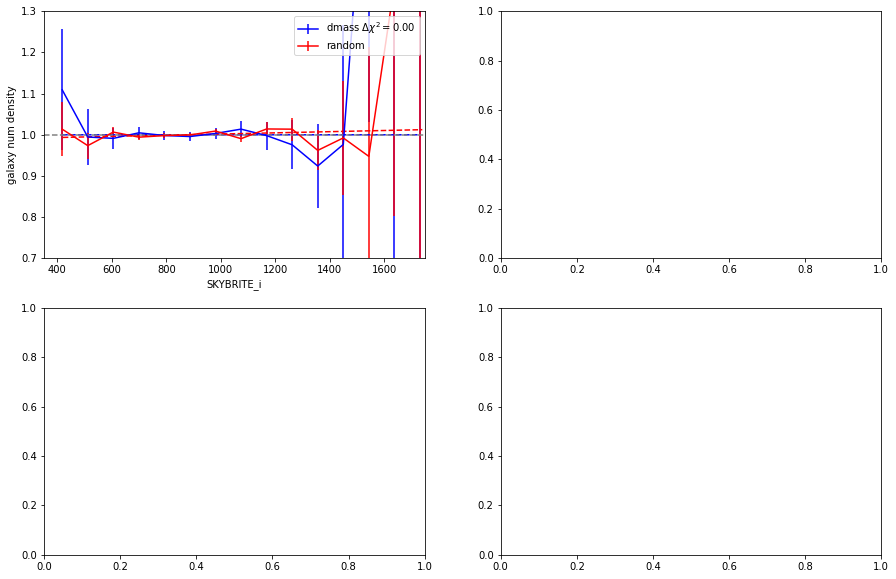

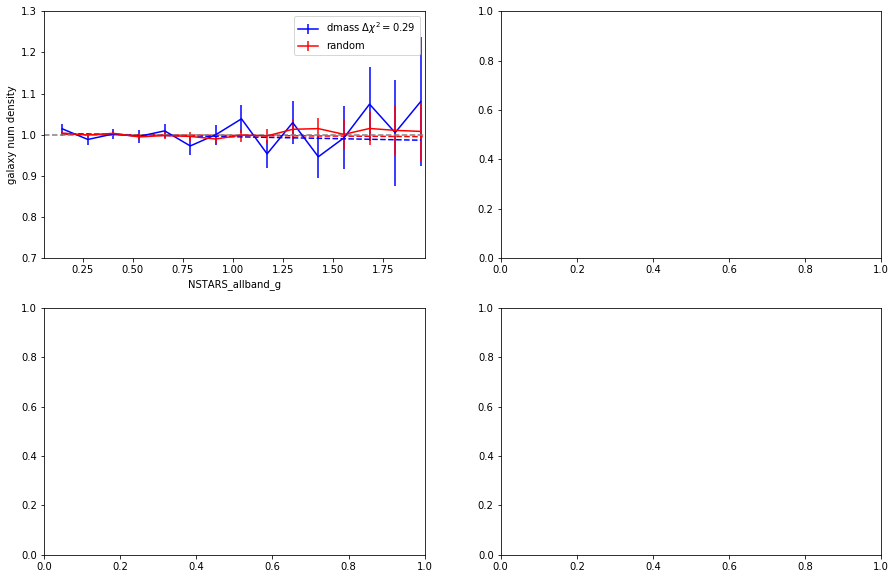

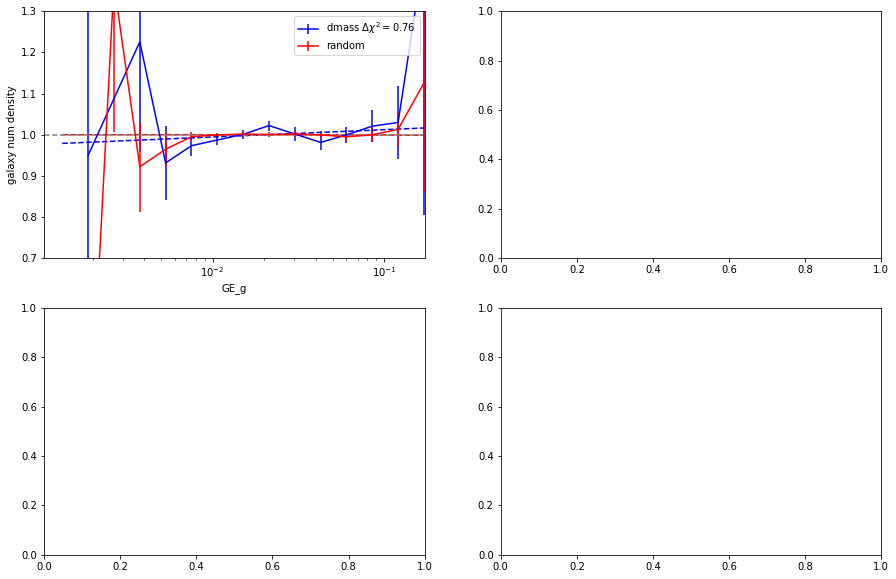

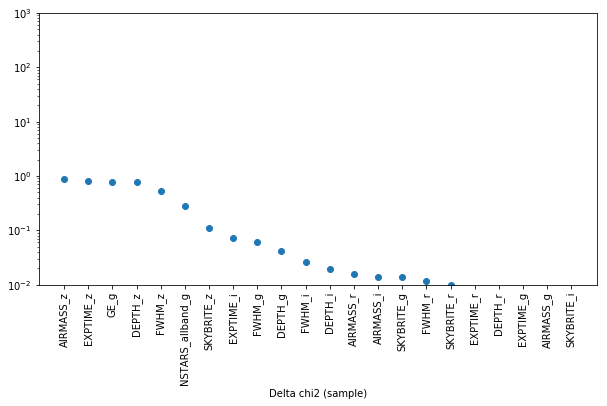

(['AIRMASS_z',
  'EXPTIME_z',
  'GE_g',
  'DEPTH_z',
  'FWHM_z',
  'NSTARS_allband_g',
  'SKYBRITE_z',
  'EXPTIME_i',
  'FWHM_g',
  'DEPTH_g',
  'FWHM_i',
  'DEPTH_i',
  'AIRMASS_r',
  'AIRMASS_i',
  'SKYBRITE_g',
  'FWHM_r',
  'SKYBRITE_r',
  'EXPTIME_r',
  'DEPTH_r',
  'EXPTIME_g',
  'AIRMASS_g',
  'SKYBRITE_i'],
 [0.8611068070065286,
  0.8244416830189332,
  0.7622369090906655,
  0.7588328617093199,
  0.5277266645544927,
  0.2851975626507546,
  0.10812070365966786,
  0.07314656097307015,
  0.059819857234698404,
  0.042453575855201375,
  0.0256216228563364,
  0.019382077338209402,
  0.015539090624029583,
  0.013997507385722585,
  0.013768693194158743,
  0.0117834843135185,
  0.009989975491238923,
  0.003043516819810854,
  0.002756031950707616,
  0.0023021097562327952,
  0.0017475306456908868,
  0.00041084959856974024])

In [97]:
nextweight = 'EXPTIME_g'
all_weight = weightmultiply(weightDic)
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
fitting_allSP( suffix, inputdir = inputdir )
plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

In [110]:
inputdir

'../data_txt/systematics/6th_include_ge/'

In [111]:
suffix

'wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g'

In [99]:
suf1 = 'wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r'
suf2 = suffix

[79.83735512899429, 53.49617865476577, 28.509744706065348, 26.760437131711505, 18.367289560103742, 17.471874037287286, 13.953920005412595, 11.590416835281749, 7.180282678905282, 5.015956513125536, 3.9620365550386714, 1.8176606759773017, 1.042187768236305, 0.8288005497627875, 0.6149681116305241, 0.45263595633948484, 0.2764250508388004, 0.13316766113053813, 0.12007363708290963, 0.11243766010556655, 0.010894676698766759, 0.005140852971523557]


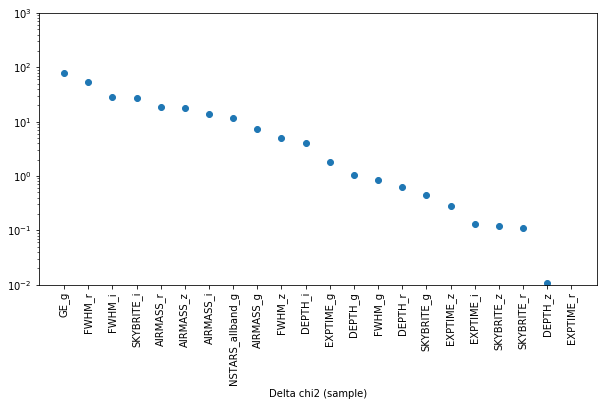

[3.7047709322593807, 3.4598303522899183, 3.419781315245311, 3.1824998355527274, 1.6916223655377856, 1.648829213318744, 1.0418000839131167, 0.9693450174595748, 0.7640574654055108, 0.7592571938161683, 0.620261450495625, 0.5357727031113795, 0.28127896140463626, 0.2721838263926406, 0.22346149428401763, 0.21718457779754274, 0.16193857639876974, 0.12984715579222383, 0.09553049434567917, 0.0342812833380175, 0.03100786810731293, 0.015436922889901616]


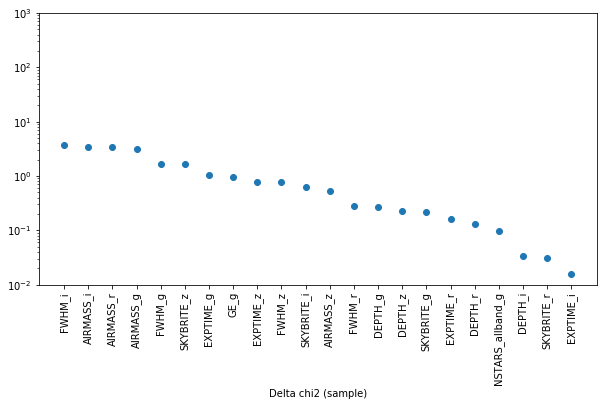

[0.8611068070065286, 0.8244416830189332, 0.7622369090906655, 0.7588328617093199, 0.5277266645544927, 0.2851975626507546, 0.10812070365966786, 0.07314656097307015, 0.059819857234698404, 0.042453575855201375, 0.0256216228563364, 0.019382077338209402, 0.015539090624029583, 0.013997507385722585, 0.013768693194158743, 0.0117834843135185, 0.009989975491238923, 0.003043516819810854, 0.002756031950707616, 0.0023021097562327952, 0.0017475306456908868, 0.00041084959856974024]


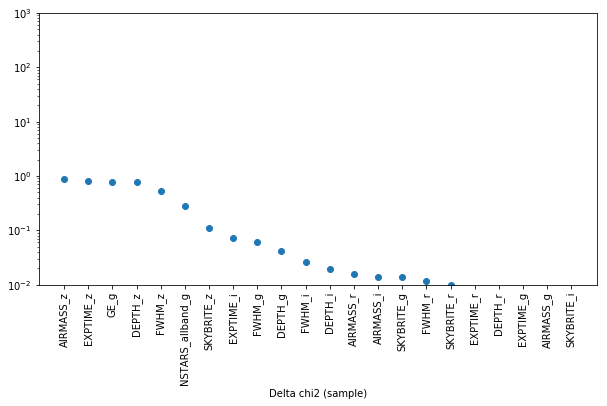

In [100]:
label_no_weight, values_no_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix='no_weight', 
                    path = inputdir, deltachi2=True)
label_full_weight, values_full_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suf1, 
                    path = inputdir, deltachi2=True)
label_full_weight2, values_full_weight2 = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suf2, 
                    path = inputdir, deltachi2=True)

In [108]:
suffix

'wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g'

0

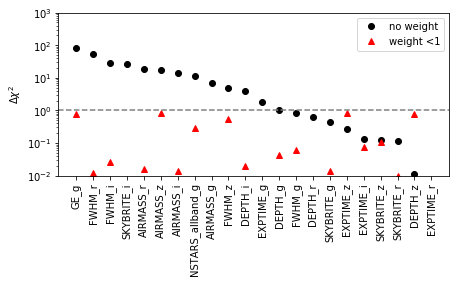

In [107]:

values_full_weight_reorder2 = []
for la in label_no_weight:
    for j in range(len(label_full_weight2)):
        if la == label_full_weight2[j]: 
            values_full_weight_reorder2.append(values_full_weight2[j])
            break
            
values_full_weight_reorder = np.array(values_full_weight_reorder)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_weight) ), values_no_weight,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder2, 'r^', label='weight <1'  )


#ax.plot( values_no_weight, np.arange( len(values_no_weight) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_weight) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 1, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_weight)))
ax.set_xticklabels(label_no_weight, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')

fig.savefig(inputdir+'comparison2_chisquare_'+suffix+'.png')
0

0

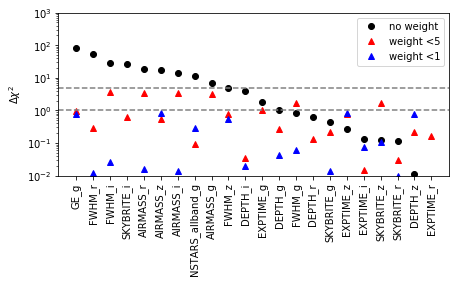

In [105]:

values_full_weight_reorder = []
for la in label_no_weight:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break

values_full_weight_reorder2 = []
for la in label_no_weight:
    for j in range(len(label_full_weight2)):
        if la == label_full_weight2[j]: 
            values_full_weight_reorder2.append(values_full_weight2[j])
            break
            
values_full_weight_reorder = np.array(values_full_weight_reorder)
values_full_weight_reorder2 = np.array(values_full_weight_reorder2)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_weight) ), values_no_weight,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder, 'r^', label='weight <5'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder2, 'b^', label='weight <1'  )


#ax.plot( values_no_weight, np.arange( len(values_no_weight) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_weight) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 5, ls = '--', color='grey')
ax.axhline(y = 1, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_weight)))
ax.set_xticklabels(label_no_weight, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')

fig.savefig(inputdir+'comparison3_chisquare_'+suffix+'.png')
0

saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_GE_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth_g.png


0

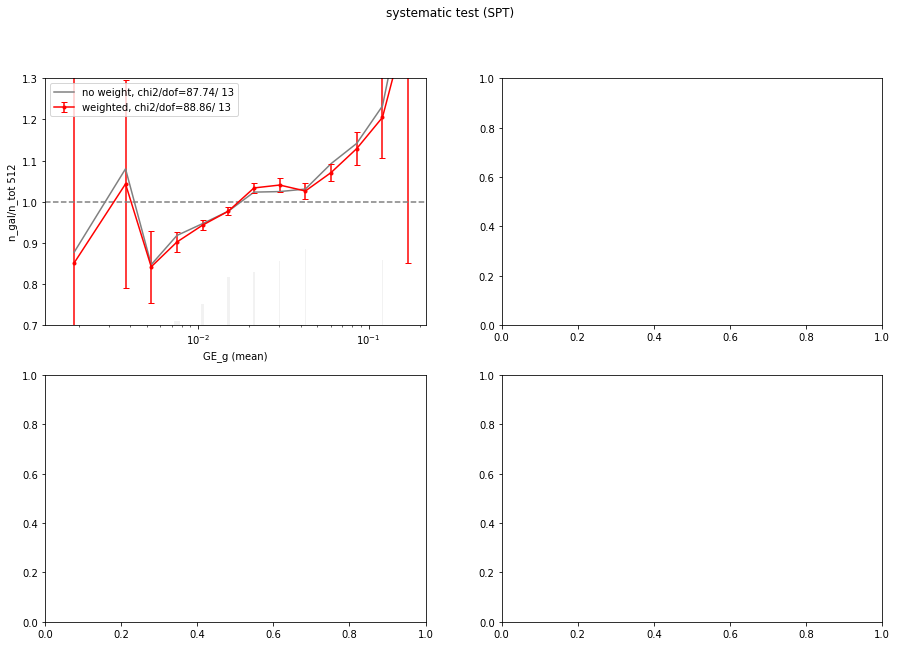

In [129]:
from systematics_module.contCorrection import plot_sysweight
plot_sysweight(property = 'GE', nside = 1024, kind = 'SPT', 
           suffix1='no_weight', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

In [2]:
from systematics_module.contCorrection import plot_sysweight
for pr in properties:
    plot_sysweight(property = pr, nside = 4096, kind = 'SPT', 
               suffix1='no_weight', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)



ImportError: No module named systematics_module.contCorrection